## Importing Libraries And Downloading Data

In [2]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import random
import math
from sklearn.model_selection import train_test_split
import wandb


In [3]:
wandb.login()
wandb.init(project = "Deep Learning Assignment")


wandb: Currently logged in as: dharanivendhanv01 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Splitting data

In [4]:
#splitting the data

(x1,y1),(x2,y2) = fashion_mnist.load_data()
x1 = x1 / 255.0
x2 = x2 / 255.0
x_train1,x_test2,y_train1,y_test2 = train_test_split(x1 , y1 , test_size = 0.1 , random_state = 0)

### Data preprocessing

In [5]:
x_train = x_train1.reshape(54000,784).T
y1_train = y_train1.reshape(54000,1).T
x_test  = x_test2.reshape(6000,784).T
y1_test  = y_test2.reshape(6000,1).T
print("without one-hot encoding")
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y1_train.shape)
print("shape of x_test  :",x_test.shape)
print("shape of y_test  :",y1_test.shape)

without one-hot encoding
shape of x_train : (784, 54000)
shape of y_train : (1, 54000)
shape of x_test  : (784, 6000)
shape of y_test  : (1, 6000)


In [6]:
#one hot encoding

y_train = np.zeros((10,y1_train.shape[1]))
for i in range(0,y1_train.shape[1]):
    for j in range(0,10):
        if y1_train[0,i] == j:
            y_train[j,i] = 1
            
y_test = np.zeros((10,y1_test.shape[1]))
for i in range(0,y1_test.shape[1]):
    for j in range(0,10):
        if y1_test[0,i] == j:
            y_test[j,i] = 1


In [7]:
num_classes = y_train.shape[0]
class_name = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
print("after one_hot encoding")
print("number of classes:",num_classes)
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test  :",x_test.shape)
print("shape of y_test  :",y_test.shape)


after one_hot encoding
number of classes: 10
shape of x_train : (784, 54000)
shape of y_train : (10, 54000)
shape of x_test  : (784, 6000)
shape of y_test  : (10, 6000)


### Logging sample images

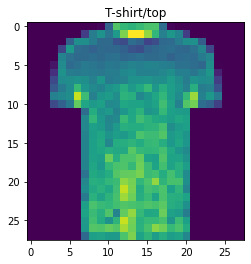

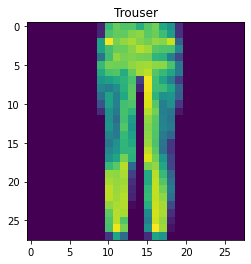

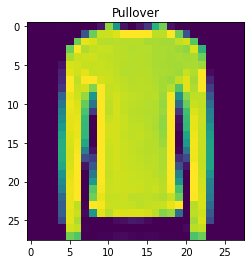

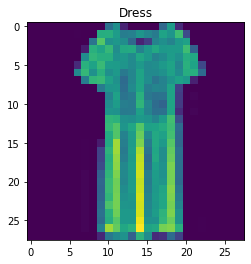

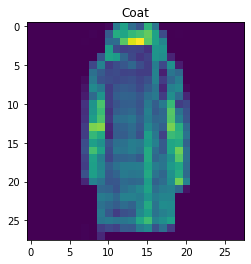

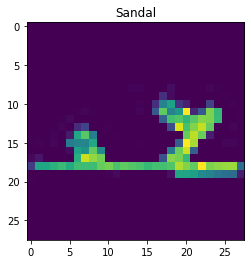

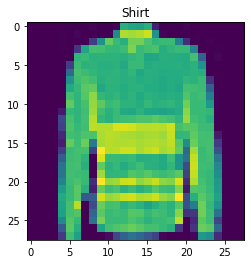

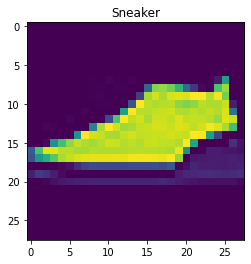

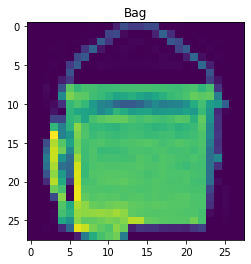

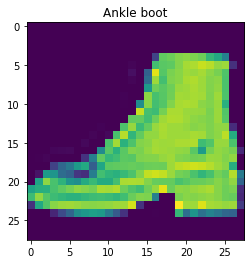

In [8]:
images_list = []
classes_list = []
i = 0

for j in range(y1_train.shape[1]):
        
        if y1_train[0,j] == i and i<=9:
            images = x_train[:,j].reshape(28,28)
            images_list.append(images)
            classes_list.append(class_name[y1_train[0,j]])
            i = i+1
        else:
            j = j+1
            
for i in range(num_classes):
    
    plt.imshow(images_list[i])
    plt.title(classes_list[i])
    plt.show()

In [9]:
wandb.log({"Qn 1":[wandb.Image(img,caption = caption) for img,caption in zip(images_list,classes_list)]})

## Neural Network models 

#### Activation functions and its derivative

In [10]:
# Defining Activation function for neural network

def sigmoid_function(x):
    exp = np.exp(-x)
    return 1/(1+exp)

def sigmoid_derivative(x):
    return sigmoid_function(x) * (1-sigmoid_function(x))

def tanh_function(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def ReLu(x):
    return np.maximum(0,x)

def ReLu_derivative(x):
    return 1*(x>0) 

def softmax_function(x):
    
    exps = np.exp(x - np.max(x , axis=0, keepdims = True))
    return exps / np.sum(exps, axis=0 , keepdims = True)

def softmax_derivative(x):
    return softmax_function(x) * (1-(softmax_function(x)))

def cost_function(al,y,Batch_size,loss,lamb,parameters):
    al = np.clip(al, 1e-9, 1 - 1e-9)                                                    # Clip to avoid taking the log of 0 or 1
    if loss == 'cross_entropy':
        if y.shape[0] == 1:                                                             # binary classification 
            cost = (1/Batch_size) * (-np.dot(y,np.log(al).T) - np.dot(1-y, np.log(1-al).T))
        else:                                                                           # multiclass-classification
            cost = -(1/Batch_size) * np.sum(y * np.log(al))
    elif loss == 'mse':
         cost = (1/2) * np.sum((y-al)**2)/Batch_size
    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)
    cost = cost + (lamb/(2*Batch_size))*acc
    cost = np.squeeze(cost)      
    return cost

def accuracy(inp, labels, parameters):
    forward_prop = Forward_Propagation(inp, parameters , activation_function)
    a_out = forward_prop['a2']   # containes propabilities with shape(10, 1)
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    labels = np.argmax(labels, 0)
    acc = np.mean(a_out == labels)*100
    
    return acc

#### Intializing parameters

In [11]:
def init_parameters(layers , init_mode):  #initializing parameters
    
    np.random.seed(42)
    Parameters = {}
    Previous_Updates = {}
    L = len(layers)           #no.of layers
    
    for l in range(1, L):     #except the last activation layer
        if init_mode == 'Random_normal':
            Parameters['W'+str(l)] = np.random.randn(layers[l],layers[l-1])
            
        elif init_mode == 'Random_uniform':
            Parameters['W'+str(l)] = np.random.rand(layers[l],layers[l-1])  
            
        elif init_mode == 'Xavier':
            Parameters['W'+str(l)] = np.random.randn(layers[l],layers[l-1])*np.sqrt(2/(layers[l]+layers[l-1]))
            
            
        Parameters['b'+str(l)] = np.zeros((layers[l],1))
        
        Previous_Updates['W'+str(l)] = np.zeros((layers[l],layers[l-1]))
        Previous_Updates['b'+str(l)] = np.zeros((layers[l], 1))
        
    return Parameters,Previous_Updates


#### Forward propagation

In [12]:
def Forward_Propagation(x, Parameters, activation_function):
   
    forward_prop = {}
    L = math.floor(len(Parameters)/2)                  
    
    #first activation layer will be input layer itself
    
    forward_prop['h0'] = x 
    
    # tanh or ReLu activation functions are used for l-1 layers
    for l in range(1, L):
        
    # ai+1 = Wi+1 * hij + bi+1   
        forward_prop['a' + str(l)] = np.dot(Parameters['W' + str(l)],forward_prop['h' + str(l-1)]) + Parameters['b' + str(l)]
        
        if activation_function == 'tanh':
            forward_prop['h' + str(l)] = tanh_function(forward_prop['a' + str(l)])
        elif activation_function == 'ReLu':
            forward_prop['h' + str(l)] = ReLu(forward_prop['a' + str(l)])
        elif activation_function == 'sigmoid':
            forward_prop['h' + str(l)] = sigmoid_function(forward_prop['a' + str(l)])

    forward_prop['a' + str(L)] = np.matmul(Parameters['W' + str(L)],forward_prop['h' + str(L-1)]) + Parameters['b' + str(L)]
    
    # sigmoid or softmax functions are used for output layer
    if forward_prop['a' + str(L)].shape[0] == 1:  #if it is a binary output then sigmoid function
        forward_prop['h' + str(L)] = sigmoid_function(forward_prop['a' + str(L)])
    else :
        forward_prop['h' + str(L)] = softmax_function(forward_prop['a' + str(L)]) #if it is multiclass classification then it is softmax function
    
    return forward_prop['h' + str(L)], forward_prop


#### Backward propagation

In [13]:
def back_prop(al,y,Batch_size,loss,Parameters,forward_prop,activation_function,lamb):
    
    gradients = {}
    L = math.floor(len(Parameters)/2)

    if loss == 'cross_entropy':
        gradients["da" + str(L)] = al - y
    elif loss == 'mse':
        gradients["da" + str(L)] = (al - y) * softmax_derivative(forward_prop['a' + str(L)])    
    gradients["dW" + str(L)] = (1/Batch_size) * (np.dot(gradients["da" + str(L)],forward_prop['h' + str(L-1)].T) + lamb*Parameters["W"+str(L)])
    gradients["db" + str(L)] = (1/Batch_size) * (np.sum(gradients["da" + str(L)], axis = 1, keepdims = True))
    
    for l in reversed(range(1, L)):
        if activation_function == 'tanh':
            gradients["da" + str(l)] = np.dot(Parameters['W' + str(l+1)].T,gradients["da" + str(l+1)])*tanh_derivative(forward_prop['h' + str(l)]) 
        elif activation_function == 'ReLu':
            gradients["da" + str(l)] = np.dot(Parameters['W' + str(l+1)].T,gradients["da" + str(l+1)])*ReLu_derivative(forward_prop['h' + str(l)])
        elif activation_function == 'sigmoid':
            gradients["da" + str(l)] = np.dot(Parameters['W' + str(l+1)].T,gradients["da" + str(l+1)])*sigmoid_derivative(forward_prop['h' + str(l)])
            
        gradients["dW" + str(l)] = 1/(Batch_size) *(np.dot(gradients["da" + str(l)],forward_prop['h' + str(l-1)].T) + lamb*Parameters["W"+str(l)])
        gradients["db" + str(l)] = 1/(Batch_size) *(np.sum(gradients["da" + str(l)], axis = 1, keepdims = True)) 

    return gradients

#### Updating parameters for different training algorithms

In [14]:
def Update_Parameters_sgd(Parameters, gradients, learning_rate):

    L = math.floor(len(Parameters)/2) 
    
    for l in range(L):
        Parameters["W" + str(l+1)] = Parameters["W" + str(l+1)] - learning_rate * gradients["dW" + str(l+1)]
        Parameters["b" + str(l+1)] = Parameters["b" + str(l+1)] - learning_rate * gradients["db" + str(l+1)]
        
    return Parameters

In [15]:
def Update_Parameters_mgd(Parameters,gradients,learning_rate,Previous_Updates,beta):
    
    L = math.floor(len(Parameters)/2)
    
    for l in range(L):
        Previous_Updates["W"+str(l+1)] = beta*Previous_Updates["W"+str(l+1)] + learning_rate*gradients["dW" + str(l+1)]
        Previous_Updates["b"+str(l+1)] = beta*Previous_Updates["b"+str(l+1)] + learning_rate*gradients["db" + str(l+1)]
        Parameters["W"+str(l+1)] = Parameters["W"+str(l+1)] - Previous_Updates["W"+str(l+1)]
        Parameters["b"+str(l+1)] = Parameters["b"+str(l+1)] - Previous_Updates["b"+str(l+1)]
        
    return Parameters , Previous_Updates    
    

In [16]:
def Update_Parameters_nagd(Parameters,gradients,learning_rate,Previous_Updates,beta):
    
    L = math.floor(len(Parameters)/2)
    
    for l in range(L):
        Previous_Updates["W"+str(l+1)] = beta*Previous_Updates["W"+str(l+1)] + learning_rate*gradients["dW" + str(l+1)]
        Previous_Updates["b"+str(l+1)] = beta*Previous_Updates["b"+str(l+1)] + learning_rate*gradients["db" + str(l+1)]
        Parameters["W"+str(l+1)] = Parameters["W"+str(l+1)] - Previous_Updates["W"+str(l+1)]
        Parameters["b"+str(l+1)] = Parameters["b"+str(l+1)] - Previous_Updates["b"+str(l+1)]
        
        
    return Parameters , Previous_Updates  
    

In [17]:
def Update_Parameters_RMSprop(Parameters,gradients,learning_rate,Previous_Updates,beta,v):
    L = math.floor(len(Parameters)/2)
    delta = 0.000001
    for l in range(L):
        vdw = beta*v["W" + str(l+1)] + (1-beta)*np.multiply(gradients["dW" + str(l+1)],gradients["dW" + str(l+1)])
        vdb = beta*v["b" + str(l+1)] + (1-beta)*np.multiply(gradients["db" + str(l+1)],gradients["db" + str(l+1)])

        Parameters["W" + str(l+1)] = Parameters["W" + str(l+1)] - learning_rate * gradients["dW" + str(l+1)] / (np.sqrt(vdw)+delta)
        Parameters["b" + str(l+1)] = Parameters["b" + str(l+1)] - learning_rate * gradients["db" + str(l+1)] / (np.sqrt(vdb)+delta)

        v["W" + str(l+1)] = vdw
        v["b" + str(l+1)] = vdb

    return Parameters,v
        

In [18]:
def Update_Parameters_adam(Parameters,gradients,learning_rate,v,m,t):
    L = math.floor(len(Parameters)/2)
    epsilon = 0.00000001
    beta1 = 0.9
    beta2 = 0.999
    for l in range(L):
        mdw = beta1*m["W" + str(l+1)] + (1-beta1)*gradients["dW" + str(l+1)]
        vdw = beta2*v["W" + str(l+1)] + (1-beta2)*np.square(gradients["dW" + str(l+1)])
        
        vw_hat = vdw/(1-beta2**t)
        mw_hat = mdw/(1-beta1**t)
        

        Parameters["W" + str(l+1)] = Parameters["W" + str(l+1)] - (learning_rate * mw_hat)/np.sqrt(vw_hat+epsilon)
        
        mdb = beta1*m["b"+str(l+1)] + (1-beta1)*gradients["db"+str(l+1)]
        vdb = beta2*v["b"+str(l+1)] + (1-beta2)*np.square(gradients["db"+str(l+1)])
        mb_hat = mdb/(1-beta1**t)
        vb_hat = vdb/(1-beta2**t)
        
        Parameters["b" + str(l+1)] = Parameters["b" + str(l+1)] - (learning_rate * mb_hat)/np.sqrt(vb_hat+epsilon)
        
        v["dW" + str(l+1)] = vdw
        m["dW" + str(l+1)] = mdw
        v["db" + str(l+1)] = vdb
        m["db" + str(l+1)] = mdb

    return Parameters,v,m,t
        
    
    

In [19]:
def Update_Parameters_nadam(Parameters,gradients,learning_rate,v,m,t):
    L = math.floor(len(Parameters)/2)
    epsilon = 0.00000001
    beta1 = 0.9
    beta2 = 0.999
    for l in range(L):
        mdw = beta1*m["W" + str(l+1)] + (1-beta1)*gradients["dW" + str(l+1)]
        vdw = beta2*v["W" + str(l+1)] + (1-beta2)*np.square(gradients["dW" + str(l+1)])
        
        vw_hat = vdw/(1-beta2**t)
        mw_hat = mdw/(1-beta1**t)
        

        Parameters["W" + str(l+1)] = Parameters["W" + str(l+1)] - (learning_rate * mw_hat)/np.sqrt(vw_hat+epsilon)
        
        mdb = beta1*m["b"+str(l+1)] + (1-beta1)*gradients["db"+str(l+1)]
        vdb = beta2*v["b"+str(l+1)] + (1-beta2)*np.square(gradients["db"+str(l+1)])
        mb_hat = mdb/(1-beta1**t)
        vb_hat = vdb/(1-beta2**t)
        
        Parameters["b" + str(l+1)] = Parameters["b" + str(l+1)] - (learning_rate * mb_hat)/np.sqrt(vb_hat+epsilon)
        
        v["dW" + str(l+1)] = vdw
        m["dW" + str(l+1)] = mdw
        v["db" + str(l+1)] = vdb
        m["db" + str(l+1)] = mdb

    return Parameters,v,m,t
        
    
    

In [20]:
def predict(x, y, Parameters, activation_function):

    m = x.shape[1]
    y_pred, caches = Forward_Propagation(x, Parameters, activation_function)
    
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)
        accuracy = np.round(np.sum(y == y_pred)/m, 2)
        
       
    return accuracy 


In [21]:
def plot_graph_acc(train,validation,iterations):

    plt.plot(iterations,train,c='red',label='Training Accuracy')
    plt.plot(iterations,validation,c='lime',label='Validation Accuracy')
    plt.title("Training and validation Accuracy vs number of epochs",size=14)
    plt.xlabel("Number of epochs",size =14)
    plt.ylabel("Accuracy",size=14)
    plt.grid()
    plt.legend()
    plt.show()

In [22]:
def plot_graph_loss(train,validation,iterations):

    plt.plot(iterations,train,c='red',label='Training Loss')
    plt.plot(iterations,validation,c='lime',label='Validation Loss')
    plt.title("Training and validation Loss vs number of epochs",size=14)
    plt.xlabel("Number of epochs",size =14)
    plt.ylabel("Loss",size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Stochastic gradient descent

In [23]:
def stochastic_gradient_descent(x_train,y_train,x_val,y_val,Batch_size,layers,learning_rate,lamb,loss,activation_function,iterations):
    np.random.seed(1)
    cost_train_sgd = []
    cost_val_sgd = []
    iteration_sgd = []
    train_sgd = []
    validation_sgd = []
    
    Parameters, Previous_Updates = init_parameters(layers, init_mode='Random_normal')

    for i in range(iterations):
        iteration_sgd.append(i)
         
        for j in range(0, x_train.shape[1], Batch_size):
            Batch_count = Batch_size
            
            if j+Batch_size > x_train.shape[1]:
                Batch_count = x_train.shape[1] - j 
            
            al, forward_prop = Forward_Propagation(x_train[:, j:j+Batch_count].reshape(x_train.shape[0], Batch_count), Parameters, activation_function)
            gradients = back_prop(al, y_train[:, j:j+Batch_count].reshape(y_train.shape[0], Batch_count), Batch_count,loss,Parameters, forward_prop, activation_function, lamb)
            Parameters = Update_Parameters_sgd(Parameters, gradients, learning_rate)
        
        al_train, forward_prop_train = Forward_Propagation(x_train, Parameters, activation_function)
        cost_train = cost_function(al_train, y_train, y_train.shape[1], loss, lamb, Parameters)
        cost_train_sgd.append(cost_train)
        accuracy_train_sgd = predict(x_train, y_train, Parameters, activation_function)
        train_sgd.append(accuracy_train_sgd)
        
        al_val, forward_prop_val = Forward_Propagation(x_val, Parameters, activation_function)
        cost_val = cost_function(al_val, y_val, y_val.shape[1], loss, lamb, Parameters)
        cost_val_sgd.append(cost_val)
        accuracy_val_sgd = predict(x_val, y_val, Parameters, activation_function)
        validation_sgd.append(accuracy_val_sgd)
        
        wandb.log({"training_accuracy":accuracy_train_sgd,"Validation_accuracy":accuracy_val_sgd,"training_loss":cost_train,"Validation_loss":cost_val})
        
        if i % (iterations/10) == 0:
            
            print("\niter:{} \t cost_train: {:.2f} \t cost_val: {:.2f} \t train_acc: {:.2f} \t val_acc: {:.2f}".format(i, cost_train,cost_val,accuracy_train_sgd,accuracy_val_sgd))

        
    plot_graph_acc(train_sgd, validation_sgd, iteration_sgd)
    plot_graph_loss(cost_train_sgd, cost_val_sgd, iteration_sgd)
            
    return Parameters


In [ ]:
layer  = [x_train.shape[0],784,y_train.shape[0]]
iters   = 5
_Batch_ = 256
alpha   = 0.001
lamda   = 0


Parameters = stochastic_gradient_descent(x_train, y_train,x_test,y_test,Batch_size=_Batch_,layers=layer,learning_rate=alpha,lamb=lamda,loss='cross_entropy',activation_function='tanh',iterations=iters)

#### Momentum gradient descent 

In [24]:
def momentum_gradient_descent(x_train,y_train,x_val,y_val,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations):

    np.random.seed(1)
    cost_train_mgd = []
    cost_val_mgd = []
    iteration_mgd = []
    train_mgd = []
    validation_mgd = []
    Parameters, Previous_Updates = init_parameters(layers , init_mode = 'Random_normal')
    
    for i in range(0, iterations):
        iteration_mgd.append(i)
        
        for j in range(0,x_train.shape[1],Batch_size):
            
            Batch_count = Batch_size
                
            if j+Batch_size > x_train.shape[1]:
                      Batch_count = x_train.shape[1] - j 
            
            al, forward_prop = Forward_Propagation(x_train[:,j:j+Batch_count].reshape(x_train.shape[0],Batch_count), Parameters, activation_function)
            gradients = back_prop(al, y_train[:,j:j+Batch_count].reshape(y_train.shape[0],Batch_count),Batch_count,loss,Parameters, forward_prop, activation_function,lamb)
            Parameters,Previous_Updates = Update_Parameters_mgd(Parameters, gradients, learning_rate,Previous_Updates,beta)
        
        al_train, forward_prop_train = Forward_Propagation(x_train, Parameters, activation_function)
        cost_train = cost_function(al_train,y_train,y_train.shape[1],loss,lamb,Parameters)
        cost_train_mgd.append(cost_train)
        
        al_val, forward_prop_val = Forward_Propagation(x_val, Parameters, activation_function)
        cost_val = cost_function(al_val, y_val, y_val.shape[1], loss, lamb, Parameters)
        cost_val_mgd.append(cost_val)
        
        accuracy_train_mgd = predict(x_train, y_train, Parameters, activation_function)
        accuracy_val_mgd = predict(x_test, y_test, Parameters, activation_function)
        train_mgd.append(accuracy_train_mgd)
        validation_mgd.append(accuracy_val_mgd)
        
        wandb.log({"training_accuracy":accuracy_train_mgd,"Validation_accuracy":accuracy_val_mgd,"training_loss":cost_train,"Validation_loss":cost_val})
        
        if i % (iterations/10) == 0:
            
            print("\niter:{} \t cost_train: {:.2f} \t cost_val: {:.2f} \t train_acc: {:.2f} \t val_acc: {:.2f}".format(i, cost_train,cost_val,accuracy_train_mgd,accuracy_val_mgd))

    plot_graph_acc(train_mgd,validation_mgd,iteration_mgd)
    plot_graph_loss(cost_train_mgd,cost_val_mgd,iteration_mgd)
        
    return Parameters

#### Nesterov gradient descent

In [25]:
def nesterov_accelerated_gradient_descent(x_train,y_train,x_val,y_val,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations):

    np.random.seed(1)
    cost_train_nagd = []
    cost_val_nagd = []
    iteration_nagd = []
    train_nagd = []
    validation_nagd = []
    Parameters, Previous_Updates = init_parameters(layers , init_mode = 'Random_normal')
    Parameters_look_ahead = Parameters.copy() 
    L = math.floor(len(Parameters)/2)
    
    for i in range(0, iterations):
        iteration_nagd.append(i)
        
        for j in range(0,x_train.shape[1],Batch_size):
            Batch_count = Batch_size
            if j+Batch_size > x_train.shape[1]:
                    Batch_count = x_train.shape[1] - j 
            
            for l in range(L):
                Parameters_look_ahead["W"+str(l+1)] = Parameters["W"+str(l+1)] - beta*Previous_Updates["W"+str(l+1)]
                Parameters_look_ahead["b"+str(l+1)] = Parameters["b"+str(l+1)] - beta*Previous_Updates["b"+str(l+1)]
            
            al,forward_prop = Forward_Propagation(x_train[:,j:j+Batch_count].reshape(x_train.shape[0],Batch_count), Parameters, activation_function)
            gradients = back_prop(al, y_train[:,j:j+Batch_count].reshape(y_train.shape[0],Batch_count),Batch_count,loss,Parameters_look_ahead, forward_prop, activation_function,lamb)
            Parameters,Previous_Updates = Update_Parameters_nagd(Parameters_look_ahead, gradients, learning_rate,Previous_Updates,beta)
        
        al_train, forward_prop_train = Forward_Propagation(x_train, Parameters, activation_function)
        cost_train = cost_function(al_train,y_train,y_train.shape[1],loss,lamb,Parameters)
        cost_train_nagd.append(cost_train)
        al_val, forward_prop_val = Forward_Propagation(x_val, Parameters, activation_function)
        cost_val = cost_function(al_val, y_val, y_val.shape[1], loss, lamb, Parameters)
        cost_val_nagd.append(cost_val)
        
        accuracy_train_nagd = predict(x_train, y_train, Parameters, activation_function)
        accuracy_val_nagd = predict(x_test, y_test, Parameters, activation_function)
        train_nagd.append(accuracy_train_nagd)
        validation_nagd.append(accuracy_val_nagd)
        
        wandb.log({"training_accuracy":accuracy_train_nagd,"Validation_accuracy":accuracy_val_nagd,"training_loss":cost_train,"Validation_loss":cost_val})
        
        if i % (iterations/10) == 0:

            print("\niter:{} \t cost_train: {:.2f} \t cost_val: {:.2f} \t train_acc: {:.2f} \t val_acc: {:.2f}".format(i, cost_train,cost_val,accuracy_train_nagd,accuracy_val_nagd))

        
    plot_graph_acc(train_nagd,validation_nagd,iteration_nagd)
    plot_graph_loss(cost_train_nagd,cost_val_nagd,iteration_nagd)
        
    return Parameters

#### RMS propagation

In [26]:
def RMS_prop(x_train,y_train,x_val,y_val,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations):
    cost_train_RMS = []
    cost_val_RMS = []
    iteration_RMS = []
    train_RMS = []
    validation_RMS = []

    
    Parameters, Previous_Updates = init_parameters(layers , init_mode = 'Random_normal')
    Parameters_look_ahead = Parameters.copy()
    v = Previous_Updates.copy()
    L = math.floor(len(Parameters)/2)
    
    for i in range(0, iterations):
        iteration_RMS.append(i)
        for j in range(0,x_train.shape[1],Batch_size):
            Batch_count = Batch_size
            if j+Batch_size > x_train.shape[1]:
                Batch_count = x_train.shape[1] - j 
            al, forward_prop = Forward_Propagation(x_train[:,j:j+Batch_count].reshape(x_train.shape[0],Batch_count), Parameters, activation_function)
            gradients = back_prop(al, y_train[:,j:j+Batch_count].reshape(y_train.shape[0],Batch_count),Batch_count,loss,Parameters, forward_prop, activation_function,lamb)
            Parameters,Previous_Updates = Update_Parameters_RMSprop(Parameters, gradients, learning_rate,Previous_Updates,beta,v)
        
        al_train, forward_prop_train = Forward_Propagation(x_train, Parameters, activation_function)
        cost_train = cost_function(al_train,y_train,y_train.shape[1],loss,lamb,Parameters)
        cost_train_RMS.append(cost_train)
        al_val, forward_prop_val = Forward_Propagation(x_val, Parameters, activation_function)
        cost_val = cost_function(al_val, y_val, y_val.shape[1], loss, lamb, Parameters)
        cost_val_RMS.append(cost_val)
        
        accuracy_train_RMS = predict(x_train, y_train, Parameters, activation_function)
        accuracy_val_RMS = predict(x_test, y_test, Parameters, activation_function)
        train_RMS.append(accuracy_train_RMS)
        validation_RMS.append(accuracy_val_RMS)
        
        wandb.log({"training_accuracy":accuracy_train_RMS,"Validation_accuracy":accuracy_val_RMS,"training_loss":cost_train,"Validation_loss":cost_val})
        
        if i % (iterations/10) == 0:
            
            print("\niter:{} \t cost_train: {:.2f} \t cost_val: {:.2f} \t train_acc: {:.2f} \t val_acc: {:.2f}".format(i, cost_train,cost_val,accuracy_train_RMS,accuracy_val_RMS))

        
    plot_graph_acc(train_RMS,validation_RMS,iteration_RMS)
    plot_graph_loss(cost_train_RMS,cost_val_RMS,iteration_RMS)
        
    return Parameters
        

#### Adam 

In [27]:
def adam(x_train,y_train,x_val,y_val,Batch_size,layers,learning_rate,lamb,loss,activation_function,iterations):
    cost_train_ad = []
    cost_val_ad = []
    iteration_ad = []
    train_ad = []
    validation_ad = []
    Parameters, Previous_Updates = init_parameters(layers , init_mode = 'Random_normal')
    Parameters_look_ahead = Parameters.copy()
    t = 1
    v = Previous_Updates.copy()
    m = Previous_Updates.copy()
    L = math.floor(len(Parameters)/2)
    
    for i in range(0, iterations):
        iteration_ad.append(i)
        for j in range(0,x_train.shape[1],Batch_size):
            Batch_count = Batch_size
            if j+Batch_size > x_train.shape[1]:
                Batch_count = x_train.shape[1] - j 
            al, forward_prop = Forward_Propagation(x_train[:,j:j+Batch_count].reshape(x_train.shape[0],Batch_count),Parameters,activation_function)
            gradients = back_prop(al, y_train[:,j:j+Batch_count].reshape(y_train.shape[0],Batch_count),Batch_count,loss,Parameters, forward_prop, activation_function,lamb)
            Parameters,v,m,t = Update_Parameters_adam(Parameters,gradients,learning_rate,v,m,t)
        
        al_train, forward_prop_train = Forward_Propagation(x_train,Parameters,activation_function)
        cost_train = cost_function(al_train,y_train,y_train.shape[1],loss,lamb,Parameters)
        cost_train_ad.append(cost_train)
        al_val, forward_prop_val = Forward_Propagation(x_val, Parameters, activation_function)
        cost_val = cost_function(al_val,y_val,y_val.shape[1],loss,lamb,Parameters)
        cost_val_ad.append(cost_val)
        accuracy_train_ad = predict(x_train, y_train, Parameters, activation_function)
        accuracy_val_ad = predict(x_test, y_test, Parameters, activation_function)
        train_ad.append(accuracy_train_ad)
        validation_ad.append(accuracy_val_ad)
        
        wandb.log({"training_accuracy":accuracy_train_ad,"Validation_accuracy":accuracy_val_ad,"training_loss":cost_train,"Validation_loss":cost_val})
        
        if i%(iterations/10) == 0:
                print("\niter:{} \t cost_train: {:.2f} \t cost_val: {:.2f} \t train_acc: {:.2f} \t val_acc: {:.2f}".format(i, cost_train,cost_val,accuracy_train_ad,accuracy_val_ad))

    plot_graph_acc(train_ad,validation_ad,iteration_ad)
    plot_graph_loss(cost_train_ad,cost_val_ad,iteration_ad)
        
    return Parameters
        

#### Nadam

In [28]:
def nadam(x_train,y_train,x_val,y_val,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations):

    np.random.seed(1)
    cost_train_nadam = []
    cost_val_nadam = []
    iteration_nadam = []
    train_nadam = []
    validation_nadam = []
    Parameters, Previous_Updates = init_parameters(layers , init_mode = 'Random_normal')
    Parameters_look_ahead = Parameters.copy()
    t = 1
    v = Previous_Updates.copy()
    m = Previous_Updates.copy()
    L = math.floor(len(Parameters)/2)
    
    for i in range(0, iterations):
        iteration_nadam.append(i)
        
        for l in range(L):
                Parameters_look_ahead["W"+str(l+1)] = Parameters["W"+str(l+1)]-beta*Previous_Updates["W"+str(l+1)]
                Parameters_look_ahead["b"+str(l+1)] = Parameters["b"+str(l+1)]-beta*Previous_Updates["b"+str(l+1)]
        
        for j in range(0,x_train.shape[1],Batch_size):
            Batch_count = Batch_size
            
            for l in range(L):
                Parameters_look_ahead["W"+str(l+1)] = Parameters["W"+str(l+1)]-beta*Previous_Updates["W"+str(l+1)]
                Parameters_look_ahead["b"+str(l+1)] = Parameters["b"+str(l+1)]-beta*Previous_Updates["b"+str(l+1)]
            
            if j+Batch_size > x_train.shape[1]:
                Batch_count = x_train.shape[1] - j 
            
            al, forward_prop = Forward_Propagation(x_train[:,j:j+Batch_count].reshape(x_train.shape[0],Batch_count), Parameters, activation_function)
            gradients = back_prop(al, y_train[:,j:j+Batch_count].reshape(y_train.shape[0],Batch_count),Batch_count,loss,Parameters, forward_prop, activation_function,lamb)
            Parameters,v,m,t = Update_Parameters_nadam(Parameters,gradients,learning_rate,v,m,t)
        
        al_train, forward_prop_train = Forward_Propagation(x_train, Parameters, activation_function)
        cost_train = cost_function(al_train,y_train,y_train.shape[1],loss,lamb,Parameters)
        cost_train_nadam.append(cost_train)
        al_val, forward_prop_val = Forward_Propagation(x_val, Parameters, activation_function)
        cost_val = cost_function(al_val, y_val, y_val.shape[1], loss, lamb, Parameters)
        cost_val_nadam.append(cost_val)
        accuracy_train_nadam = predict(x_train, y_train, Parameters, activation_function)
        accuracy_val_nadam = predict(x_test, y_test, Parameters, activation_function)
        train_nadam.append(accuracy_train_nadam)
        validation_nadam.append(accuracy_val_nadam)
        
        wandb.log({"training_accuracy":accuracy_train_nadam,"Validation_accuracy":accuracy_val_nadam,"training_loss":cost_train,"Validation_loss":cost_val})
        
        
        if i%(iterations/10) == 0:
            print("\niter:{} \t cost_train: {:.2f} \t cost_val: {:.2f} \t train_acc: {:.2f} \t val_acc: {:.2f}".format(i, cost_train,cost_val,accuracy_train_nadam,accuracy_val_nadam))

                
    plot_graph_acc(train_nadam,validation_nadam,iteration_nadam)
    plot_graph_loss(cost_train_nadam,cost_val_nadam,iteration_nadam)
        
    return Parameters

#### Hyperparameter tuning using sweeps

In [29]:
def Neural_Network():
    
    config_defaults = {
        'iterations':10,
        'Batch_size':64,
        'learning_rate':0.001,
        'activation_function':'ReLu',
        'loss':'cross_entropy',
        'optimizer':'RMS',
        'init_mode':'Xavier',
        'lamb': 0,
        'num_neurons':64,
        'num_hidden': 3 
        }
    
    wandb.init(config=config_defaults)
    config = wandb.config
    
    num_neurons = config.num_neurons
    init_mode = config.init_mode
    num_hidden = config.num_hidden
    iterations = config.iterations
    Batch_size = config.Batch_size
    learning_rate = config.learning_rate
    activation_function = config.activation_function
    loss = config.loss
    lamb = config.lamb
    optimizer = config.optimizer
    
    run_name = "learningrate:{} \t activationfunction:{} \t init_mode:{} \t batchsize:{} \t optimizer:{} \t L2:{} \t epochs:{} \t num_hidden:{} \t num_neurons:{}".format(learning_rate,activation_function,init_mode,Batch_size,optimizer,lamb,iterations,num_hidden,num_neurons) 
    print(run_name)
    layers = [x_train.shape[0]] + [num_neurons]*num_hidden + [y_train.shape[0]]
    beta =0.9
    
    
    if optimizer == 'stochastic':
        Parameters = stochastic_gradient_descent(x_train,y_train,x_test,y_test,Batch_size,layers,learning_rate,lamb,loss,activation_function,iterations)

    elif optimizer == 'momentum':
        Parameters = momentum_gradient_descent(x_train,y_train,x_test,y_test,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations)
    
    elif optimizer == 'nesterov':
        Parameters = nesterov_accelerated_gradient_descent(x_train,y_train,x_test,y_test,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations)

    elif optimizer == 'RMS':
        Parameters = RMS_prop(x_train,y_train,x_test,y_test,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations)
  
    elif optimizer == 'adam':
        Parameters = adam(x_train,y_train,x_test,y_test,Batch_size,layers,learning_rate,lamb,loss,activation_function,iterations)

    elif optimizer == 'nadam':
        Parameters = nadam(x_train,y_train,x_test,y_test,Batch_size,layers,learning_rate,beta,lamb,loss,activation_function,iterations)

        
        
    wandb.run.name =run_name 
    wandb.run.save()
    wandb.run.finish()


In [ ]:
sweep_config = {
    "name":"CS6910 Assignment 1 - Cross Entropy Loss",
    "Metric":{
        "name":"Validation_accuracy",
        "goal":"maximize"
    },
    "method":"random",
    "parameters":{
        "learning_rate":{
            "values":[0.001,0.0001]
        },
        "activation_function":{
            "values":["sigmoid","ReLu","tanh"]
        },
        "loss":{
            "values":["cross_entropy"]
        },
        "init_mode":{
            "values":["Xavier","Random_uniform","Random_normal"]
        },
        "optimizer":{
            "values":["stochastic","momentum","nesterov","RMS","adam","nadam"]
        },
        "Batch_size":{
        "values":[32,64,128]
        },
        "iterations":{
            "values":[5,10,15,20,30,40]
        },
        "lamb":{
            "values":[0,0.0005,0.05]
        },
        "num_neurons":{
            "values":[32,64,128,256]
        },
        "num_hidden":{
            "values":[1,2,3]
        }
    }
}

sweep_id = wandb.sweep(sweep_config,project="Question_1")
wandb.agent(sweep_id,Neural_Network,count=500)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: kwqkcu59
Sweep URL: https://wandb.ai/dharanivendhanv01/Question_1/sweeps/kwqkcu59


wandb: Agent Starting Run: sabs4pkr with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: stochastic
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:10 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 1.74 	 cost_val: 1.74 	 train_acc: 0.45 	 val_acc: 0.45

iter:1 	 cost_train: 1.40 	 cost_val: 1.42 	 train_acc: 0.54 	 val_acc: 0.54

iter:2 	 cost_train: 1.32 	 cost_val: 1.34 	 train_acc: 0.56 	 val_acc: 0.55

iter:3 	 cost_train: 1.27 	 cost_val: 1.28 	 train_acc: 0.56 	 val_acc: 0.56


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: wl8fpda8
Sweep URL: https://wandb.ai/dharanivendhanv01/Question_1/sweeps/wl8fpda8


wandb: Agent Starting Run: k40kq7c3 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 30
wandb: 	lamb: 0
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: RMS
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.01 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:RMS 	 L2:0 	 epochs:30 	 num_hidden:1 	 num_neurons:64

iter:0 	 cost_train: 0.63 	 cost_val: 0.66 	 train_acc: 0.79 	 val_acc: 0.79

iter:3 	 cost_train: 0.50 	 cost_val: 0.59 	 train_acc: 0.84 	 val_acc: 0.83

iter:6 	 cost_train: 0.55 	 cost_val: 0.65 	 train_acc: 0.84 	 val_acc: 0.83

iter:9 	 cost_train: 0.53 	 cost_val: 0.67 	 train_acc: 0.85 	 val_acc: 0.84

iter:12 	 cost_train: 0.50 	 cost_val: 0.67 	 train_acc: 0.86 	 val_acc: 0.84

iter:15 	 cost_train: 0.55 	 cost_val: 0.72 	 train_acc: 0.84 	 val_acc: 0.82

iter:18 	 cost_train: 0.53 	 cost_val: 0.74 	 train_acc: 0.85 	 val_acc: 0.83

iter:21 	 cost_train: 0.55 	 cost_val: 0.77 	 train_acc: 0.85 	 val_acc: 0.83

iter:24 	 cost_train: 0.54 	 cost_val: 0.75 	 train_acc: 0.84 	 val_acc: 0.82

iter:27 	 cost_train: 0.56 	 cost_val: 0.81 	 train_acc: 0.85 	 val_acc: 0.83


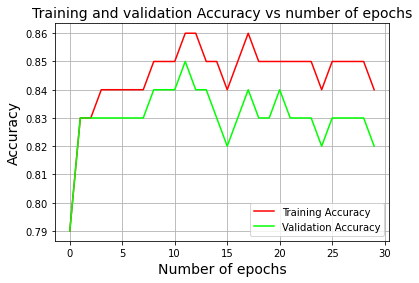

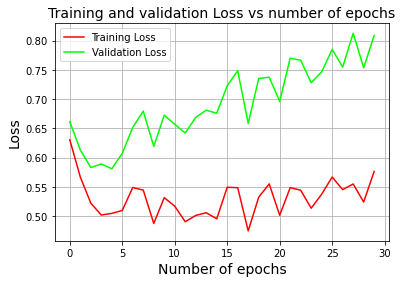

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: o8cs9t6l with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 30
wandb: 	lamb: 0
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.01 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:nadam 	 L2:0 	 epochs:30 	 num_hidden:1 	 num_neurons:64


wandb: Sweep Agent: Killed.


In [32]:
sweep_config = {
    "name":"CS6910 Assignment 1 - Cross Entropy Loss",
    "Metric":{
        "name":"Validation_accuracy",
        "goal":"maximize"
    },
    "method":"grid",
    "parameters":{
        "learning_rate":{
            "values":[0.01,0.001]
        },
        "activation_function":{
            "values":["ReLu"]
        },
        "loss":{
            "values":["cross_entropy"]
        },
        "init_mode":{
            "values":["Random_normal"]
        },
        "optimizer":{
            "values":["RMS","nadam","momentum"]
        },
        "Batch_size":{
        "values":[32,64]
        },
        "iterations":{
            "values":[30,40]
        },
        "lamb":{
            "values":[0,0.0005]
        },
        "num_neurons":{
            "values":[64,128,256]
        },
        "num_hidden":{
            "values":[1]
        }
    }
}

sweep_id = wandb.sweep(sweep_config,project="Question_1")
wandb.agent(sweep_id,Neural_Network,count=100)

Create sweep with ID: a98ja92c
Sweep URL: https://wandb.ai/dharanivendhanv01/Question_1/sweeps/a98ja92c


wandb: Agent Starting Run: kf2jil0r with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:128 	 optimizer:momentum 	 L2:0.05 	 epochs:25 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.82 	 cost_val: 1.02 	 train_acc: 0.20 	 val_acc: 0.20

iter:5 	 cost_train: 0.92 	 cost_val: 1.14 	 train_acc: 0.10 	 val_acc: 0.10

iter:10 	 cost_train: 0.93 	 cost_val: 1.13 	 train_acc: 0.10 	 val_acc: 0.11

iter:15 	 cost_train: 0.93 	 cost_val: 1.13 	 train_acc: 0.10 	 val_acc: 0.11

iter:20 	 cost_train: 0.93 	 cost_val: 1.12 	 train_acc: 0.10 	 val_acc: 0.11


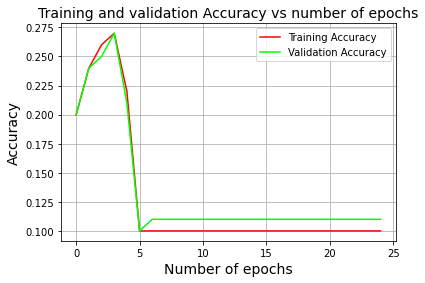

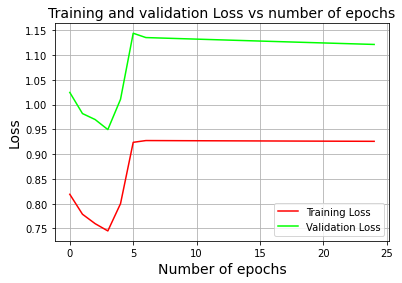

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 2k940w76 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 15
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:128 	 optimizer:adam 	 L2:0 	 epochs:15 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.50 	 cost_val: 0.50 	 train_acc: 0.20 	 val_acc: 0.21

iter:3 	 cost_train: 0.40 	 cost_val: 0.41 	 train_acc: 0.34 	 val_acc: 0.33

iter:6 	 cost_train: 0.35 	 cost_val: 0.35 	 train_acc: 0.46 	 val_acc: 0.46

iter:9 	 cost_train: 0.32 	 cost_val: 0.32 	 train_acc: 0.52 	 val_acc: 0.51

iter:12 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.58 	 val_acc: 0.57


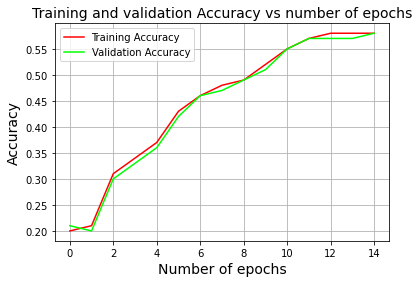

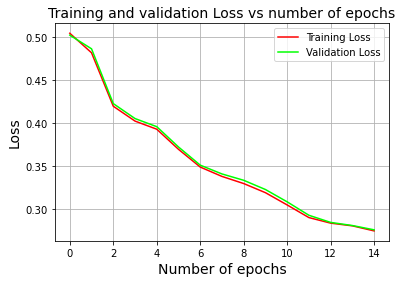

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: a5myzn2f with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:128 	 optimizer:nesterov 	 L2:0.0005 	 epochs:15 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.55 	 cost_val: 0.55 	 train_acc: 0.23 	 val_acc: 0.23

iter:3 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.32 	 val_acc: 0.30

iter:6 	 cost_train: 0.39 	 cost_val: 0.39 	 train_acc: 0.41 	 val_acc: 0.40

iter:9 	 cost_train: 0.36 	 cost_val: 0.37 	 train_acc: 0.39 	 val_acc: 0.37

iter:12 	 cost_train: 0.34 	 cost_val: 0.34 	 train_acc: 0.49 	 val_acc: 0.48


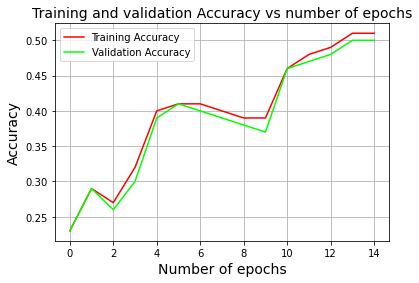

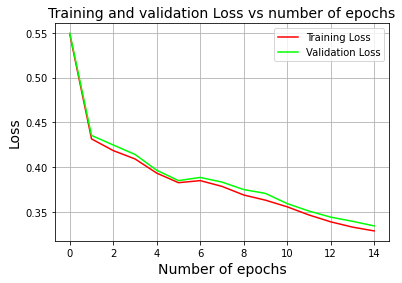

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: w3jzvaqk with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 25
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:RMS 	 L2:0.0005 	 epochs:25 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.85 	 cost_val: 0.85 	 train_acc: 0.12 	 val_acc: 0.12

iter:5 	 cost_train: 0.69 	 cost_val: 0.69 	 train_acc: 0.28 	 val_acc: 0.28

iter:10 	 cost_train: 0.65 	 cost_val: 0.65 	 train_acc: 0.32 	 val_acc: 0.32

iter:15 	 cost_train: 0.58 	 cost_val: 0.59 	 train_acc: 0.39 	 val_acc: 0.38

iter:20 	 cost_train: 0.52 	 cost_val: 0.53 	 train_acc: 0.45 	 val_acc: 0.44


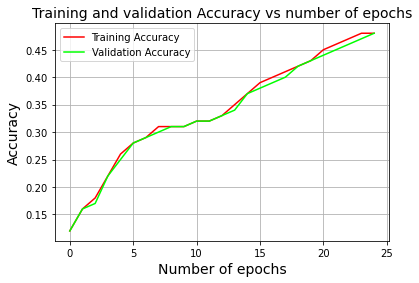

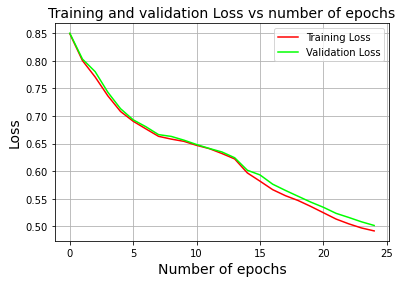

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 80n3jno3 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 20
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:128 	 optimizer:nadam 	 L2:0.05 	 epochs:20 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.43 	 cost_val: 0.66 	 train_acc: 0.35 	 val_acc: 0.34

iter:2 	 cost_train: 0.35 	 cost_val: 0.60 	 train_acc: 0.54 	 val_acc: 0.54

iter:4 	 cost_train: 0.29 	 cost_val: 0.56 	 train_acc: 0.63 	 val_acc: 0.62

iter:6 	 cost_train: 0.26 	 cost_val: 0.55 	 train_acc: 0.68 	 val_acc: 0.68

iter:8 	 cost_train: 0.25 	 cost_val: 0.56 	 train_acc: 0.70 	 val_acc: 0.70

iter:10 	 cost_train: 0.25 	 cost_val: 0.58 	 train_acc: 0.70 	 val_acc: 0.70

iter:12 	 cost_train: 0.25 	 cost_val: 0.61 	 train_acc: 0.70 	 val_acc: 0.70

iter:14 	 cost_train: 0.24 	 cost_val: 0.61 	 train_acc: 0.72 	 val_acc: 0.71

iter:16 	 cost_train: 0.24 	 cost_val: 0.62 	 train_acc: 0.72 	 val_acc: 0.71

iter:18 	 cost_train: 0.23 	 cost_val: 0.61 	 train_acc: 0.74 	 val_acc: 0.73


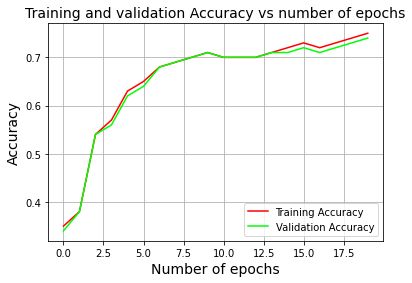

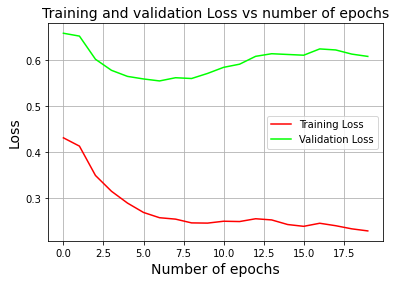

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ms8y0s2j with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:adam 	 L2:0 	 epochs:10 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.60 	 cost_val: 0.60 	 train_acc: 0.13 	 val_acc: 0.13

iter:1 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.27 	 val_acc: 0.26

iter:2 	 cost_train: 0.40 	 cost_val: 0.40 	 train_acc: 0.37 	 val_acc: 0.37

iter:3 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.42 	 val_acc: 0.41

iter:4 	 cost_train: 0.35 	 cost_val: 0.35 	 train_acc: 0.45 	 val_acc: 0.44

iter:5 	 cost_train: 0.33 	 cost_val: 0.34 	 train_acc: 0.49 	 val_acc: 0.49

iter:6 	 cost_train: 0.32 	 cost_val: 0.32 	 train_acc: 0.53 	 val_acc: 0.52

iter:7 	 cost_train: 0.31 	 cost_val: 0.31 	 train_acc: 0.56 	 val_acc: 0.55

iter:8 	 cost_train: 0.29 	 cost_val: 0.30 	 train_acc: 0.58 	 val_acc: 0.57

iter:9 	 cost_train: 0.29 	 cost_val: 0.29 	 train_acc: 0.59 	 val_acc: 0.58


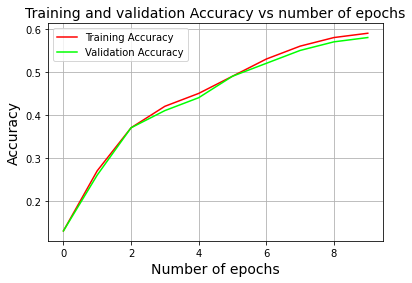

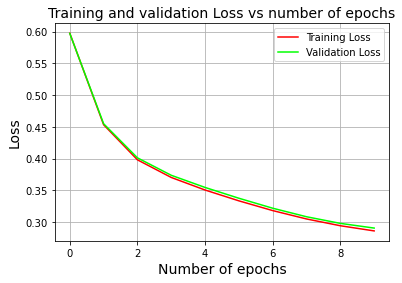

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 6het433h with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:adam 	 L2:0.05 	 epochs:25 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.61 	 cost_val: 0.66 	 train_acc: 0.38 	 val_acc: 0.38

iter:5 	 cost_train: 0.15 	 cost_val: 0.15 	 train_acc: 0.79 	 val_acc: 0.79

iter:10 	 cost_train: 0.16 	 cost_val: 0.16 	 train_acc: 0.77 	 val_acc: 0.77

iter:15 	 cost_train: 0.17 	 cost_val: 0.17 	 train_acc: 0.76 	 val_acc: 0.76

iter:20 	 cost_train: 0.14 	 cost_val: 0.15 	 train_acc: 0.80 	 val_acc: 0.80


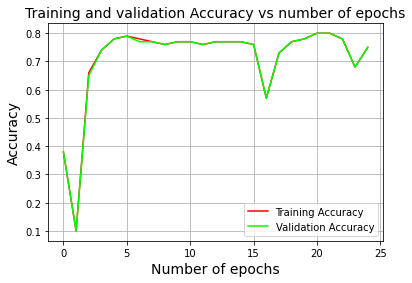

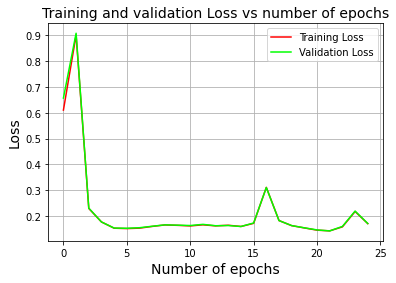

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: jmf03yni with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:15 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.75 	 cost_val: 0.75 	 train_acc: 0.07 	 val_acc: 0.07

iter:3 	 cost_train: 0.73 	 cost_val: 0.73 	 train_acc: 0.08 	 val_acc: 0.08

iter:6 	 cost_train: 0.71 	 cost_val: 0.71 	 train_acc: 0.08 	 val_acc: 0.09

iter:9 	 cost_train: 0.69 	 cost_val: 0.69 	 train_acc: 0.09 	 val_acc: 0.09

iter:12 	 cost_train: 0.68 	 cost_val: 0.68 	 train_acc: 0.09 	 val_acc: 0.09


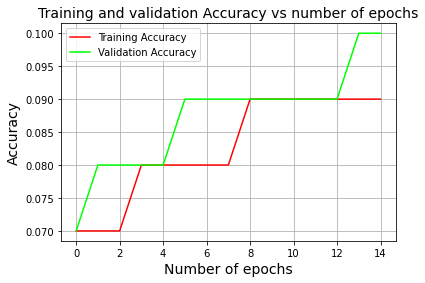

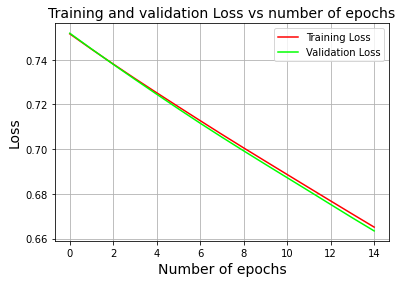

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: bzd03j0u with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:nesterov 	 L2:0 	 epochs:5 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.88 	 cost_val: 0.87 	 train_acc: 0.10 	 val_acc: 0.10

iter:1 	 cost_train: 0.85 	 cost_val: 0.85 	 train_acc: 0.10 	 val_acc: 0.10

iter:2 	 cost_train: 0.79 	 cost_val: 0.79 	 train_acc: 0.11 	 val_acc: 0.11

iter:3 	 cost_train: 0.72 	 cost_val: 0.73 	 train_acc: 0.12 	 val_acc: 0.11

iter:4 	 cost_train: 0.66 	 cost_val: 0.66 	 train_acc: 0.13 	 val_acc: 0.12


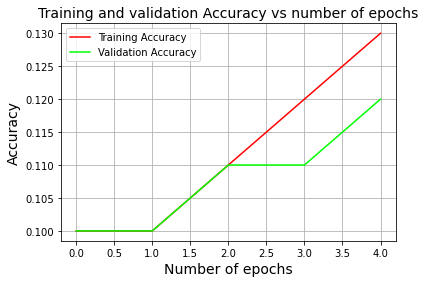

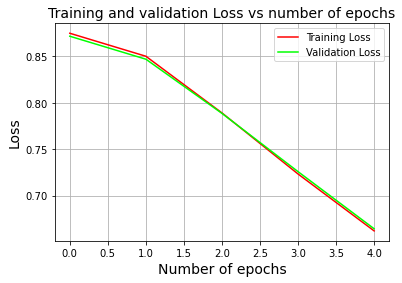

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: i62j04g1 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:64 	 optimizer:nesterov 	 L2:0 	 epochs:10 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.76 	 cost_val: 0.77 	 train_acc: 0.22 	 val_acc: 0.22

iter:1 	 cost_train: 0.72 	 cost_val: 0.72 	 train_acc: 0.26 	 val_acc: 0.26

iter:2 	 cost_train: 0.70 	 cost_val: 0.71 	 train_acc: 0.28 	 val_acc: 0.27

iter:3 	 cost_train: 0.62 	 cost_val: 0.63 	 train_acc: 0.37 	 val_acc: 0.36

iter:4 	 cost_train: 0.57 	 cost_val: 0.59 	 train_acc: 0.41 	 val_acc: 0.40

iter:5 	 cost_train: 0.53 	 cost_val: 0.53 	 train_acc: 0.45 	 val_acc: 0.46

iter:6 	 cost_train: 0.60 	 cost_val: 0.61 	 train_acc: 0.39 	 val_acc: 0.38

iter:7 	 cost_train: 0.65 	 cost_val: 0.65 	 train_acc: 0.34 	 val_acc: 0.34

iter:8 	 cost_train: 0.78 	 cost_val: 0.78 	 train_acc: 0.22 	 val_acc: 0.22

iter:9 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10


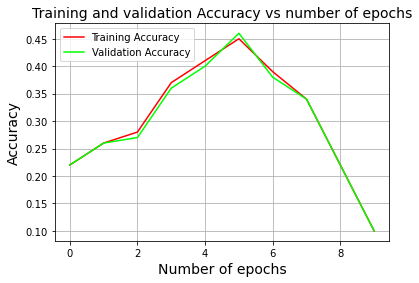

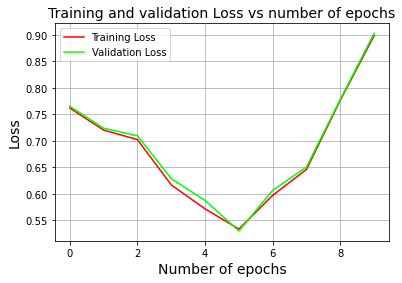

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 30ncmtd5 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:RMS 	 L2:0.05 	 epochs:10 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.81 	 cost_val: 1.12 	 train_acc: 0.21 	 val_acc: 0.20

iter:1 	 cost_train: 0.69 	 cost_val: 0.95 	 train_acc: 0.32 	 val_acc: 0.31

iter:2 	 cost_train: 0.63 	 cost_val: 0.85 	 train_acc: 0.37 	 val_acc: 0.36

iter:3 	 cost_train: 0.53 	 cost_val: 0.71 	 train_acc: 0.47 	 val_acc: 0.46

iter:4 	 cost_train: 0.46 	 cost_val: 0.61 	 train_acc: 0.53 	 val_acc: 0.52

iter:5 	 cost_train: 0.42 	 cost_val: 0.55 	 train_acc: 0.57 	 val_acc: 0.56

iter:6 	 cost_train: 0.40 	 cost_val: 0.51 	 train_acc: 0.59 	 val_acc: 0.58

iter:7 	 cost_train: 0.38 	 cost_val: 0.47 	 train_acc: 0.61 	 val_acc: 0.61

iter:8 	 cost_train: 0.35 	 cost_val: 0.44 	 train_acc: 0.63 	 val_acc: 0.63

iter:9 	 cost_train: 0.34 	 cost_val: 0.43 	 train_acc: 0.64 	 val_acc: 0.64


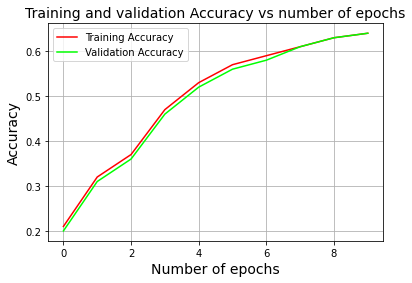

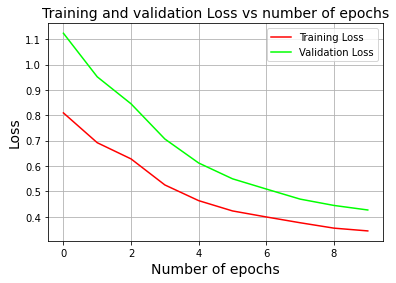

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 5p6md9mt with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:64 	 optimizer:stochastic 	 L2:0.0005 	 epochs:5 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.75 	 cost_val: 0.75 	 train_acc: 0.16 	 val_acc: 0.16

iter:1 	 cost_train: 0.71 	 cost_val: 0.71 	 train_acc: 0.16 	 val_acc: 0.17

iter:2 	 cost_train: 0.56 	 cost_val: 0.57 	 train_acc: 0.24 	 val_acc: 0.24

iter:3 	 cost_train: 0.46 	 cost_val: 0.46 	 train_acc: 0.23 	 val_acc: 0.23

iter:4 	 cost_train: 0.46 	 cost_val: 0.47 	 train_acc: 0.20 	 val_acc: 0.20


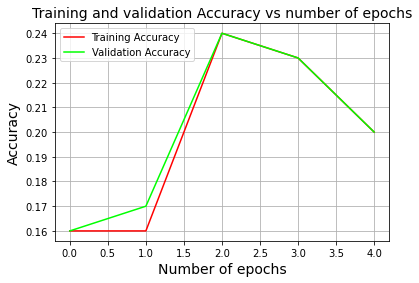

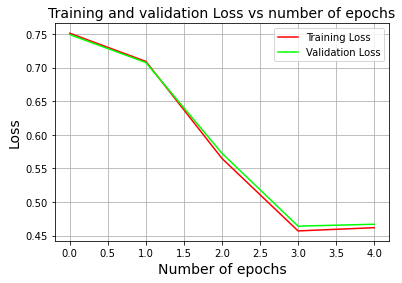

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 36qf2u47 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 15
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:stochastic 	 L2:0 	 epochs:15 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.14 	 val_acc: 0.14

iter:3 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.15 	 val_acc: 0.15

iter:6 	 cost_train: 0.71 	 cost_val: 0.72 	 train_acc: 0.15 	 val_acc: 0.14

iter:9 	 cost_train: 0.66 	 cost_val: 0.68 	 train_acc: 0.17 	 val_acc: 0.16

iter:12 	 cost_train: 0.64 	 cost_val: 0.64 	 train_acc: 0.18 	 val_acc: 0.18


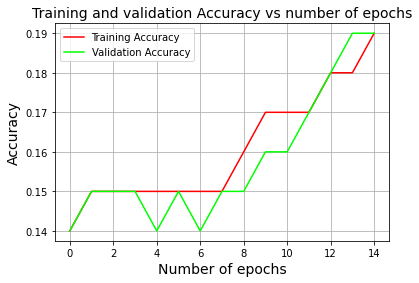

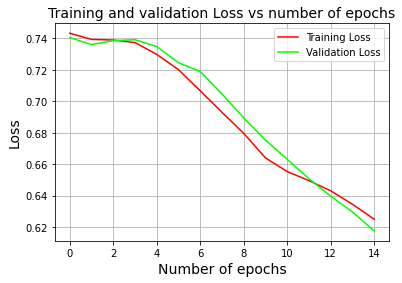

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: nskyymwt with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:32 	 optimizer:adam 	 L2:0.05 	 epochs:10 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.29 	 cost_val: 0.43 	 train_acc: 0.61 	 val_acc: 0.60

iter:1 	 cost_train: 0.18 	 cost_val: 0.22 	 train_acc: 0.75 	 val_acc: 0.75

iter:2 	 cost_train: 0.15 	 cost_val: 0.16 	 train_acc: 0.79 	 val_acc: 0.79

iter:3 	 cost_train: 0.16 	 cost_val: 0.16 	 train_acc: 0.77 	 val_acc: 0.78

iter:4 	 cost_train: 0.21 	 cost_val: 0.23 	 train_acc: 0.72 	 val_acc: 0.72

iter:5 	 cost_train: 0.33 	 cost_val: 0.58 	 train_acc: 0.54 	 val_acc: 0.54

iter:6 	 cost_train: 0.36 	 cost_val: 0.59 	 train_acc: 0.45 	 val_acc: 0.45

iter:7 	 cost_train: 0.38 	 cost_val: 0.54 	 train_acc: 0.35 	 val_acc: 0.35

iter:8 	 cost_train: 0.38 	 cost_val: 0.48 	 train_acc: 0.29 	 val_acc: 0.28

iter:9 	 cost_train: 0.39 	 cost_val: 0.57 	 train_acc: 0.36 	 val_acc: 0.36


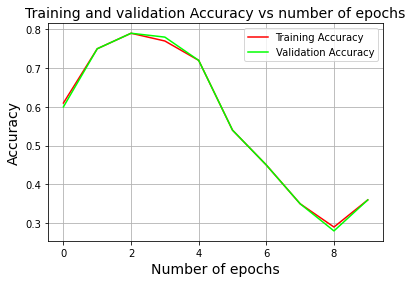

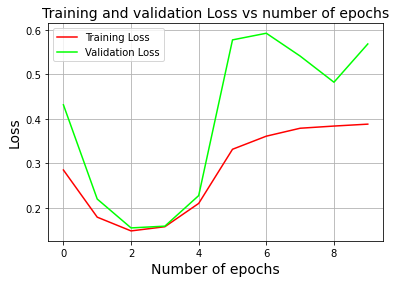

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lqtnfrcs with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:stochastic 	 L2:0.05 	 epochs:10 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.81 	 cost_val: 1.19 	 train_acc: 0.11 	 val_acc: 0.11

iter:1 	 cost_train: 0.80 	 cost_val: 1.18 	 train_acc: 0.12 	 val_acc: 0.12

iter:2 	 cost_train: 0.79 	 cost_val: 1.17 	 train_acc: 0.12 	 val_acc: 0.12

iter:3 	 cost_train: 0.78 	 cost_val: 1.16 	 train_acc: 0.12 	 val_acc: 0.12

iter:4 	 cost_train: 0.77 	 cost_val: 1.15 	 train_acc: 0.13 	 val_acc: 0.13

iter:5 	 cost_train: 0.76 	 cost_val: 1.14 	 train_acc: 0.13 	 val_acc: 0.13

iter:6 	 cost_train: 0.76 	 cost_val: 1.13 	 train_acc: 0.13 	 val_acc: 0.13

iter:7 	 cost_train: 0.75 	 cost_val: 1.12 	 train_acc: 0.13 	 val_acc: 0.13

iter:8 	 cost_train: 0.74 	 cost_val: 1.12 	 train_acc: 0.14 	 val_acc: 0.13

iter:9 	 cost_train: 0.73 	 cost_val: 1.11 	 train_acc: 0.14 	 val_acc: 0.14


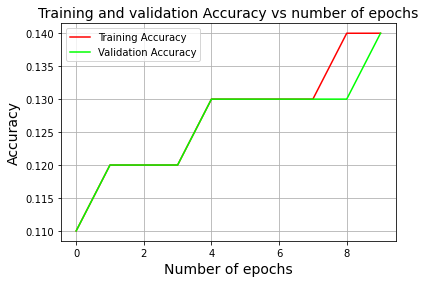

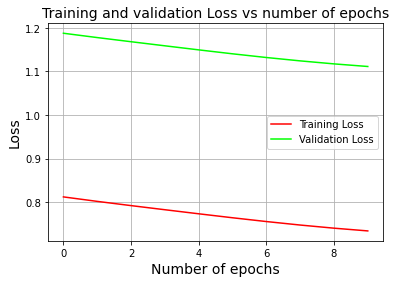

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: efmhjsym with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 5
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:128 	 optimizer:momentum 	 L2:0.0005 	 epochs:5 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.63 	 cost_val: 0.64 	 train_acc: 0.14 	 val_acc: 0.13

iter:1 	 cost_train: 0.48 	 cost_val: 0.49 	 train_acc: 0.12 	 val_acc: 0.12

iter:2 	 cost_train: 0.46 	 cost_val: 0.46 	 train_acc: 0.09 	 val_acc: 0.09

iter:3 	 cost_train: 0.46 	 cost_val: 0.46 	 train_acc: 0.06 	 val_acc: 0.05

iter:4 	 cost_train: 0.46 	 cost_val: 0.46 	 train_acc: 0.15 	 val_acc: 0.15


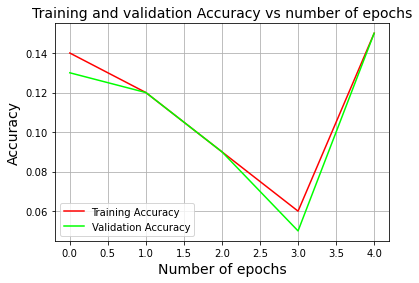

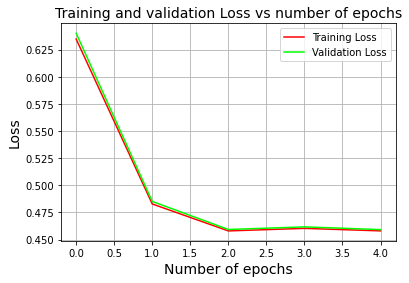

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: n1w9h2op with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 25
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:64 	 optimizer:nesterov 	 L2:0.0005 	 epochs:25 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.53 	 cost_val: 0.53 	 train_acc: 0.23 	 val_acc: 0.24

iter:5 	 cost_train: 0.31 	 cost_val: 0.32 	 train_acc: 0.51 	 val_acc: 0.51

iter:10 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.59 	 val_acc: 0.59

iter:15 	 cost_train: 0.26 	 cost_val: 0.27 	 train_acc: 0.61 	 val_acc: 0.59

iter:20 	 cost_train: 0.26 	 cost_val: 0.26 	 train_acc: 0.61 	 val_acc: 0.60


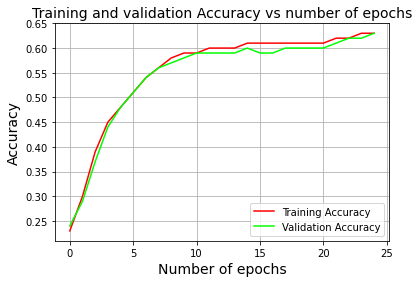

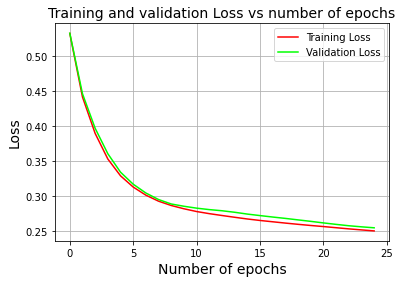

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yz4a4xig with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:nadam 	 L2:0 	 epochs:10 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.29 	 val_acc: 0.29

iter:1 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.40 	 val_acc: 0.40

iter:2 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.48 	 val_acc: 0.47

iter:3 	 cost_train: 0.31 	 cost_val: 0.31 	 train_acc: 0.53 	 val_acc: 0.52

iter:4 	 cost_train: 0.29 	 cost_val: 0.29 	 train_acc: 0.57 	 val_acc: 0.57

iter:5 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.58 	 val_acc: 0.58

iter:6 	 cost_train: 0.27 	 cost_val: 0.28 	 train_acc: 0.57 	 val_acc: 0.56

iter:7 	 cost_train: 0.25 	 cost_val: 0.26 	 train_acc: 0.61 	 val_acc: 0.60

iter:8 	 cost_train: 0.24 	 cost_val: 0.24 	 train_acc: 0.63 	 val_acc: 0.63

iter:9 	 cost_train: 0.23 	 cost_val: 0.23 	 train_acc: 0.65 	 val_acc: 0.65


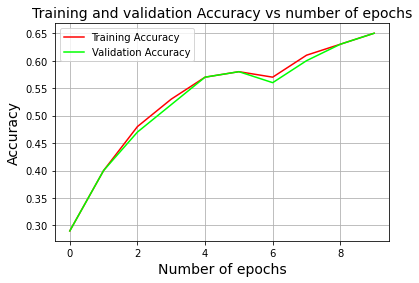

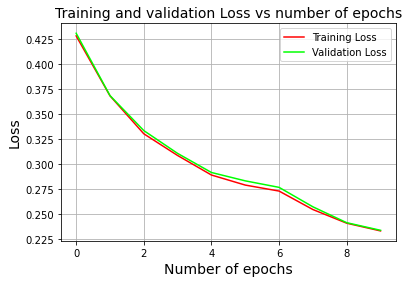

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: oe0x1bdc with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:nadam 	 L2:0 	 epochs:5 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.29 	 val_acc: 0.29

iter:1 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.40 	 val_acc: 0.40

iter:2 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.48 	 val_acc: 0.47

iter:3 	 cost_train: 0.31 	 cost_val: 0.31 	 train_acc: 0.53 	 val_acc: 0.52

iter:4 	 cost_train: 0.29 	 cost_val: 0.29 	 train_acc: 0.57 	 val_acc: 0.57


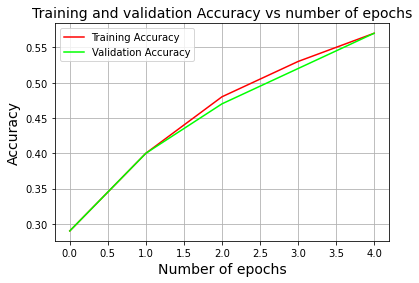

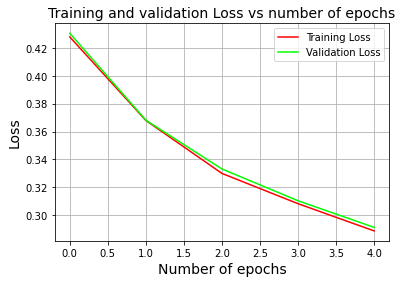

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 9f16ve1m with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:128 	 optimizer:adam 	 L2:0 	 epochs:5 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.67 	 cost_val: 0.67 	 train_acc: 0.33 	 val_acc: 0.33

iter:1 	 cost_train: 0.62 	 cost_val: 0.62 	 train_acc: 0.38 	 val_acc: 0.38

iter:2 	 cost_train: 0.55 	 cost_val: 0.57 	 train_acc: 0.44 	 val_acc: 0.43

iter:3 	 cost_train: 0.60 	 cost_val: 0.61 	 train_acc: 0.40 	 val_acc: 0.39

iter:4 	 cost_train: 0.53 	 cost_val: 0.54 	 train_acc: 0.47 	 val_acc: 0.46


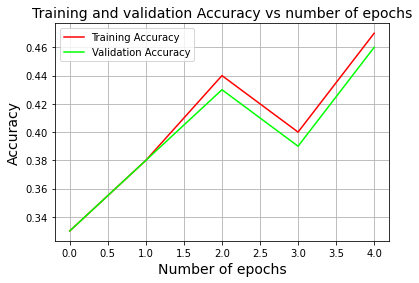

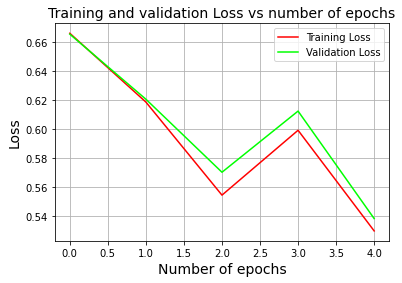

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 2em756bi with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:64 	 optimizer:stochastic 	 L2:0.0005 	 epochs:10 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.71 	 cost_val: 0.72 	 train_acc: 0.09 	 val_acc: 0.09

iter:1 	 cost_train: 0.59 	 cost_val: 0.59 	 train_acc: 0.16 	 val_acc: 0.15

iter:2 	 cost_train: 0.55 	 cost_val: 0.55 	 train_acc: 0.16 	 val_acc: 0.16

iter:3 	 cost_train: 0.53 	 cost_val: 0.53 	 train_acc: 0.15 	 val_acc: 0.15

iter:4 	 cost_train: 0.50 	 cost_val: 0.51 	 train_acc: 0.17 	 val_acc: 0.17

iter:5 	 cost_train: 0.49 	 cost_val: 0.49 	 train_acc: 0.19 	 val_acc: 0.19

iter:6 	 cost_train: 0.48 	 cost_val: 0.49 	 train_acc: 0.19 	 val_acc: 0.19

iter:7 	 cost_train: 0.48 	 cost_val: 0.48 	 train_acc: 0.18 	 val_acc: 0.18

iter:8 	 cost_train: 0.48 	 cost_val: 0.48 	 train_acc: 0.18 	 val_acc: 0.19

iter:9 	 cost_train: 0.47 	 cost_val: 0.48 	 train_acc: 0.18 	 val_acc: 0.19


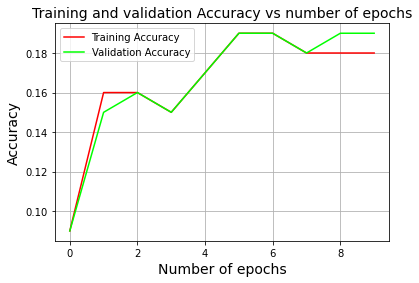

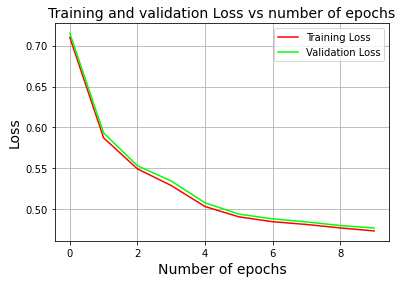

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 48djt6y7 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:128 	 optimizer:stochastic 	 L2:0 	 epochs:10 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.73 	 cost_val: 0.73 	 train_acc: 0.13 	 val_acc: 0.13

iter:1 	 cost_train: 0.72 	 cost_val: 0.72 	 train_acc: 0.13 	 val_acc: 0.13

iter:2 	 cost_train: 0.72 	 cost_val: 0.72 	 train_acc: 0.13 	 val_acc: 0.13

iter:3 	 cost_train: 0.71 	 cost_val: 0.71 	 train_acc: 0.13 	 val_acc: 0.13

iter:4 	 cost_train: 0.71 	 cost_val: 0.71 	 train_acc: 0.13 	 val_acc: 0.13

iter:5 	 cost_train: 0.71 	 cost_val: 0.70 	 train_acc: 0.13 	 val_acc: 0.13

iter:6 	 cost_train: 0.70 	 cost_val: 0.70 	 train_acc: 0.13 	 val_acc: 0.13

iter:7 	 cost_train: 0.70 	 cost_val: 0.70 	 train_acc: 0.13 	 val_acc: 0.13

iter:8 	 cost_train: 0.70 	 cost_val: 0.70 	 train_acc: 0.13 	 val_acc: 0.13

iter:9 	 cost_train: 0.70 	 cost_val: 0.69 	 train_acc: 0.13 	 val_acc: 0.13


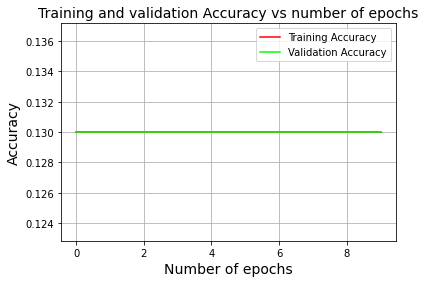

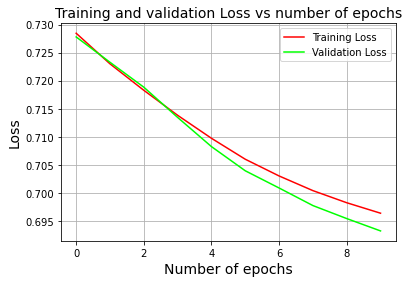

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lxoqdpfb with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:64 	 optimizer:nadam 	 L2:0 	 epochs:10 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.55 	 cost_val: 0.56 	 train_acc: 0.42 	 val_acc: 0.41

iter:1 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.57 	 val_acc: 0.56

iter:2 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.62 	 val_acc: 0.62

iter:3 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.66 	 val_acc: 0.66

iter:4 	 cost_train: 0.34 	 cost_val: 0.34 	 train_acc: 0.64 	 val_acc: 0.65

iter:5 	 cost_train: 0.31 	 cost_val: 0.31 	 train_acc: 0.68 	 val_acc: 0.68

iter:6 	 cost_train: 0.33 	 cost_val: 0.32 	 train_acc: 0.66 	 val_acc: 0.67

iter:7 	 cost_train: 0.29 	 cost_val: 0.29 	 train_acc: 0.70 	 val_acc: 0.70

iter:8 	 cost_train: 0.27 	 cost_val: 0.28 	 train_acc: 0.72 	 val_acc: 0.71

iter:9 	 cost_train: 0.34 	 cost_val: 0.35 	 train_acc: 0.65 	 val_acc: 0.64


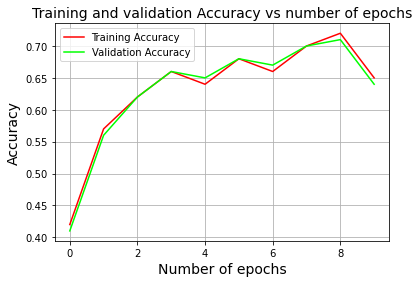

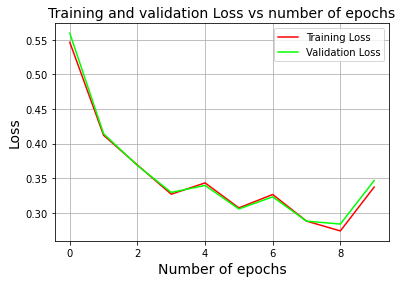

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8uazfqvv with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 15
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:64 	 optimizer:adam 	 L2:0.0005 	 epochs:15 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.79 	 cost_val: 0.79 	 train_acc: 0.21 	 val_acc: 0.21

iter:3 	 cost_train: 0.72 	 cost_val: 0.73 	 train_acc: 0.27 	 val_acc: 0.27

iter:6 	 cost_train: 0.68 	 cost_val: 0.68 	 train_acc: 0.32 	 val_acc: 0.32

iter:9 	 cost_train: 0.64 	 cost_val: 0.64 	 train_acc: 0.35 	 val_acc: 0.35

iter:12 	 cost_train: 0.59 	 cost_val: 0.60 	 train_acc: 0.41 	 val_acc: 0.40


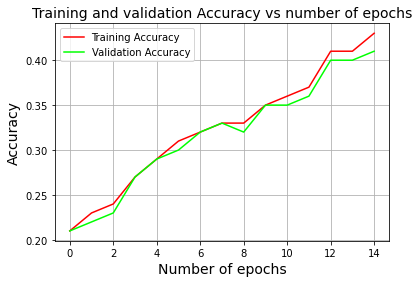

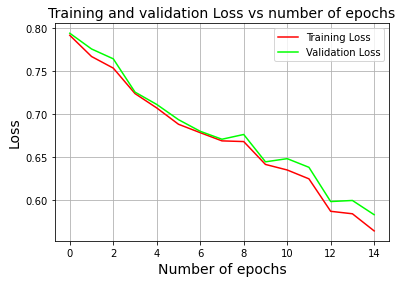

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: m5brtrlw with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 20
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:RMS 	 L2:0 	 epochs:20 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.36 	 cost_val: 0.37 	 train_acc: 0.42 	 val_acc: 0.42


C:\Users\Dharani\AppData\Local\Temp\ipykernel_18680\1310270419.py:4: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-x)



iter:2 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.18 	 val_acc: 0.19

iter:4 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.14 	 val_acc: 0.15

iter:6 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.14 	 val_acc: 0.14

iter:8 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.14 	 val_acc: 0.15

iter:10 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.16 	 val_acc: 0.16

iter:12 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.17 	 val_acc: 0.17

iter:14 	 cost_train: 0.42 	 cost_val: 0.43 	 train_acc: 0.17 	 val_acc: 0.17

iter:16 	 cost_train: 0.42 	 cost_val: 0.43 	 train_acc: 0.17 	 val_acc: 0.18

iter:18 	 cost_train: 0.42 	 cost_val: 0.43 	 train_acc: 0.18 	 val_acc: 0.18


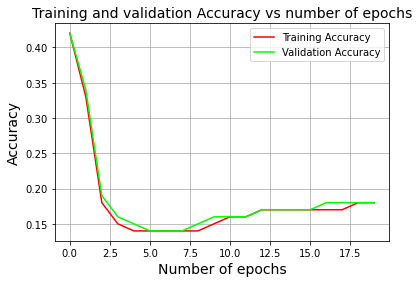

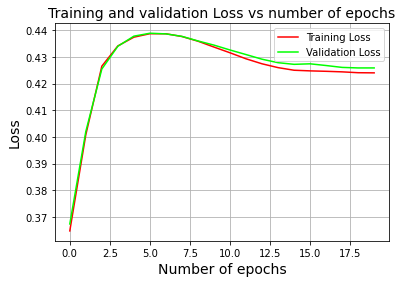

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3wf0254c with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 30
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:64 	 optimizer:RMS 	 L2:0.05 	 epochs:30 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.35 	 cost_val: 0.42 	 train_acc: 0.46 	 val_acc: 0.46

iter:3 	 cost_train: 0.46 	 cost_val: 0.72 	 train_acc: 0.22 	 val_acc: 0.21

iter:6 	 cost_train: 0.51 	 cost_val: 1.19 	 train_acc: 0.19 	 val_acc: 0.19

iter:9 	 cost_train: 0.55 	 cost_val: 1.58 	 train_acc: 0.19 	 val_acc: 0.20

iter:12 	 cost_train: 0.61 	 cost_val: 2.14 	 train_acc: 0.20 	 val_acc: 0.20

iter:15 	 cost_train: 0.67 	 cost_val: 2.71 	 train_acc: 0.19 	 val_acc: 0.20

iter:18 	 cost_train: 0.70 	 cost_val: 2.98 	 train_acc: 0.19 	 val_acc: 0.20

iter:21 	 cost_train: 0.71 	 cost_val: 3.10 	 train_acc: 0.19 	 val_acc: 0.20

iter:24 	 cost_train: 0.72 	 cost_val: 3.18 	 train_acc: 0.19 	 val_acc: 0.20

iter:27 	 cost_train: 0.73 	 cost_val: 3.24 	 train_acc: 0.19 	 val_acc: 0.20


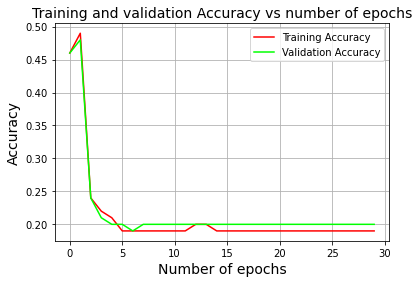

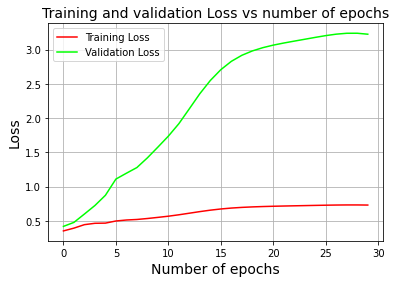

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: aknt8vfl with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 30
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:stochastic 	 L2:0.0005 	 epochs:30 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.57 	 cost_val: 0.57 	 train_acc: 0.12 	 val_acc: 0.11

iter:3 	 cost_train: 0.48 	 cost_val: 0.48 	 train_acc: 0.15 	 val_acc: 0.15

iter:6 	 cost_train: 0.46 	 cost_val: 0.46 	 train_acc: 0.16 	 val_acc: 0.16

iter:9 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.18 	 val_acc: 0.19

iter:12 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.18 	 val_acc: 0.18

iter:15 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.18 	 val_acc: 0.19

iter:18 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.19 	 val_acc: 0.19

iter:21 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.20 	 val_acc: 0.20

iter:24 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.22 	 val_acc: 0.23

iter:27 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.25 	 val_acc: 0.27


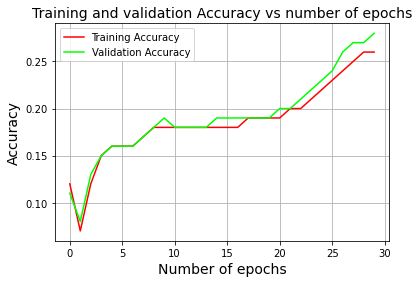

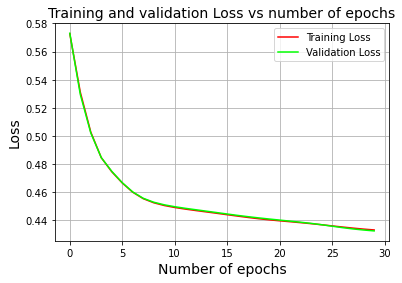

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: mw8t4b26 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 20
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:128 	 optimizer:nesterov 	 L2:0.0005 	 epochs:20 	 num_hidden:1 	 num_neurons:64

iter:0 	 cost_train: 0.82 	 cost_val: 0.83 	 train_acc: 0.15 	 val_acc: 0.15

iter:2 	 cost_train: 0.73 	 cost_val: 0.74 	 train_acc: 0.24 	 val_acc: 0.23

iter:4 	 cost_train: 0.63 	 cost_val: 0.63 	 train_acc: 0.35 	 val_acc: 0.34

iter:6 	 cost_train: 0.56 	 cost_val: 0.57 	 train_acc: 0.42 	 val_acc: 0.41

iter:8 	 cost_train: 0.56 	 cost_val: 0.56 	 train_acc: 0.42 	 val_acc: 0.42

iter:10 	 cost_train: 0.60 	 cost_val: 0.61 	 train_acc: 0.38 	 val_acc: 0.37

iter:12 	 cost_train: 0.66 	 cost_val: 0.67 	 train_acc: 0.32 	 val_acc: 0.32

iter:14 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.11

iter:16 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.11

iter:18 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.11


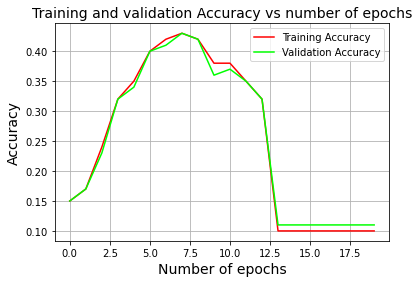

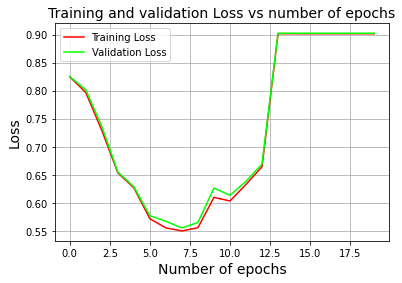

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: doqzwmmj with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 25
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:RMS 	 L2:0.0005 	 epochs:25 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.39 	 cost_val: 0.39 	 train_acc: 0.43 	 val_acc: 0.43

iter:5 	 cost_train: 0.21 	 cost_val: 0.22 	 train_acc: 0.69 	 val_acc: 0.68

iter:10 	 cost_train: 0.22 	 cost_val: 0.23 	 train_acc: 0.68 	 val_acc: 0.68

iter:15 	 cost_train: 0.19 	 cost_val: 0.20 	 train_acc: 0.73 	 val_acc: 0.72

iter:20 	 cost_train: 0.19 	 cost_val: 0.20 	 train_acc: 0.74 	 val_acc: 0.73


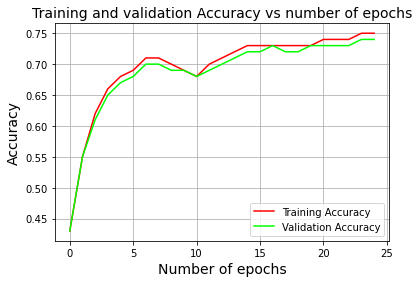

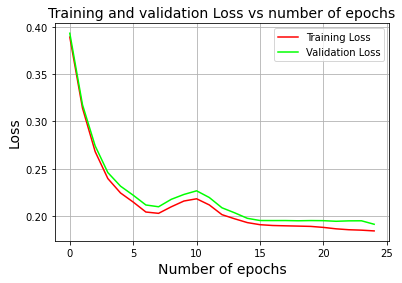

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: vdnqe2zt with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:adam 	 L2:0 	 epochs:5 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.46 	 val_acc: 0.46

iter:1 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.43 	 val_acc: 0.43

iter:2 	 cost_train: 0.40 	 cost_val: 0.40 	 train_acc: 0.35 	 val_acc: 0.34

iter:3 	 cost_train: 0.41 	 cost_val: 0.42 	 train_acc: 0.28 	 val_acc: 0.28

iter:4 	 cost_train: 0.42 	 cost_val: 0.42 	 train_acc: 0.34 	 val_acc: 0.35


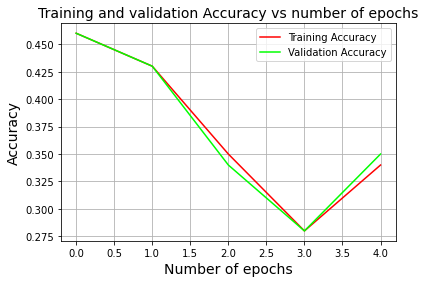

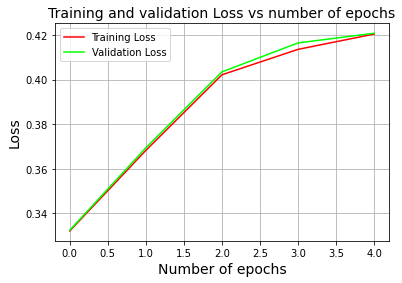

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yh4ho7vd with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:momentum 	 L2:0.05 	 epochs:5 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.50 	 cost_val: 0.99 	 train_acc: 0.24 	 val_acc: 0.24

iter:1 	 cost_train: 0.41 	 cost_val: 0.90 	 train_acc: 0.46 	 val_acc: 0.46

iter:2 	 cost_train: 0.42 	 cost_val: 0.89 	 train_acc: 0.41 	 val_acc: 0.42

iter:3 	 cost_train: 0.40 	 cost_val: 0.87 	 train_acc: 0.44 	 val_acc: 0.44

iter:4 	 cost_train: 0.41 	 cost_val: 0.89 	 train_acc: 0.42 	 val_acc: 0.41


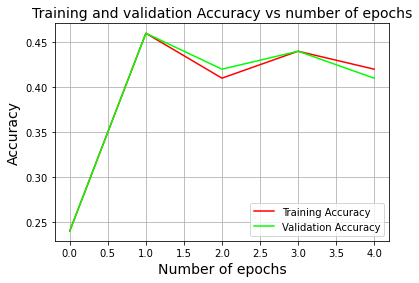

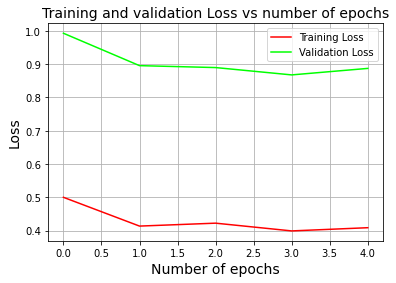

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 7zxddms7 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:RMS 	 L2:0.0005 	 epochs:20 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.52 	 cost_val: 0.53 	 train_acc: 0.26 	 val_acc: 0.25

iter:2 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.53 	 val_acc: 0.53

iter:4 	 cost_train: 0.27 	 cost_val: 0.27 	 train_acc: 0.62 	 val_acc: 0.62

iter:6 	 cost_train: 0.23 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.66

iter:8 	 cost_train: 0.21 	 cost_val: 0.22 	 train_acc: 0.69 	 val_acc: 0.68

iter:10 	 cost_train: 0.20 	 cost_val: 0.21 	 train_acc: 0.71 	 val_acc: 0.71

iter:12 	 cost_train: 0.20 	 cost_val: 0.21 	 train_acc: 0.71 	 val_acc: 0.71

iter:14 	 cost_train: 0.21 	 cost_val: 0.22 	 train_acc: 0.70 	 val_acc: 0.70

iter:16 	 cost_train: 0.22 	 cost_val: 0.23 	 train_acc: 0.68 	 val_acc: 0.67

iter:18 	 cost_train: 0.21 	 cost_val: 0.22 	 train_acc: 0.69 	 val_acc: 0.69


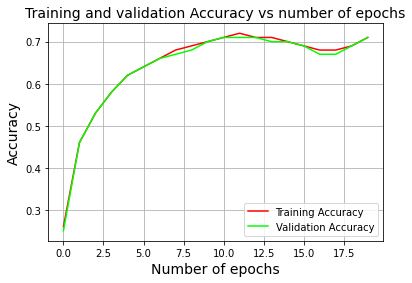

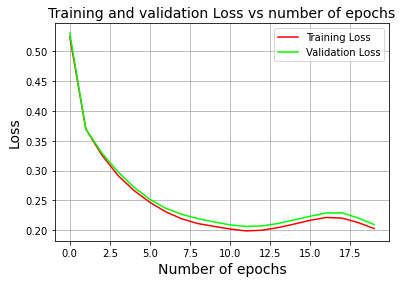

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: t33ahlvx with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:momentum 	 L2:0 	 epochs:20 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.91 	 cost_val: 0.92 	 train_acc: 0.09 	 val_acc: 0.08

iter:2 	 cost_train: 0.89 	 cost_val: 0.89 	 train_acc: 0.11 	 val_acc: 0.11

iter:4 	 cost_train: 0.85 	 cost_val: 0.86 	 train_acc: 0.14 	 val_acc: 0.14

iter:6 	 cost_train: 0.82 	 cost_val: 0.83 	 train_acc: 0.17 	 val_acc: 0.17

iter:8 	 cost_train: 0.81 	 cost_val: 0.82 	 train_acc: 0.18 	 val_acc: 0.17

iter:10 	 cost_train: 0.81 	 cost_val: 0.82 	 train_acc: 0.19 	 val_acc: 0.18

iter:12 	 cost_train: 0.79 	 cost_val: 0.79 	 train_acc: 0.20 	 val_acc: 0.20

iter:14 	 cost_train: 0.80 	 cost_val: 0.81 	 train_acc: 0.20 	 val_acc: 0.19

iter:16 	 cost_train: 0.80 	 cost_val: 0.81 	 train_acc: 0.20 	 val_acc: 0.19

iter:18 	 cost_train: 0.81 	 cost_val: 0.81 	 train_acc: 0.19 	 val_acc: 0.19


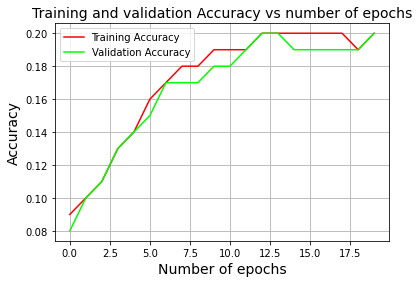

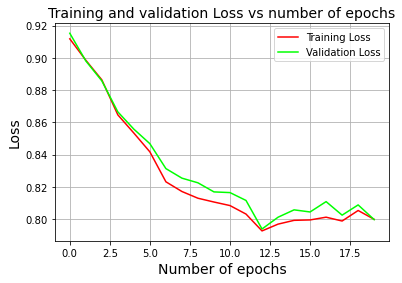

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 5k6fts12 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:64 	 optimizer:adam 	 L2:0 	 epochs:10 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.71 	 cost_val: 0.72 	 train_acc: 0.14 	 val_acc: 0.14

iter:1 	 cost_train: 0.51 	 cost_val: 0.51 	 train_acc: 0.18 	 val_acc: 0.18

iter:2 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.18 	 val_acc: 0.18

iter:3 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.16 	 val_acc: 0.16

iter:4 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.18 	 val_acc: 0.17

iter:5 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.16 	 val_acc: 0.16

iter:6 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.15 	 val_acc: 0.15

iter:7 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.20 	 val_acc: 0.19

iter:8 	 cost_train: 0.42 	 cost_val: 0.42 	 train_acc: 0.21 	 val_acc: 0.20

iter:9 	 cost_train: 0.42 	 cost_val: 0.42 	 train_acc: 0.21 	 val_acc: 0.20


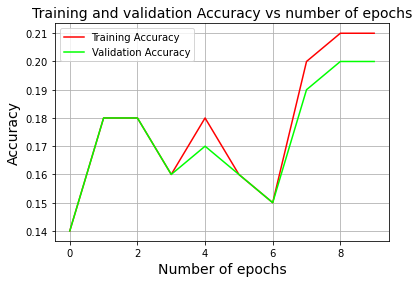

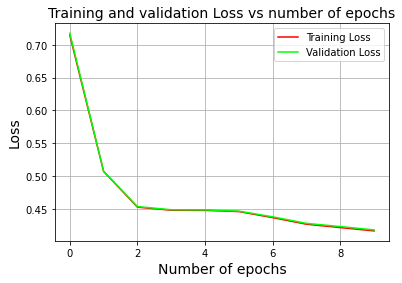

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ugimrv9c with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 30
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:nesterov 	 L2:0 	 epochs:30 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.72 	 cost_val: 0.72 	 train_acc: 0.11 	 val_acc: 0.12

iter:3 	 cost_train: 0.56 	 cost_val: 0.56 	 train_acc: 0.21 	 val_acc: 0.21

iter:6 	 cost_train: 0.48 	 cost_val: 0.48 	 train_acc: 0.28 	 val_acc: 0.28

iter:9 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.31 	 val_acc: 0.30

iter:12 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.36 	 val_acc: 0.34

iter:15 	 cost_train: 0.38 	 cost_val: 0.39 	 train_acc: 0.40 	 val_acc: 0.39

iter:18 	 cost_train: 0.36 	 cost_val: 0.36 	 train_acc: 0.44 	 val_acc: 0.43

iter:21 	 cost_train: 0.34 	 cost_val: 0.35 	 train_acc: 0.47 	 val_acc: 0.46

iter:24 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.49 	 val_acc: 0.48

iter:27 	 cost_train: 0.32 	 cost_val: 0.32 	 train_acc: 0.50 	 val_acc: 0.50


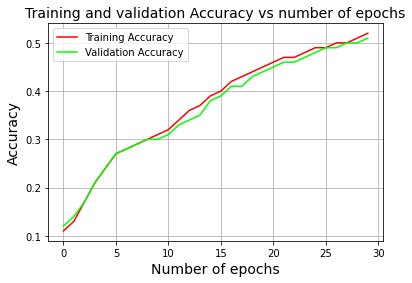

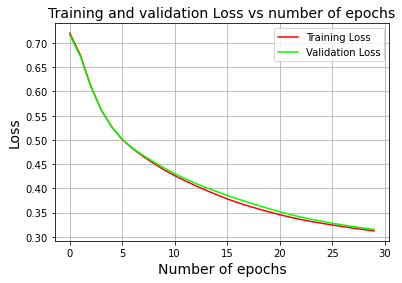

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: dxntq3uo with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 15
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:128 	 optimizer:RMS 	 L2:0.05 	 epochs:15 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.67 	 cost_val: 1.04 	 train_acc: 0.17 	 val_acc: 0.16

iter:3 	 cost_train: 0.40 	 cost_val: 0.75 	 train_acc: 0.47 	 val_acc: 0.48

iter:6 	 cost_train: 0.33 	 cost_val: 0.65 	 train_acc: 0.59 	 val_acc: 0.58

iter:9 	 cost_train: 0.28 	 cost_val: 0.57 	 train_acc: 0.65 	 val_acc: 0.65

iter:12 	 cost_train: 0.24 	 cost_val: 0.51 	 train_acc: 0.69 	 val_acc: 0.69


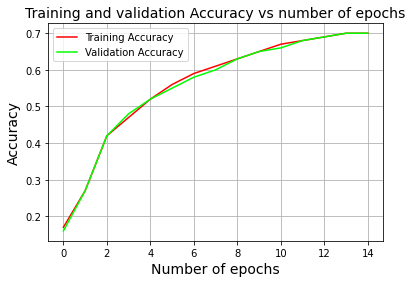

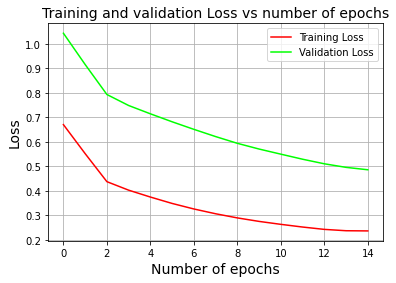

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: i9wojrjg with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:64 	 optimizer:adam 	 L2:0.0005 	 epochs:10 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.52 	 cost_val: 0.52 	 train_acc: 0.27 	 val_acc: 0.26

iter:1 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.46 	 val_acc: 0.47

iter:2 	 cost_train: 0.32 	 cost_val: 0.33 	 train_acc: 0.53 	 val_acc: 0.54

iter:3 	 cost_train: 0.29 	 cost_val: 0.30 	 train_acc: 0.59 	 val_acc: 0.58

iter:4 	 cost_train: 0.27 	 cost_val: 0.27 	 train_acc: 0.62 	 val_acc: 0.62

iter:5 	 cost_train: 0.25 	 cost_val: 0.25 	 train_acc: 0.64 	 val_acc: 0.64

iter:6 	 cost_train: 0.23 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.66

iter:7 	 cost_train: 0.22 	 cost_val: 0.23 	 train_acc: 0.68 	 val_acc: 0.67

iter:8 	 cost_train: 0.22 	 cost_val: 0.23 	 train_acc: 0.69 	 val_acc: 0.68

iter:9 	 cost_train: 0.21 	 cost_val: 0.22 	 train_acc: 0.70 	 val_acc: 0.69


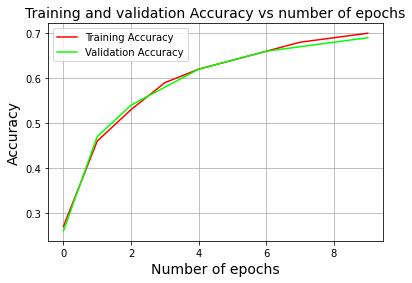

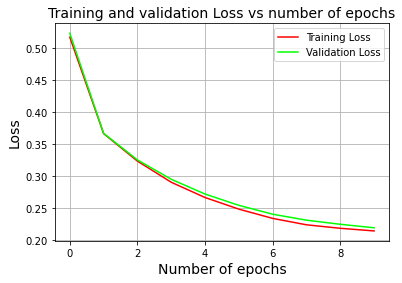

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: eebxepci with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 20
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:RMS 	 L2:0.05 	 epochs:20 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.60 	 cost_val: 0.94 	 train_acc: 0.31 	 val_acc: 0.31

iter:2 	 cost_train: 0.41 	 cost_val: 0.69 	 train_acc: 0.46 	 val_acc: 0.46

iter:4 	 cost_train: 0.34 	 cost_val: 0.58 	 train_acc: 0.57 	 val_acc: 0.56

iter:6 	 cost_train: 0.31 	 cost_val: 0.50 	 train_acc: 0.60 	 val_acc: 0.60

iter:8 	 cost_train: 0.29 	 cost_val: 0.44 	 train_acc: 0.60 	 val_acc: 0.59

iter:10 	 cost_train: 0.24 	 cost_val: 0.36 	 train_acc: 0.69 	 val_acc: 0.68

iter:12 	 cost_train: 0.22 	 cost_val: 0.32 	 train_acc: 0.70 	 val_acc: 0.69

iter:14 	 cost_train: 0.20 	 cost_val: 0.28 	 train_acc: 0.73 	 val_acc: 0.72

iter:16 	 cost_train: 0.19 	 cost_val: 0.24 	 train_acc: 0.74 	 val_acc: 0.73

iter:18 	 cost_train: 0.17 	 cost_val: 0.21 	 train_acc: 0.77 	 val_acc: 0.76


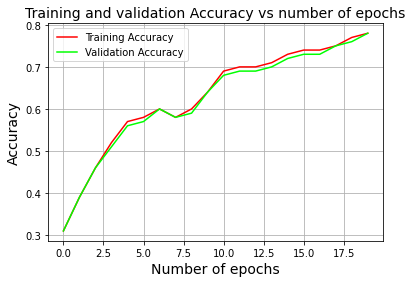

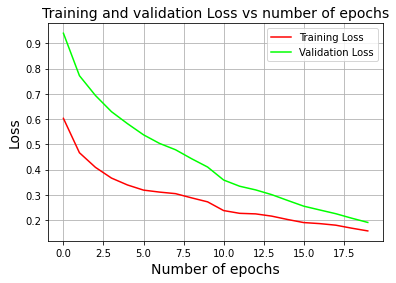

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 9gbi5foh with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:32 	 optimizer:nesterov 	 L2:0.0005 	 epochs:15 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.16 	 val_acc: 0.16

iter:3 	 cost_train: 0.51 	 cost_val: 0.52 	 train_acc: 0.20 	 val_acc: 0.20

iter:6 	 cost_train: 0.41 	 cost_val: 0.42 	 train_acc: 0.42 	 val_acc: 0.42

iter:9 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.45 	 val_acc: 0.45

iter:12 	 cost_train: 0.38 	 cost_val: 0.39 	 train_acc: 0.41 	 val_acc: 0.42


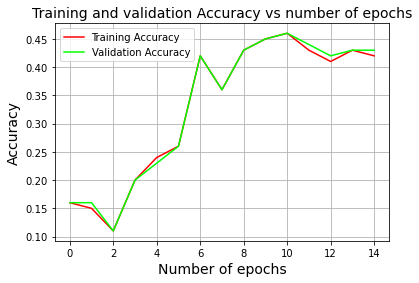

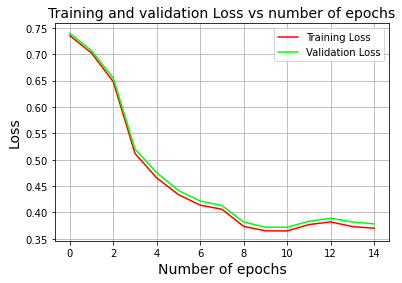

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ey1fe2ey with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:64 	 optimizer:nadam 	 L2:0.05 	 epochs:25 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.72 	 cost_val: 0.89 	 train_acc: 0.29 	 val_acc: 0.29

iter:5 	 cost_train: 0.25 	 cost_val: 0.25 	 train_acc: 0.61 	 val_acc: 0.61

iter:10 	 cost_train: 0.14 	 cost_val: 0.14 	 train_acc: 0.80 	 val_acc: 0.80

iter:15 	 cost_train: 0.13 	 cost_val: 0.13 	 train_acc: 0.81 	 val_acc: 0.81

iter:20 	 cost_train: 0.13 	 cost_val: 0.13 	 train_acc: 0.82 	 val_acc: 0.82


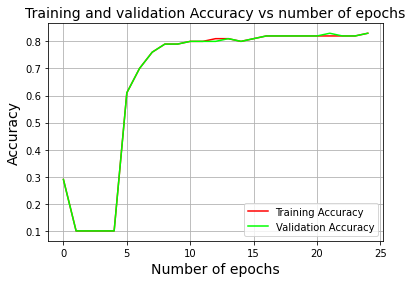

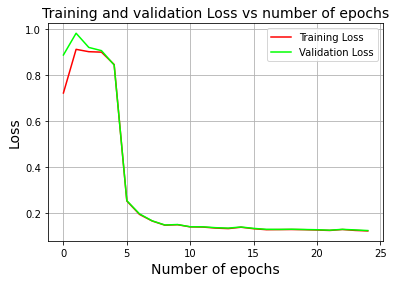

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 0fwp9xd7 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:RMS 	 L2:0.0005 	 epochs:10 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.67 	 cost_val: 0.68 	 train_acc: 0.32 	 val_acc: 0.32

iter:1 	 cost_train: 0.56 	 cost_val: 0.57 	 train_acc: 0.44 	 val_acc: 0.43

iter:2 	 cost_train: 0.51 	 cost_val: 0.52 	 train_acc: 0.49 	 val_acc: 0.48

iter:3 	 cost_train: 0.63 	 cost_val: 0.63 	 train_acc: 0.37 	 val_acc: 0.37

iter:4 	 cost_train: 0.58 	 cost_val: 0.59 	 train_acc: 0.42 	 val_acc: 0.41

iter:5 	 cost_train: 0.85 	 cost_val: 0.86 	 train_acc: 0.15 	 val_acc: 0.14

iter:6 	 cost_train: 0.79 	 cost_val: 0.79 	 train_acc: 0.21 	 val_acc: 0.21

iter:7 	 cost_train: 0.82 	 cost_val: 0.83 	 train_acc: 0.18 	 val_acc: 0.18

iter:8 	 cost_train: 0.68 	 cost_val: 0.68 	 train_acc: 0.32 	 val_acc: 0.32

iter:9 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10


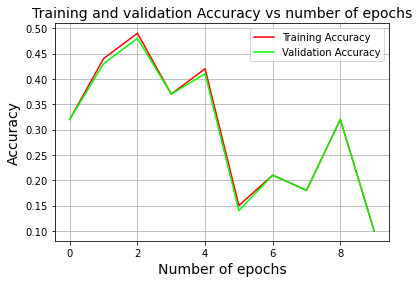

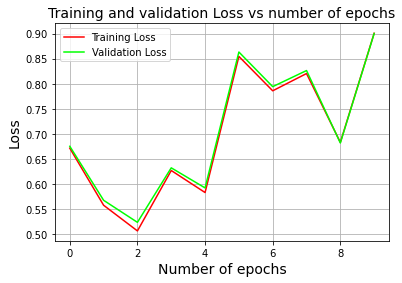

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: kbrqqrzt with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 25
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:25 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.70 	 cost_val: 0.69 	 train_acc: 0.08 	 val_acc: 0.09

iter:5 	 cost_train: 0.58 	 cost_val: 0.58 	 train_acc: 0.10 	 val_acc: 0.10

iter:10 	 cost_train: 0.54 	 cost_val: 0.53 	 train_acc: 0.13 	 val_acc: 0.13

iter:15 	 cost_train: 0.52 	 cost_val: 0.51 	 train_acc: 0.15 	 val_acc: 0.16

iter:20 	 cost_train: 0.50 	 cost_val: 0.50 	 train_acc: 0.17 	 val_acc: 0.18


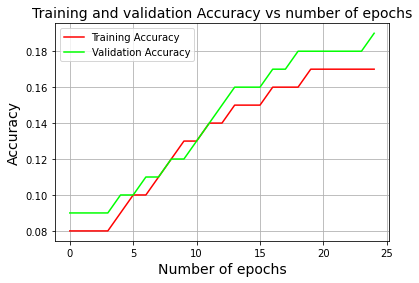

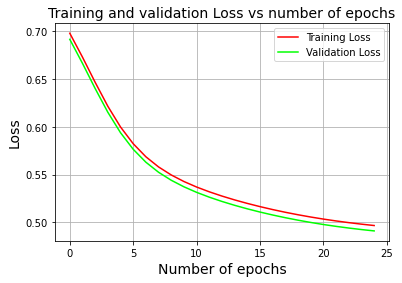

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: jg26rzvj with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:stochastic 	 L2:0.05 	 epochs:20 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.80 	 cost_val: 1.02 	 train_acc: 0.05 	 val_acc: 0.06

iter:2 	 cost_train: 0.75 	 cost_val: 0.96 	 train_acc: 0.06 	 val_acc: 0.07

iter:4 	 cost_train: 0.70 	 cost_val: 0.91 	 train_acc: 0.07 	 val_acc: 0.08

iter:6 	 cost_train: 0.65 	 cost_val: 0.86 	 train_acc: 0.10 	 val_acc: 0.10

iter:8 	 cost_train: 0.61 	 cost_val: 0.82 	 train_acc: 0.13 	 val_acc: 0.14

iter:10 	 cost_train: 0.58 	 cost_val: 0.80 	 train_acc: 0.16 	 val_acc: 0.16

iter:12 	 cost_train: 0.57 	 cost_val: 0.78 	 train_acc: 0.17 	 val_acc: 0.17

iter:14 	 cost_train: 0.56 	 cost_val: 0.77 	 train_acc: 0.18 	 val_acc: 0.18

iter:16 	 cost_train: 0.55 	 cost_val: 0.77 	 train_acc: 0.18 	 val_acc: 0.18

iter:18 	 cost_train: 0.55 	 cost_val: 0.77 	 train_acc: 0.19 	 val_acc: 0.19


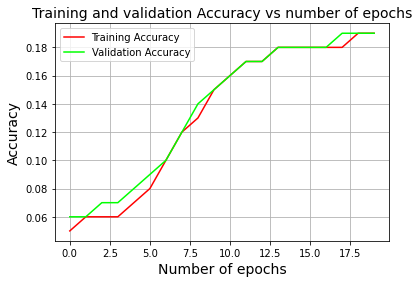

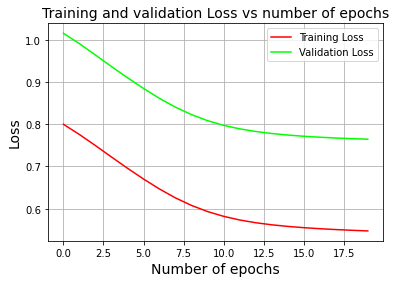

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 44y1epp7 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:RMS 	 L2:0 	 epochs:5 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.23 	 val_acc: 0.23

iter:1 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.28 	 val_acc: 0.28

iter:2 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.32 	 val_acc: 0.33

iter:3 	 cost_train: 0.38 	 cost_val: 0.39 	 train_acc: 0.38 	 val_acc: 0.38

iter:4 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.41 	 val_acc: 0.40


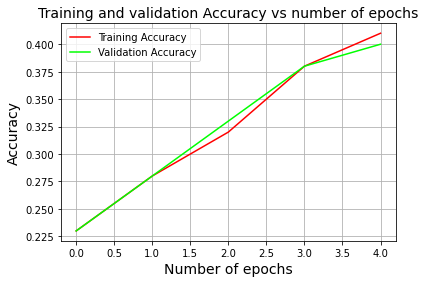

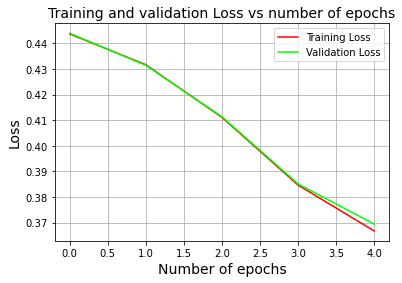

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: b8grldnn with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 25
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:momentum 	 L2:0.0005 	 epochs:25 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.88 	 cost_val: 0.88 	 train_acc: 0.10 	 val_acc: 0.10

iter:5 	 cost_train: 0.78 	 cost_val: 0.78 	 train_acc: 0.11 	 val_acc: 0.11

iter:10 	 cost_train: 0.60 	 cost_val: 0.61 	 train_acc: 0.14 	 val_acc: 0.14

iter:15 	 cost_train: 0.53 	 cost_val: 0.53 	 train_acc: 0.19 	 val_acc: 0.19

iter:20 	 cost_train: 0.48 	 cost_val: 0.48 	 train_acc: 0.25 	 val_acc: 0.25


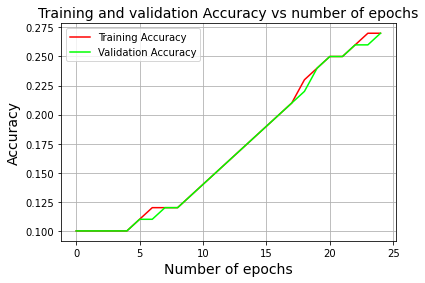

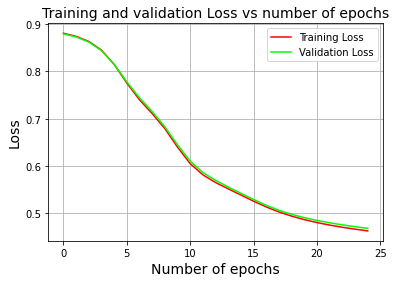

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: kp0io22z with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:momentum 	 L2:0.0005 	 epochs:5 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.14 	 val_acc: 0.14

iter:1 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.15 	 val_acc: 0.15

iter:2 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.15 	 val_acc: 0.15

iter:3 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.15 	 val_acc: 0.15

iter:4 	 cost_train: 0.73 	 cost_val: 0.74 	 train_acc: 0.15 	 val_acc: 0.14


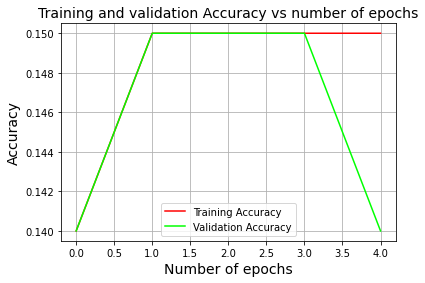

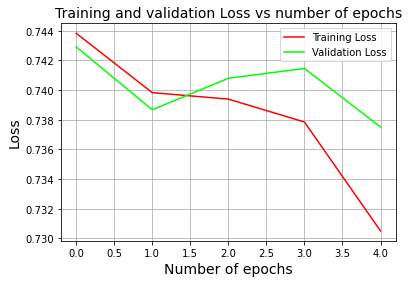

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xd2yvg62 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:adam 	 L2:0 	 epochs:5 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.39 	 cost_val: 0.39 	 train_acc: 0.43 	 val_acc: 0.43

iter:1 	 cost_train: 0.32 	 cost_val: 0.32 	 train_acc: 0.54 	 val_acc: 0.55

iter:2 	 cost_train: 0.27 	 cost_val: 0.28 	 train_acc: 0.61 	 val_acc: 0.60

iter:3 	 cost_train: 0.25 	 cost_val: 0.26 	 train_acc: 0.64 	 val_acc: 0.64

iter:4 	 cost_train: 0.24 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.65


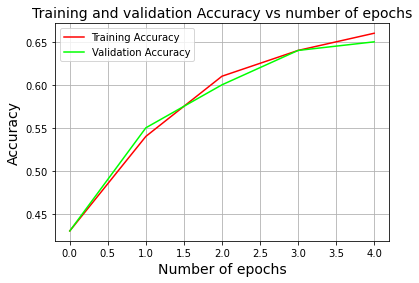

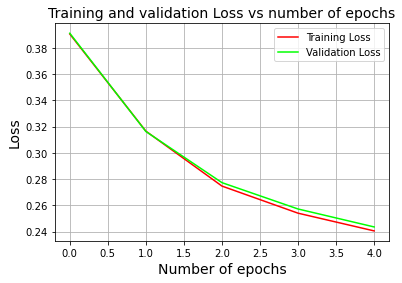

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: gbf10gv0 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 30
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:128 	 optimizer:RMS 	 L2:0.0005 	 epochs:30 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.34 	 cost_val: 0.35 	 train_acc: 0.46 	 val_acc: 0.46

iter:3 	 cost_train: 0.23 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.65

iter:6 	 cost_train: 0.25 	 cost_val: 0.26 	 train_acc: 0.62 	 val_acc: 0.63

iter:9 	 cost_train: 0.22 	 cost_val: 0.24 	 train_acc: 0.64 	 val_acc: 0.64

iter:12 	 cost_train: 0.22 	 cost_val: 0.24 	 train_acc: 0.68 	 val_acc: 0.68

iter:15 	 cost_train: 0.22 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.65

iter:18 	 cost_train: 0.22 	 cost_val: 0.23 	 train_acc: 0.68 	 val_acc: 0.68

iter:21 	 cost_train: 0.22 	 cost_val: 0.24 	 train_acc: 0.67 	 val_acc: 0.67

iter:24 	 cost_train: 0.21 	 cost_val: 0.23 	 train_acc: 0.69 	 val_acc: 0.69

iter:27 	 cost_train: 0.21 	 cost_val: 0.23 	 train_acc: 0.69 	 val_acc: 0.70


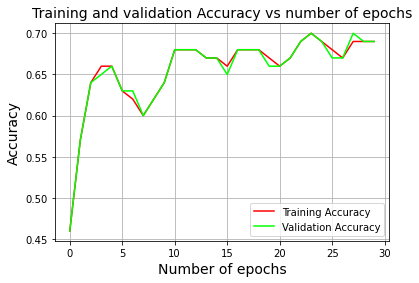

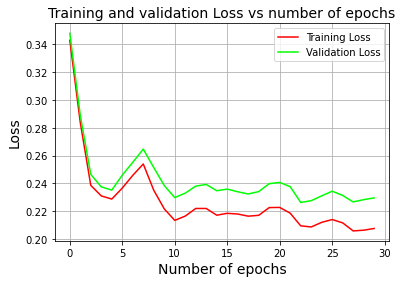

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: jrl7bv01 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:RMS 	 L2:0.0005 	 epochs:15 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.34 	 cost_val: 0.34 	 train_acc: 0.46 	 val_acc: 0.46

iter:3 	 cost_train: 0.38 	 cost_val: 0.40 	 train_acc: 0.40 	 val_acc: 0.39

iter:6 	 cost_train: 0.34 	 cost_val: 0.38 	 train_acc: 0.42 	 val_acc: 0.42

iter:9 	 cost_train: 0.38 	 cost_val: 0.44 	 train_acc: 0.37 	 val_acc: 0.38

iter:12 	 cost_train: 0.41 	 cost_val: 0.53 	 train_acc: 0.24 	 val_acc: 0.25


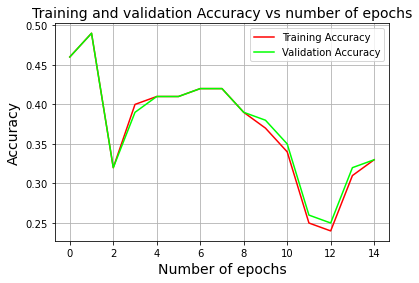

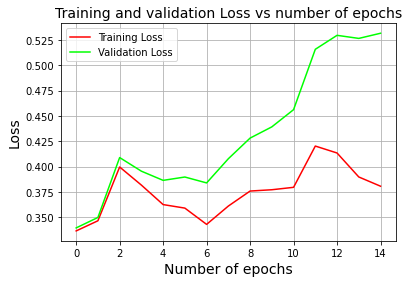

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 0o84ss0e with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:nesterov 	 L2:0 	 epochs:10 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.17 	 val_acc: 0.19

iter:1 	 cost_train: 0.42 	 cost_val: 0.42 	 train_acc: 0.26 	 val_acc: 0.26

iter:2 	 cost_train: 0.38 	 cost_val: 0.39 	 train_acc: 0.38 	 val_acc: 0.38

iter:3 	 cost_train: 0.34 	 cost_val: 0.34 	 train_acc: 0.46 	 val_acc: 0.45

iter:4 	 cost_train: 0.36 	 cost_val: 0.36 	 train_acc: 0.39 	 val_acc: 0.39

iter:5 	 cost_train: 0.35 	 cost_val: 0.35 	 train_acc: 0.42 	 val_acc: 0.41

iter:6 	 cost_train: 0.35 	 cost_val: 0.35 	 train_acc: 0.41 	 val_acc: 0.39

iter:7 	 cost_train: 0.36 	 cost_val: 0.37 	 train_acc: 0.39 	 val_acc: 0.37

iter:8 	 cost_train: 0.36 	 cost_val: 0.36 	 train_acc: 0.43 	 val_acc: 0.43

iter:9 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.33 	 val_acc: 0.33


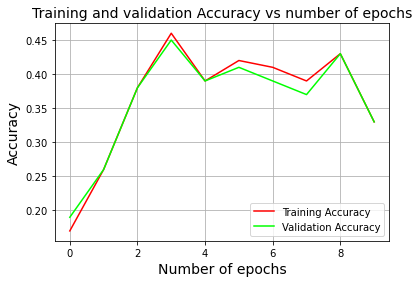

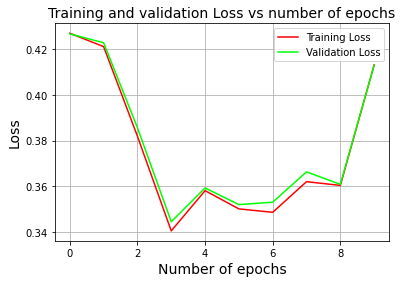

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: k5qgrt0v with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 30
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:RMS 	 L2:0.05 	 epochs:30 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.47 	 cost_val: 0.67 	 train_acc: 0.29 	 val_acc: 0.29

iter:3 	 cost_train: 0.32 	 cost_val: 0.50 	 train_acc: 0.55 	 val_acc: 0.54

iter:6 	 cost_train: 0.28 	 cost_val: 0.42 	 train_acc: 0.61 	 val_acc: 0.60

iter:9 	 cost_train: 0.23 	 cost_val: 0.35 	 train_acc: 0.69 	 val_acc: 0.68

iter:12 	 cost_train: 0.23 	 cost_val: 0.32 	 train_acc: 0.70 	 val_acc: 0.70

iter:15 	 cost_train: 0.27 	 cost_val: 0.35 	 train_acc: 0.64 	 val_acc: 0.63

iter:18 	 cost_train: 0.28 	 cost_val: 0.36 	 train_acc: 0.64 	 val_acc: 0.64

iter:21 	 cost_train: 0.34 	 cost_val: 0.42 	 train_acc: 0.51 	 val_acc: 0.51

iter:24 	 cost_train: 0.38 	 cost_val: 0.46 	 train_acc: 0.44 	 val_acc: 0.44

iter:27 	 cost_train: 0.43 	 cost_val: 0.54 	 train_acc: 0.30 	 val_acc: 0.29


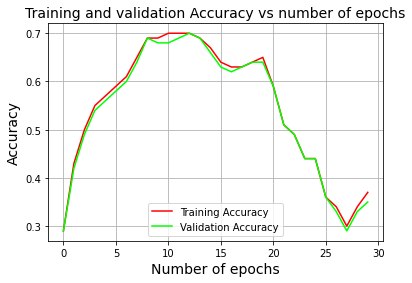

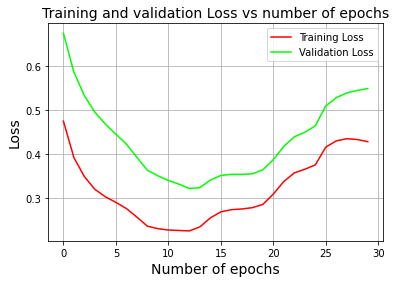

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: qpfq1ewa with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:64 	 optimizer:nadam 	 L2:0.05 	 epochs:25 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.83 	 cost_val: 0.92 	 train_acc: 0.14 	 val_acc: 0.14

iter:5 	 cost_train: 0.64 	 cost_val: 0.71 	 train_acc: 0.32 	 val_acc: 0.31

iter:10 	 cost_train: 0.46 	 cost_val: 0.51 	 train_acc: 0.51 	 val_acc: 0.51

iter:15 	 cost_train: 0.37 	 cost_val: 0.43 	 train_acc: 0.60 	 val_acc: 0.59

iter:20 	 cost_train: 0.34 	 cost_val: 0.40 	 train_acc: 0.64 	 val_acc: 0.63


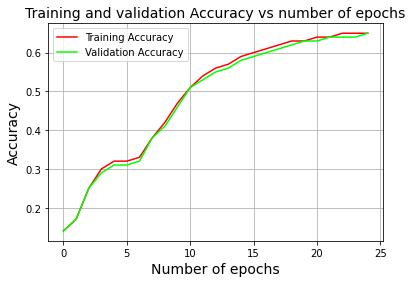

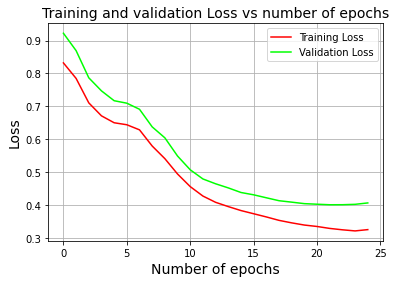

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: pwcb30z3 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:nesterov 	 L2:0.0005 	 epochs:25 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.88 	 cost_val: 0.88 	 train_acc: 0.12 	 val_acc: 0.12

iter:5 	 cost_train: 0.92 	 cost_val: 0.92 	 train_acc: 0.08 	 val_acc: 0.08

iter:10 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:15 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:20 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10


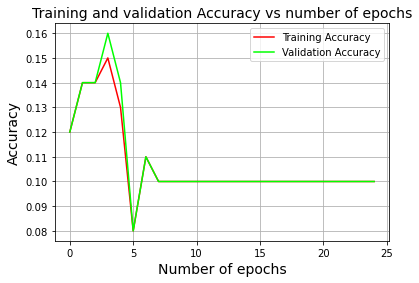

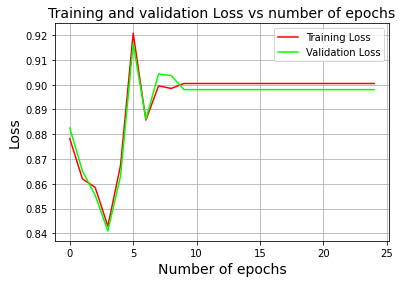

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 9wzkt3hd with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:10 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:1 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:2 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:3 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:4 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:5 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:6 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:7 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:8 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08

iter:9 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.08 	 val_acc: 0.08


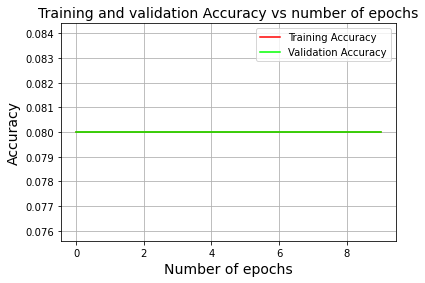

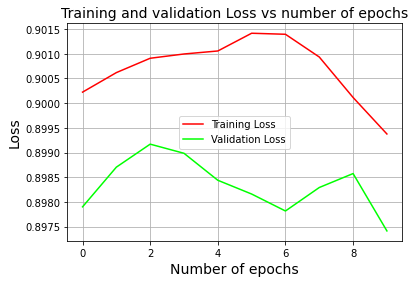

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: hejvfq3o with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:stochastic 	 L2:0.05 	 epochs:20 	 num_hidden:1 	 num_neurons:64

iter:0 	 cost_train: 0.93 	 cost_val: 1.11 	 train_acc: 0.08 	 val_acc: 0.09

iter:2 	 cost_train: 0.91 	 cost_val: 1.09 	 train_acc: 0.10 	 val_acc: 0.11

iter:4 	 cost_train: 0.86 	 cost_val: 1.04 	 train_acc: 0.14 	 val_acc: 0.15

iter:6 	 cost_train: 0.85 	 cost_val: 1.03 	 train_acc: 0.15 	 val_acc: 0.15

iter:8 	 cost_train: 0.85 	 cost_val: 1.03 	 train_acc: 0.15 	 val_acc: 0.15

iter:10 	 cost_train: 0.85 	 cost_val: 1.03 	 train_acc: 0.15 	 val_acc: 0.15

iter:12 	 cost_train: 0.84 	 cost_val: 1.02 	 train_acc: 0.16 	 val_acc: 0.16

iter:14 	 cost_train: 0.83 	 cost_val: 1.01 	 train_acc: 0.17 	 val_acc: 0.17

iter:16 	 cost_train: 0.82 	 cost_val: 1.00 	 train_acc: 0.17 	 val_acc: 0.17

iter:18 	 cost_train: 0.81 	 cost_val: 0.99 	 train_acc: 0.19 	 val_acc: 0.18


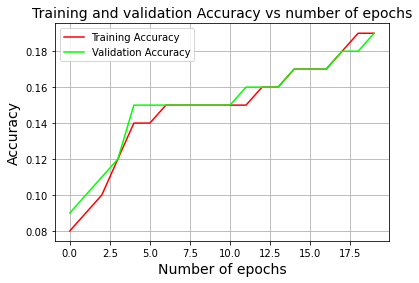

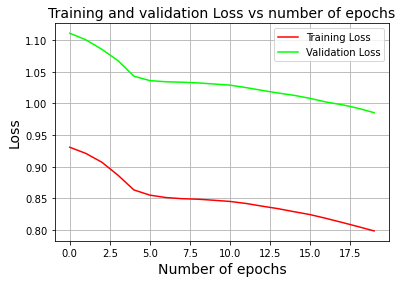

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: zdubxyu8 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 25
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:nesterov 	 L2:0 	 epochs:25 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.53 	 cost_val: 0.54 	 train_acc: 0.19 	 val_acc: 0.19

iter:5 	 cost_train: 0.36 	 cost_val: 0.36 	 train_acc: 0.44 	 val_acc: 0.44

iter:10 	 cost_train: 0.31 	 cost_val: 0.31 	 train_acc: 0.54 	 val_acc: 0.53

iter:15 	 cost_train: 0.29 	 cost_val: 0.29 	 train_acc: 0.56 	 val_acc: 0.55

iter:20 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.57 	 val_acc: 0.57


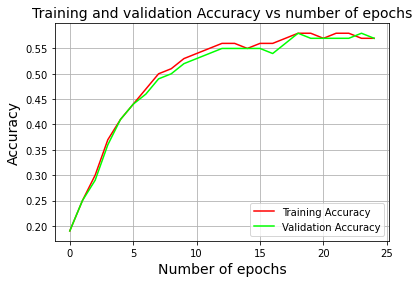

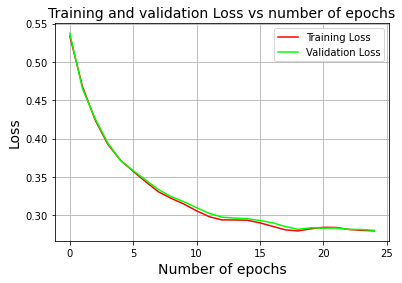

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: vdt8t9yq with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 15
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:adam 	 L2:0.0005 	 epochs:15 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.88 	 cost_val: 0.88 	 train_acc: 0.12 	 val_acc: 0.12

iter:3 	 cost_train: 0.77 	 cost_val: 0.78 	 train_acc: 0.23 	 val_acc: 0.23

iter:6 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.26 	 val_acc: 0.26

iter:9 	 cost_train: 0.69 	 cost_val: 0.70 	 train_acc: 0.31 	 val_acc: 0.31

iter:12 	 cost_train: 0.63 	 cost_val: 0.63 	 train_acc: 0.37 	 val_acc: 0.37


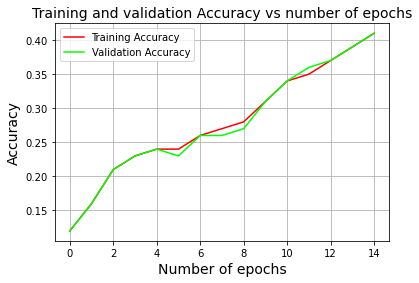

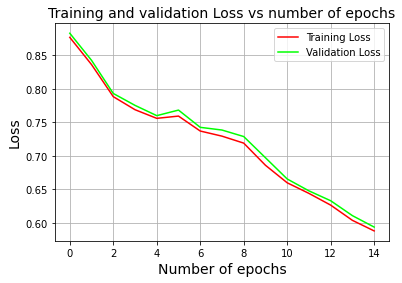

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3jyzqj4c with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:nadam 	 L2:0 	 epochs:25 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.41 	 val_acc: 0.40

iter:5 	 cost_train: 0.24 	 cost_val: 0.24 	 train_acc: 0.64 	 val_acc: 0.63

iter:10 	 cost_train: 0.23 	 cost_val: 0.23 	 train_acc: 0.63 	 val_acc: 0.62

iter:15 	 cost_train: 0.23 	 cost_val: 0.24 	 train_acc: 0.65 	 val_acc: 0.65

iter:20 	 cost_train: 0.24 	 cost_val: 0.25 	 train_acc: 0.63 	 val_acc: 0.62


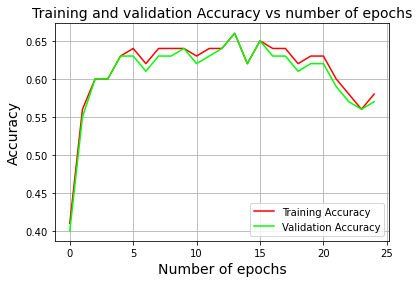

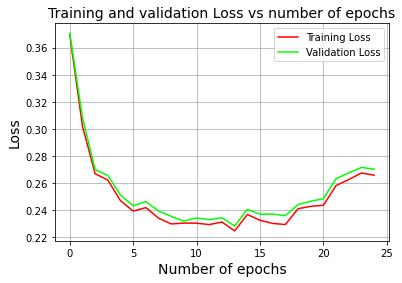

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3pxmfe0n with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:stochastic 	 L2:0.0005 	 epochs:5 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.87 	 cost_val: 0.86 	 train_acc: 0.13 	 val_acc: 0.14

iter:1 	 cost_train: 0.87 	 cost_val: 0.86 	 train_acc: 0.13 	 val_acc: 0.14

iter:2 	 cost_train: 0.86 	 cost_val: 0.86 	 train_acc: 0.14 	 val_acc: 0.14

iter:3 	 cost_train: 0.86 	 cost_val: 0.85 	 train_acc: 0.14 	 val_acc: 0.15

iter:4 	 cost_train: 0.85 	 cost_val: 0.85 	 train_acc: 0.15 	 val_acc: 0.15


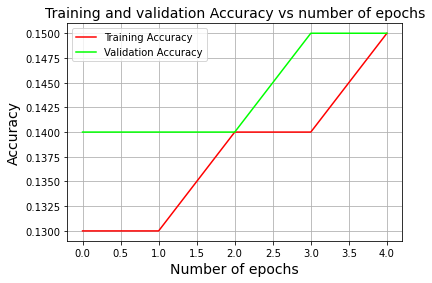

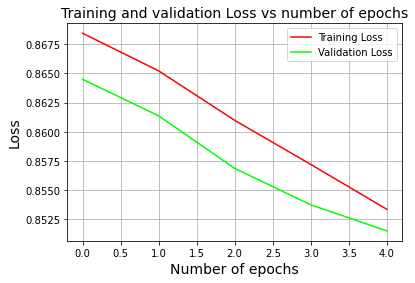

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ur1h1d5s with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:adam 	 L2:0.05 	 epochs:25 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.41 	 cost_val: 0.60 	 train_acc: 0.39 	 val_acc: 0.38

iter:5 	 cost_train: 0.22 	 cost_val: 0.30 	 train_acc: 0.70 	 val_acc: 0.69

iter:10 	 cost_train: 0.34 	 cost_val: 0.38 	 train_acc: 0.57 	 val_acc: 0.56

iter:15 	 cost_train: 0.43 	 cost_val: 0.50 	 train_acc: 0.27 	 val_acc: 0.25

iter:20 	 cost_train: 0.44 	 cost_val: 0.61 	 train_acc: 0.21 	 val_acc: 0.20


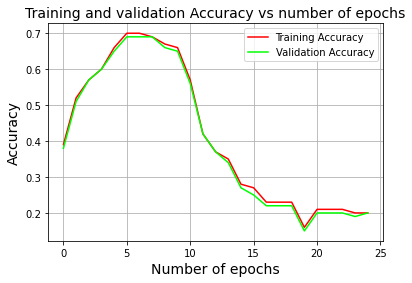

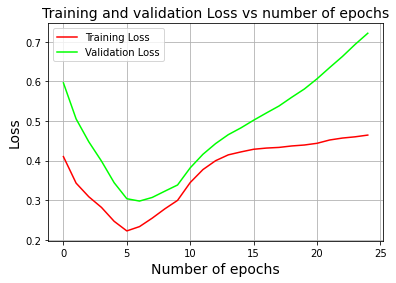

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: y61avpow with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:nadam 	 L2:0.05 	 epochs:20 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.37 	 cost_val: 0.84 	 train_acc: 0.52 	 val_acc: 0.51

iter:2 	 cost_train: 0.24 	 cost_val: 0.64 	 train_acc: 0.72 	 val_acc: 0.72

iter:4 	 cost_train: 0.26 	 cost_val: 0.47 	 train_acc: 0.63 	 val_acc: 0.63

iter:6 	 cost_train: 0.50 	 cost_val: 1.16 	 train_acc: 0.18 	 val_acc: 0.19

iter:8 	 cost_train: 0.63 	 cost_val: 2.15 	 train_acc: 0.20 	 val_acc: 0.20

iter:10 	 cost_train: 0.74 	 cost_val: 3.07 	 train_acc: 0.18 	 val_acc: 0.18

iter:12 	 cost_train: 0.86 	 cost_val: 4.25 	 train_acc: 0.18 	 val_acc: 0.19

iter:14 	 cost_train: 1.03 	 cost_val: 5.74 	 train_acc: 0.10 	 val_acc: 0.10

iter:16 	 cost_train: 1.22 	 cost_val: 7.42 	 train_acc: 0.10 	 val_acc: 0.10

iter:18 	 cost_train: 1.42 	 cost_val: 9.34 	 train_acc: 0.20 	 val_acc: 0.19


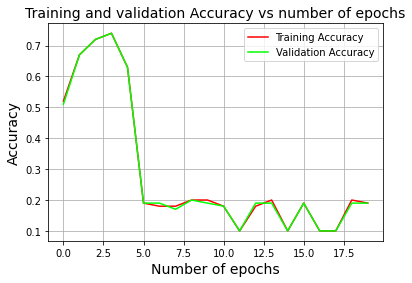

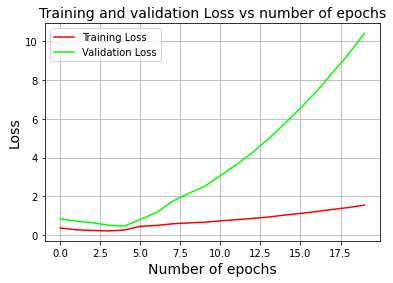

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: zr4dkuhu with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 20
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:32 	 optimizer:RMS 	 L2:0 	 epochs:20 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.61 	 cost_val: 0.61 	 train_acc: 0.39 	 val_acc: 0.39

iter:2 	 cost_train: 0.67 	 cost_val: 0.68 	 train_acc: 0.33 	 val_acc: 0.32

iter:4 	 cost_train: 0.62 	 cost_val: 0.62 	 train_acc: 0.38 	 val_acc: 0.38

iter:6 	 cost_train: 0.78 	 cost_val: 0.79 	 train_acc: 0.22 	 val_acc: 0.21

iter:8 	 cost_train: 0.66 	 cost_val: 0.66 	 train_acc: 0.34 	 val_acc: 0.34

iter:10 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:12 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:14 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:16 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:18 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10


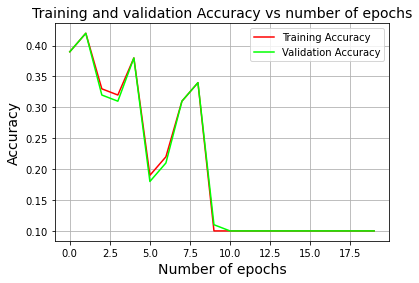

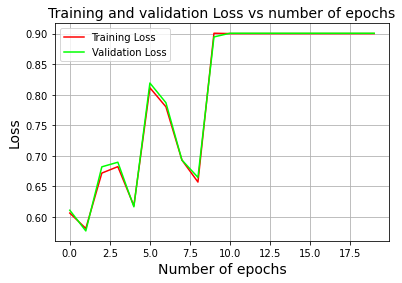

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: eap9e4j6 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:5 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.87 	 cost_val: 0.87 	 train_acc: 0.13 	 val_acc: 0.13

iter:1 	 cost_train: 0.86 	 cost_val: 0.86 	 train_acc: 0.14 	 val_acc: 0.14

iter:2 	 cost_train: 0.86 	 cost_val: 0.85 	 train_acc: 0.14 	 val_acc: 0.15

iter:3 	 cost_train: 0.85 	 cost_val: 0.85 	 train_acc: 0.15 	 val_acc: 0.15

iter:4 	 cost_train: 0.84 	 cost_val: 0.84 	 train_acc: 0.16 	 val_acc: 0.16


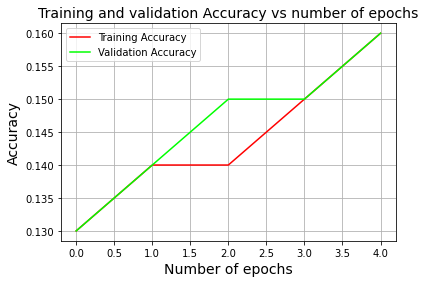

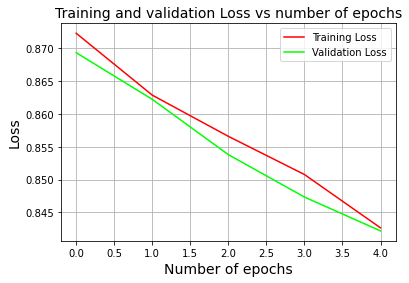

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: p436uaga with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:32 	 optimizer:momentum 	 L2:0.05 	 epochs:15 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.51 	 cost_val: 0.72 	 train_acc: 0.14 	 val_acc: 0.14

iter:3 	 cost_train: 0.42 	 cost_val: 0.66 	 train_acc: 0.37 	 val_acc: 0.36

iter:6 	 cost_train: 0.37 	 cost_val: 0.63 	 train_acc: 0.49 	 val_acc: 0.48

iter:9 	 cost_train: 0.34 	 cost_val: 0.60 	 train_acc: 0.53 	 val_acc: 0.52

iter:12 	 cost_train: 0.29 	 cost_val: 0.55 	 train_acc: 0.62 	 val_acc: 0.62


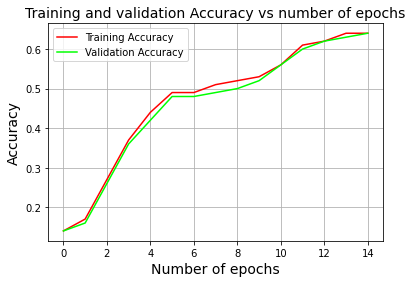

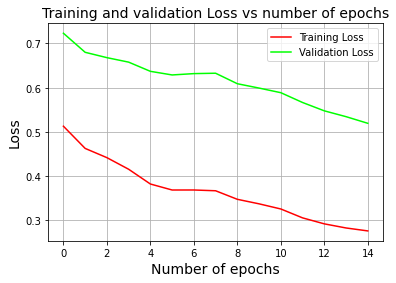

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xkonb7nc with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 30
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:adam 	 L2:0.0005 	 epochs:30 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.82 	 cost_val: 0.83 	 train_acc: 0.18 	 val_acc: 0.18

iter:3 	 cost_train: 0.77 	 cost_val: 0.77 	 train_acc: 0.23 	 val_acc: 0.24

iter:6 	 cost_train: 0.70 	 cost_val: 0.70 	 train_acc: 0.30 	 val_acc: 0.30

iter:9 	 cost_train: 0.66 	 cost_val: 0.67 	 train_acc: 0.34 	 val_acc: 0.33

iter:12 	 cost_train: 0.67 	 cost_val: 0.67 	 train_acc: 0.33 	 val_acc: 0.33

iter:15 	 cost_train: 0.67 	 cost_val: 0.66 	 train_acc: 0.33 	 val_acc: 0.34

iter:18 	 cost_train: 0.74 	 cost_val: 0.75 	 train_acc: 0.26 	 val_acc: 0.25

iter:21 	 cost_train: 0.65 	 cost_val: 0.65 	 train_acc: 0.35 	 val_acc: 0.35

iter:24 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:27 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.11


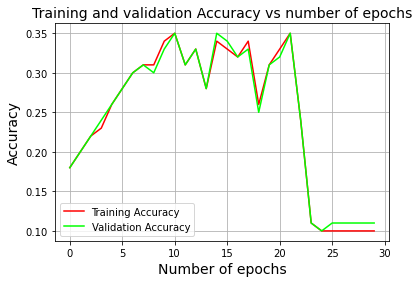

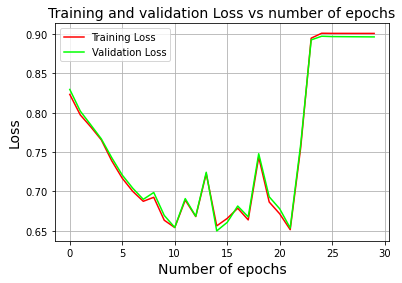

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: i6fqzv2e with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 20
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:64 	 optimizer:adam 	 L2:0.0005 	 epochs:20 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.41 	 cost_val: 0.42 	 train_acc: 0.26 	 val_acc: 0.25

iter:2 	 cost_train: 0.29 	 cost_val: 0.30 	 train_acc: 0.56 	 val_acc: 0.55

iter:4 	 cost_train: 0.29 	 cost_val: 0.30 	 train_acc: 0.57 	 val_acc: 0.56

iter:6 	 cost_train: 0.27 	 cost_val: 0.28 	 train_acc: 0.58 	 val_acc: 0.58

iter:8 	 cost_train: 0.26 	 cost_val: 0.27 	 train_acc: 0.62 	 val_acc: 0.61

iter:10 	 cost_train: 0.24 	 cost_val: 0.26 	 train_acc: 0.64 	 val_acc: 0.64

iter:12 	 cost_train: 0.23 	 cost_val: 0.26 	 train_acc: 0.65 	 val_acc: 0.64

iter:14 	 cost_train: 0.23 	 cost_val: 0.26 	 train_acc: 0.66 	 val_acc: 0.65

iter:16 	 cost_train: 0.25 	 cost_val: 0.28 	 train_acc: 0.62 	 val_acc: 0.62

iter:18 	 cost_train: 0.24 	 cost_val: 0.28 	 train_acc: 0.64 	 val_acc: 0.63


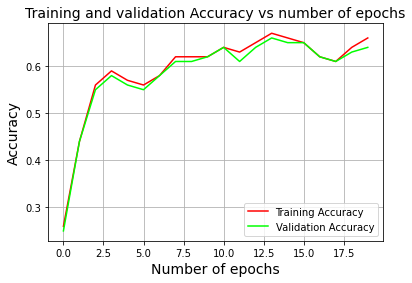

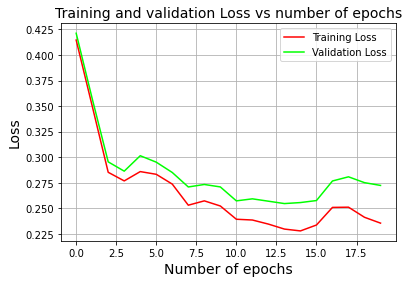

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: n0cqdilb with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:128 	 optimizer:adam 	 L2:0.0005 	 epochs:15 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.72 	 cost_val: 0.72 	 train_acc: 0.11 	 val_acc: 0.11

iter:3 	 cost_train: 0.52 	 cost_val: 0.52 	 train_acc: 0.10 	 val_acc: 0.10

iter:6 	 cost_train: 0.44 	 cost_val: 0.45 	 train_acc: 0.17 	 val_acc: 0.16

iter:9 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.24 	 val_acc: 0.24

iter:12 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.28 	 val_acc: 0.28


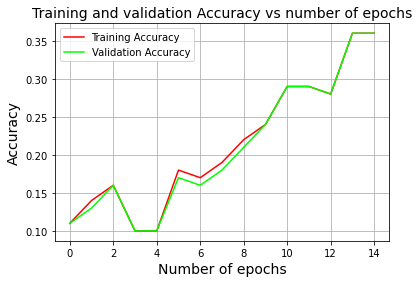

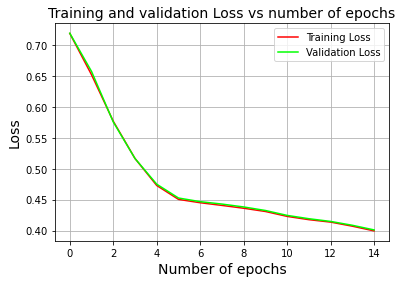

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: d3r1ow8x with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:64 	 optimizer:momentum 	 L2:0.05 	 epochs:10 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.77 	 cost_val: 0.99 	 train_acc: 0.13 	 val_acc: 0.13

iter:1 	 cost_train: 0.78 	 cost_val: 1.00 	 train_acc: 0.12 	 val_acc: 0.12

iter:2 	 cost_train: 0.80 	 cost_val: 1.03 	 train_acc: 0.11 	 val_acc: 0.11

iter:3 	 cost_train: 0.73 	 cost_val: 0.96 	 train_acc: 0.14 	 val_acc: 0.14

iter:4 	 cost_train: 0.59 	 cost_val: 0.82 	 train_acc: 0.17 	 val_acc: 0.18

iter:5 	 cost_train: 0.52 	 cost_val: 0.77 	 train_acc: 0.17 	 val_acc: 0.17

iter:6 	 cost_train: 0.50 	 cost_val: 0.76 	 train_acc: 0.17 	 val_acc: 0.18

iter:7 	 cost_train: 0.50 	 cost_val: 0.77 	 train_acc: 0.18 	 val_acc: 0.18

iter:8 	 cost_train: 0.50 	 cost_val: 0.78 	 train_acc: 0.18 	 val_acc: 0.18

iter:9 	 cost_train: 0.49 	 cost_val: 0.79 	 train_acc: 0.18 	 val_acc: 0.18


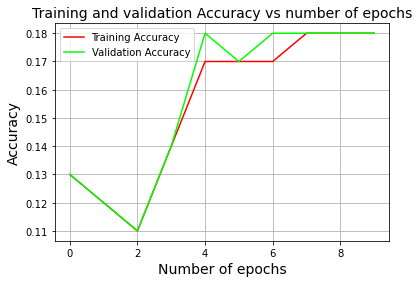

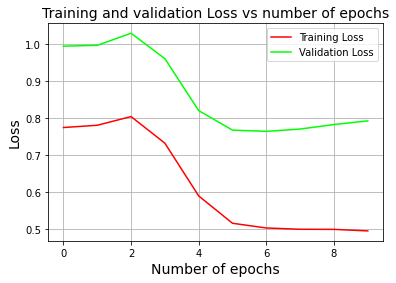

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: seyt08if with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 20
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:128 	 optimizer:adam 	 L2:0 	 epochs:20 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.77 	 cost_val: 0.77 	 train_acc: 0.12 	 val_acc: 0.12

iter:2 	 cost_train: 0.60 	 cost_val: 0.61 	 train_acc: 0.18 	 val_acc: 0.18

iter:4 	 cost_train: 0.46 	 cost_val: 0.46 	 train_acc: 0.18 	 val_acc: 0.18

iter:6 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.26 	 val_acc: 0.25

iter:8 	 cost_train: 0.39 	 cost_val: 0.39 	 train_acc: 0.36 	 val_acc: 0.36

iter:10 	 cost_train: 0.39 	 cost_val: 0.39 	 train_acc: 0.34 	 val_acc: 0.34

iter:12 	 cost_train: 0.39 	 cost_val: 0.39 	 train_acc: 0.37 	 val_acc: 0.37

iter:14 	 cost_train: 0.39 	 cost_val: 0.40 	 train_acc: 0.38 	 val_acc: 0.38

iter:16 	 cost_train: 0.39 	 cost_val: 0.39 	 train_acc: 0.37 	 val_acc: 0.37

iter:18 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.38 	 val_acc: 0.37


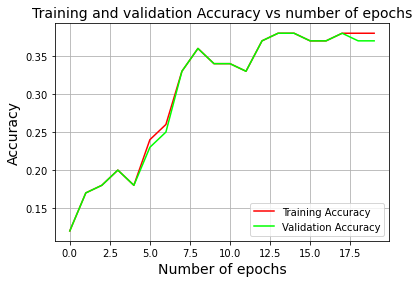

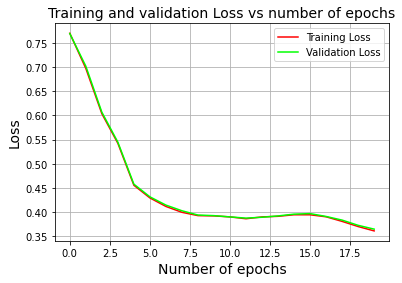

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: h6hsgog6 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:5 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.84 	 cost_val: 0.84 	 train_acc: 0.10 	 val_acc: 0.10

iter:1 	 cost_train: 0.71 	 cost_val: 0.71 	 train_acc: 0.12 	 val_acc: 0.12

iter:2 	 cost_train: 0.58 	 cost_val: 0.58 	 train_acc: 0.15 	 val_acc: 0.15

iter:3 	 cost_train: 0.52 	 cost_val: 0.53 	 train_acc: 0.19 	 val_acc: 0.19

iter:4 	 cost_train: 0.49 	 cost_val: 0.49 	 train_acc: 0.24 	 val_acc: 0.24


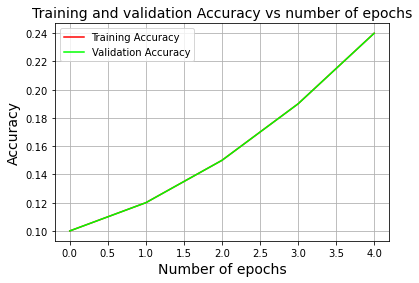

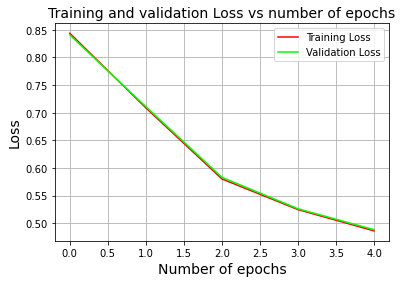

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: cgdn92cl with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:RMS 	 L2:0.05 	 epochs:20 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.93 	 cost_val: 1.12 	 train_acc: 0.10 	 val_acc: 0.10

iter:2 	 cost_train: 0.90 	 cost_val: 1.07 	 train_acc: 0.12 	 val_acc: 0.13

iter:4 	 cost_train: 0.82 	 cost_val: 0.98 	 train_acc: 0.19 	 val_acc: 0.20

iter:6 	 cost_train: 0.78 	 cost_val: 0.92 	 train_acc: 0.24 	 val_acc: 0.23

iter:8 	 cost_train: 0.74 	 cost_val: 0.87 	 train_acc: 0.27 	 val_acc: 0.26

iter:10 	 cost_train: 0.72 	 cost_val: 0.83 	 train_acc: 0.29 	 val_acc: 0.29

iter:12 	 cost_train: 0.67 	 cost_val: 0.78 	 train_acc: 0.34 	 val_acc: 0.33

iter:14 	 cost_train: 0.67 	 cost_val: 0.77 	 train_acc: 0.34 	 val_acc: 0.33

iter:16 	 cost_train: 0.69 	 cost_val: 0.78 	 train_acc: 0.32 	 val_acc: 0.32

iter:18 	 cost_train: 0.69 	 cost_val: 0.78 	 train_acc: 0.32 	 val_acc: 0.31


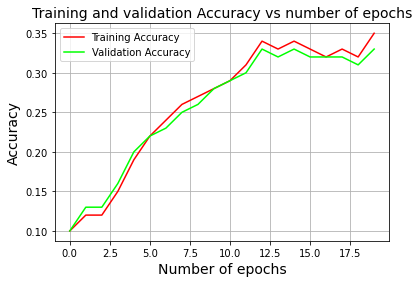

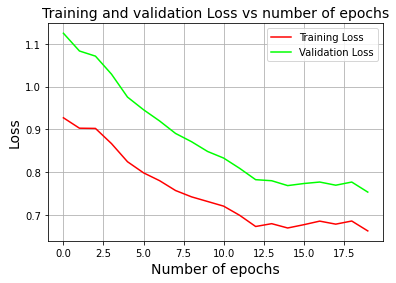

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: rvw0qfeo with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:stochastic 	 L2:0.0005 	 epochs:5 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.75 	 cost_val: 0.75 	 train_acc: 0.06 	 val_acc: 0.06

iter:1 	 cost_train: 0.70 	 cost_val: 0.69 	 train_acc: 0.06 	 val_acc: 0.07

iter:2 	 cost_train: 0.64 	 cost_val: 0.64 	 train_acc: 0.08 	 val_acc: 0.09

iter:3 	 cost_train: 0.60 	 cost_val: 0.60 	 train_acc: 0.12 	 val_acc: 0.12

iter:4 	 cost_train: 0.57 	 cost_val: 0.56 	 train_acc: 0.15 	 val_acc: 0.15


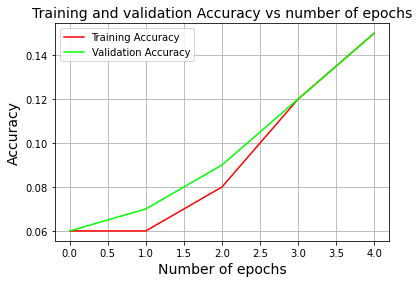

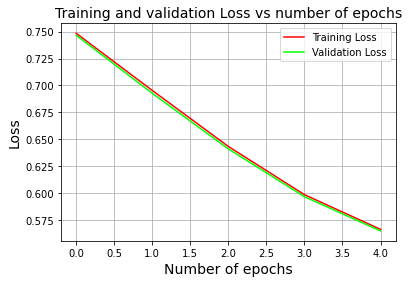

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: rdm22zn0 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:nesterov 	 L2:0.05 	 epochs:10 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.68 	 cost_val: 1.11 	 train_acc: 0.13 	 val_acc: 0.12

iter:1 	 cost_train: 0.59 	 cost_val: 1.03 	 train_acc: 0.19 	 val_acc: 0.18

iter:2 	 cost_train: 0.57 	 cost_val: 1.00 	 train_acc: 0.21 	 val_acc: 0.20

iter:3 	 cost_train: 0.54 	 cost_val: 0.96 	 train_acc: 0.24 	 val_acc: 0.24

iter:4 	 cost_train: 0.51 	 cost_val: 0.93 	 train_acc: 0.26 	 val_acc: 0.26

iter:5 	 cost_train: 0.49 	 cost_val: 0.91 	 train_acc: 0.27 	 val_acc: 0.27

iter:6 	 cost_train: 0.48 	 cost_val: 0.89 	 train_acc: 0.29 	 val_acc: 0.29

iter:7 	 cost_train: 0.46 	 cost_val: 0.87 	 train_acc: 0.33 	 val_acc: 0.32

iter:8 	 cost_train: 0.45 	 cost_val: 0.86 	 train_acc: 0.36 	 val_acc: 0.35

iter:9 	 cost_train: 0.43 	 cost_val: 0.84 	 train_acc: 0.38 	 val_acc: 0.38


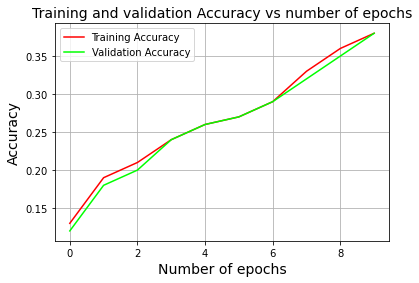

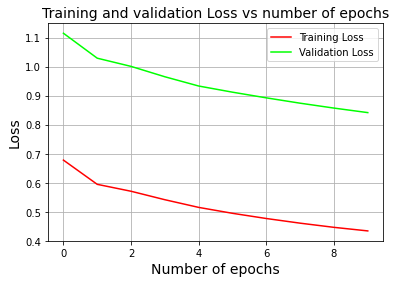

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ldacxpgq with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:momentum 	 L2:0.05 	 epochs:25 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.90 	 cost_val: 1.00 	 train_acc: 0.11 	 val_acc: 0.11

iter:5 	 cost_train: 0.89 	 cost_val: 0.99 	 train_acc: 0.12 	 val_acc: 0.12

iter:10 	 cost_train: 0.91 	 cost_val: 1.01 	 train_acc: 0.10 	 val_acc: 0.10

iter:15 	 cost_train: 0.91 	 cost_val: 1.01 	 train_acc: 0.10 	 val_acc: 0.11

iter:20 	 cost_train: 0.91 	 cost_val: 1.01 	 train_acc: 0.10 	 val_acc: 0.11


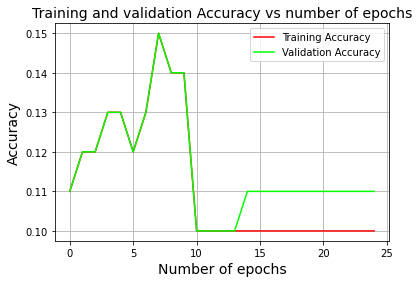

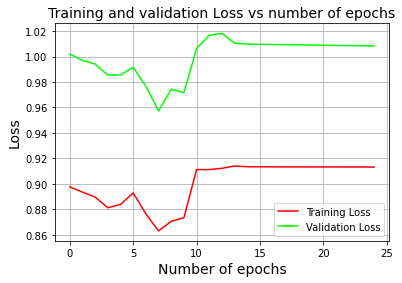

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: vtpjspbv with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:128 	 optimizer:RMS 	 L2:0.05 	 epochs:25 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.71 	 cost_val: 0.80 	 train_acc: 0.13 	 val_acc: 0.13

iter:5 	 cost_train: 0.36 	 cost_val: 0.45 	 train_acc: 0.48 	 val_acc: 0.47

iter:10 	 cost_train: 0.30 	 cost_val: 0.39 	 train_acc: 0.57 	 val_acc: 0.56

iter:15 	 cost_train: 0.28 	 cost_val: 0.36 	 train_acc: 0.60 	 val_acc: 0.59

iter:20 	 cost_train: 0.26 	 cost_val: 0.33 	 train_acc: 0.64 	 val_acc: 0.64


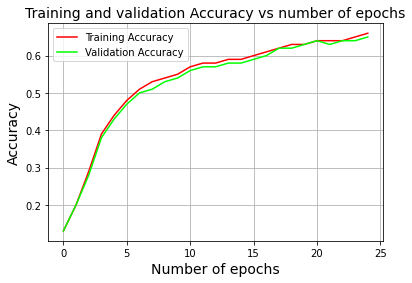

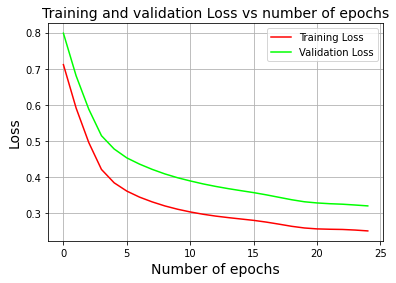

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: l0h842e1 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:adam 	 L2:0.0005 	 epochs:5 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.82 	 cost_val: 0.83 	 train_acc: 0.18 	 val_acc: 0.18

iter:1 	 cost_train: 0.80 	 cost_val: 0.80 	 train_acc: 0.20 	 val_acc: 0.20

iter:2 	 cost_train: 0.78 	 cost_val: 0.78 	 train_acc: 0.22 	 val_acc: 0.22

iter:3 	 cost_train: 0.77 	 cost_val: 0.77 	 train_acc: 0.23 	 val_acc: 0.24

iter:4 	 cost_train: 0.74 	 cost_val: 0.74 	 train_acc: 0.26 	 val_acc: 0.26


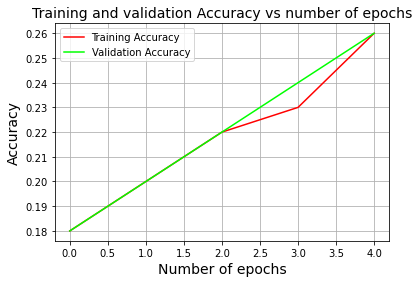

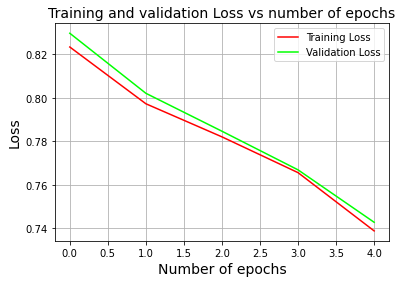

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: s6ahi77f with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:adam 	 L2:0 	 epochs:25 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.32 	 cost_val: 0.33 	 train_acc: 0.48 	 val_acc: 0.48

iter:5 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.57 	 val_acc: 0.57

iter:10 	 cost_train: 0.24 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.65

iter:15 	 cost_train: 0.24 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.66

iter:20 	 cost_train: 0.25 	 cost_val: 0.25 	 train_acc: 0.63 	 val_acc: 0.63


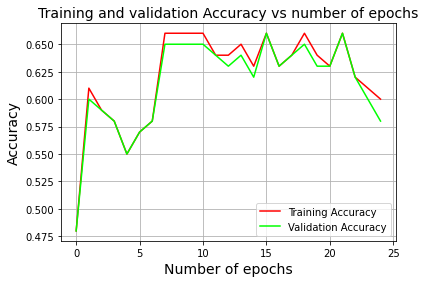

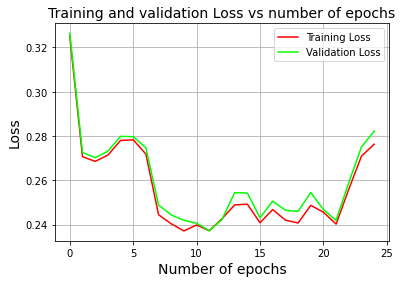

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: veyizvko with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:momentum 	 L2:0.0005 	 epochs:25 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.87 	 cost_val: 0.87 	 train_acc: 0.10 	 val_acc: 0.10

iter:5 	 cost_train: 0.58 	 cost_val: 0.59 	 train_acc: 0.15 	 val_acc: 0.15

iter:10 	 cost_train: 0.47 	 cost_val: 0.48 	 train_acc: 0.25 	 val_acc: 0.25

iter:15 	 cost_train: 0.44 	 cost_val: 0.45 	 train_acc: 0.29 	 val_acc: 0.29

iter:20 	 cost_train: 0.42 	 cost_val: 0.42 	 train_acc: 0.32 	 val_acc: 0.32


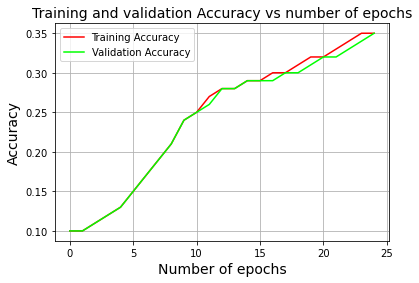

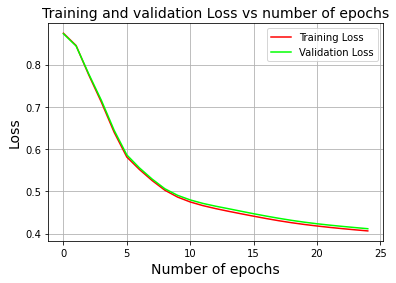

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3xhx585g with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:128 	 optimizer:nesterov 	 L2:0.05 	 epochs:10 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.66 	 cost_val: 0.75 	 train_acc: 0.14 	 val_acc: 0.14

iter:1 	 cost_train: 0.54 	 cost_val: 0.63 	 train_acc: 0.24 	 val_acc: 0.24

iter:2 	 cost_train: 0.49 	 cost_val: 0.58 	 train_acc: 0.29 	 val_acc: 0.29

iter:3 	 cost_train: 0.45 	 cost_val: 0.55 	 train_acc: 0.31 	 val_acc: 0.30

iter:4 	 cost_train: 0.42 	 cost_val: 0.52 	 train_acc: 0.35 	 val_acc: 0.33

iter:5 	 cost_train: 0.40 	 cost_val: 0.49 	 train_acc: 0.39 	 val_acc: 0.38

iter:6 	 cost_train: 0.38 	 cost_val: 0.48 	 train_acc: 0.43 	 val_acc: 0.42

iter:7 	 cost_train: 0.36 	 cost_val: 0.46 	 train_acc: 0.45 	 val_acc: 0.44

iter:8 	 cost_train: 0.35 	 cost_val: 0.44 	 train_acc: 0.47 	 val_acc: 0.47

iter:9 	 cost_train: 0.34 	 cost_val: 0.43 	 train_acc: 0.49 	 val_acc: 0.48


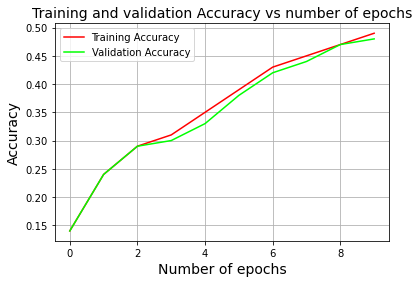

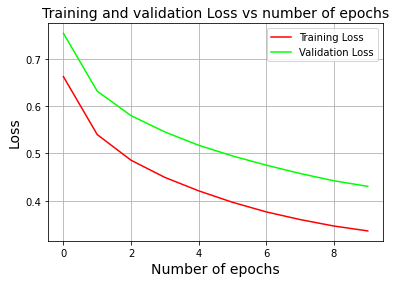

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: y7ud8hoe with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:64 	 optimizer:stochastic 	 L2:0.0005 	 epochs:10 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.71 	 cost_val: 0.70 	 train_acc: 0.08 	 val_acc: 0.09

iter:1 	 cost_train: 0.70 	 cost_val: 0.69 	 train_acc: 0.08 	 val_acc: 0.09

iter:2 	 cost_train: 0.69 	 cost_val: 0.68 	 train_acc: 0.08 	 val_acc: 0.09

iter:3 	 cost_train: 0.67 	 cost_val: 0.67 	 train_acc: 0.08 	 val_acc: 0.09

iter:4 	 cost_train: 0.66 	 cost_val: 0.65 	 train_acc: 0.08 	 val_acc: 0.09

iter:5 	 cost_train: 0.65 	 cost_val: 0.64 	 train_acc: 0.08 	 val_acc: 0.09

iter:6 	 cost_train: 0.63 	 cost_val: 0.63 	 train_acc: 0.08 	 val_acc: 0.09

iter:7 	 cost_train: 0.62 	 cost_val: 0.62 	 train_acc: 0.08 	 val_acc: 0.09

iter:8 	 cost_train: 0.61 	 cost_val: 0.61 	 train_acc: 0.09 	 val_acc: 0.09

iter:9 	 cost_train: 0.60 	 cost_val: 0.59 	 train_acc: 0.09 	 val_acc: 0.10


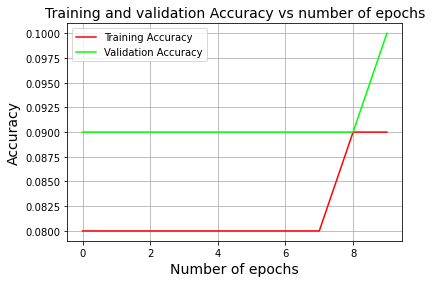

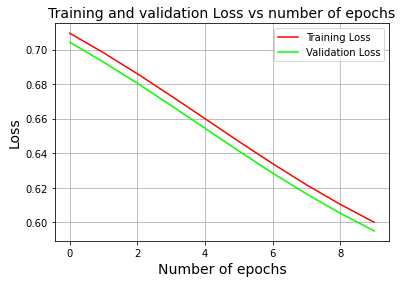

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3zrlgn36 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 20
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:64 	 optimizer:nadam 	 L2:0.05 	 epochs:20 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.27 	 cost_val: 0.43 	 train_acc: 0.63 	 val_acc: 0.63

iter:2 	 cost_train: 0.46 	 cost_val: 0.72 	 train_acc: 0.28 	 val_acc: 0.28

iter:4 	 cost_train: 0.53 	 cost_val: 1.25 	 train_acc: 0.20 	 val_acc: 0.20

iter:6 	 cost_train: 0.60 	 cost_val: 1.83 	 train_acc: 0.18 	 val_acc: 0.17

iter:8 	 cost_train: 0.67 	 cost_val: 2.48 	 train_acc: 0.19 	 val_acc: 0.19

iter:10 	 cost_train: 0.77 	 cost_val: 3.40 	 train_acc: 0.20 	 val_acc: 0.20

iter:12 	 cost_train: 0.95 	 cost_val: 5.07 	 train_acc: 0.17 	 val_acc: 0.18

iter:14 	 cost_train: 1.18 	 cost_val: 7.08 	 train_acc: 0.18 	 val_acc: 0.18

iter:16 	 cost_train: 1.21 	 cost_val: 7.32 	 train_acc: 0.10 	 val_acc: 0.10

iter:18 	 cost_train: 1.01 	 cost_val: 5.45 	 train_acc: 0.10 	 val_acc: 0.10


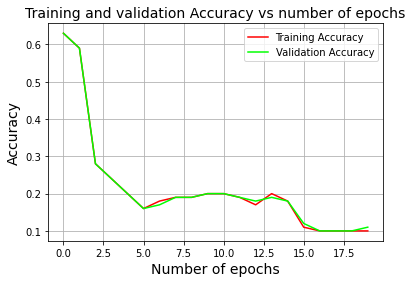

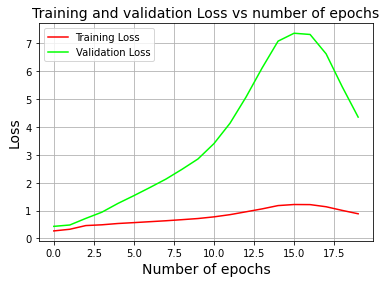

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: v0paped1 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:64 	 optimizer:nadam 	 L2:0 	 epochs:5 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.25 	 val_acc: 0.25

iter:1 	 cost_train: 0.37 	 cost_val: 0.37 	 train_acc: 0.40 	 val_acc: 0.40

iter:2 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.50 	 val_acc: 0.50

iter:3 	 cost_train: 0.32 	 cost_val: 0.32 	 train_acc: 0.52 	 val_acc: 0.53

iter:4 	 cost_train: 0.32 	 cost_val: 0.33 	 train_acc: 0.52 	 val_acc: 0.51


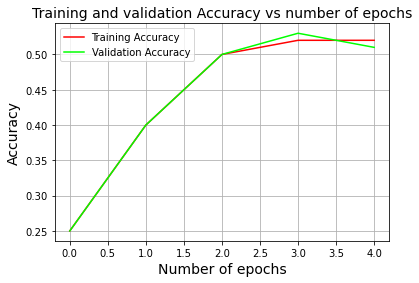

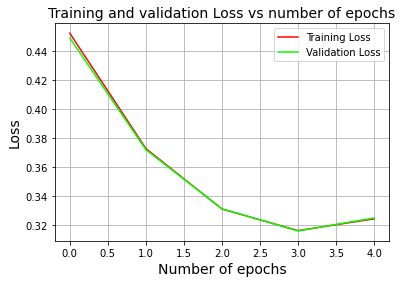

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: mrpkgtmj with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:5 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.70 	 cost_val: 0.69 	 train_acc: 0.08 	 val_acc: 0.09

iter:1 	 cost_train: 0.67 	 cost_val: 0.67 	 train_acc: 0.08 	 val_acc: 0.09

iter:2 	 cost_train: 0.65 	 cost_val: 0.64 	 train_acc: 0.08 	 val_acc: 0.09

iter:3 	 cost_train: 0.62 	 cost_val: 0.62 	 train_acc: 0.08 	 val_acc: 0.09

iter:4 	 cost_train: 0.60 	 cost_val: 0.59 	 train_acc: 0.09 	 val_acc: 0.10


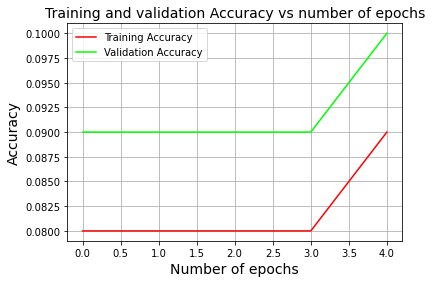

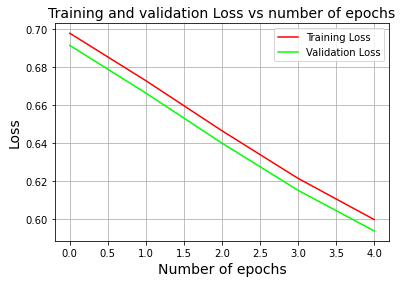

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: c08jqb3c with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:momentum 	 L2:0.0005 	 epochs:20 	 num_hidden:1 	 num_neurons:32

iter:0 	 cost_train: 0.75 	 cost_val: 0.75 	 train_acc: 0.10 	 val_acc: 0.10

iter:2 	 cost_train: 0.69 	 cost_val: 0.69 	 train_acc: 0.13 	 val_acc: 0.13

iter:4 	 cost_train: 0.64 	 cost_val: 0.64 	 train_acc: 0.15 	 val_acc: 0.15

iter:6 	 cost_train: 0.57 	 cost_val: 0.58 	 train_acc: 0.20 	 val_acc: 0.20

iter:8 	 cost_train: 0.53 	 cost_val: 0.53 	 train_acc: 0.23 	 val_acc: 0.23

iter:10 	 cost_train: 0.51 	 cost_val: 0.51 	 train_acc: 0.26 	 val_acc: 0.26

iter:12 	 cost_train: 0.48 	 cost_val: 0.49 	 train_acc: 0.28 	 val_acc: 0.28

iter:14 	 cost_train: 0.47 	 cost_val: 0.47 	 train_acc: 0.29 	 val_acc: 0.29

iter:16 	 cost_train: 0.45 	 cost_val: 0.46 	 train_acc: 0.30 	 val_acc: 0.30

iter:18 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.31 	 val_acc: 0.30


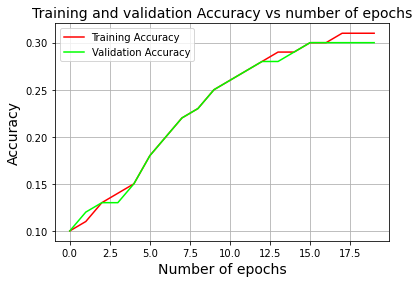

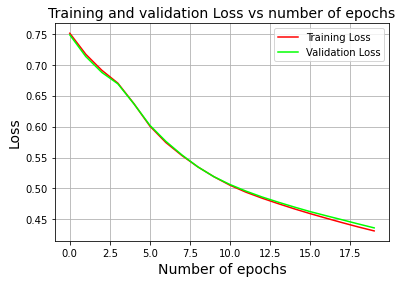

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 12bjeozy with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 15
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:nesterov 	 L2:0 	 epochs:15 	 num_hidden:1 	 num_neurons:64

iter:0 	 cost_train: 0.87 	 cost_val: 0.86 	 train_acc: 0.11 	 val_acc: 0.12

iter:3 	 cost_train: 0.81 	 cost_val: 0.81 	 train_acc: 0.16 	 val_acc: 0.17

iter:6 	 cost_train: 0.73 	 cost_val: 0.74 	 train_acc: 0.24 	 val_acc: 0.23

iter:9 	 cost_train: 0.64 	 cost_val: 0.64 	 train_acc: 0.33 	 val_acc: 0.33

iter:12 	 cost_train: 0.59 	 cost_val: 0.59 	 train_acc: 0.38 	 val_acc: 0.39


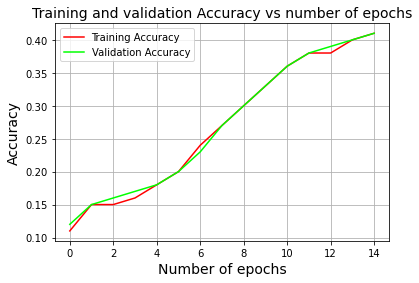

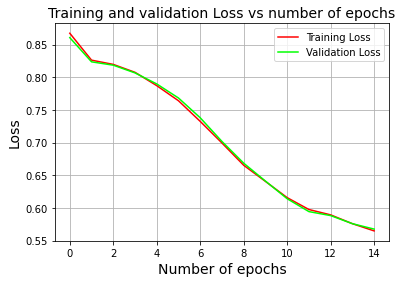

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8y6uddx4 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:nadam 	 L2:0 	 epochs:5 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.24 	 cost_val: 0.24 	 train_acc: 0.64 	 val_acc: 0.64

iter:1 	 cost_train: 0.20 	 cost_val: 0.20 	 train_acc: 0.72 	 val_acc: 0.71

iter:2 	 cost_train: 0.20 	 cost_val: 0.20 	 train_acc: 0.72 	 val_acc: 0.72

iter:3 	 cost_train: 0.21 	 cost_val: 0.21 	 train_acc: 0.69 	 val_acc: 0.69

iter:4 	 cost_train: 0.22 	 cost_val: 0.23 	 train_acc: 0.68 	 val_acc: 0.67


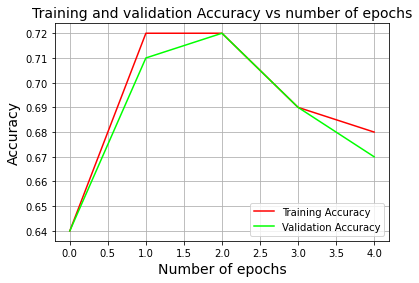

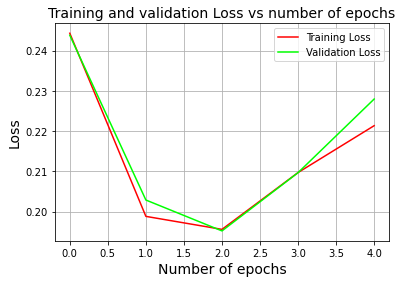

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 0acc1zdo with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:128 	 optimizer:adam 	 L2:0.05 	 epochs:10 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.36 	 cost_val: 0.84 	 train_acc: 0.54 	 val_acc: 0.54

iter:1 	 cost_train: 0.31 	 cost_val: 0.77 	 train_acc: 0.61 	 val_acc: 0.60

iter:2 	 cost_train: 0.28 	 cost_val: 0.72 	 train_acc: 0.66 	 val_acc: 0.66

iter:3 	 cost_train: 0.27 	 cost_val: 0.70 	 train_acc: 0.68 	 val_acc: 0.68

iter:4 	 cost_train: 0.42 	 cost_val: 0.91 	 train_acc: 0.52 	 val_acc: 0.51

iter:5 	 cost_train: 0.50 	 cost_val: 1.08 	 train_acc: 0.24 	 val_acc: 0.24

iter:6 	 cost_train: 0.52 	 cost_val: 1.20 	 train_acc: 0.14 	 val_acc: 0.14

iter:7 	 cost_train: 0.54 	 cost_val: 1.32 	 train_acc: 0.20 	 val_acc: 0.20

iter:8 	 cost_train: 0.55 	 cost_val: 1.45 	 train_acc: 0.10 	 val_acc: 0.10

iter:9 	 cost_train: 0.58 	 cost_val: 1.61 	 train_acc: 0.10 	 val_acc: 0.10


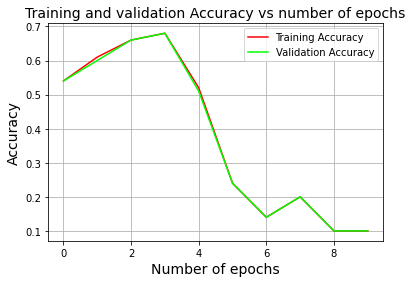

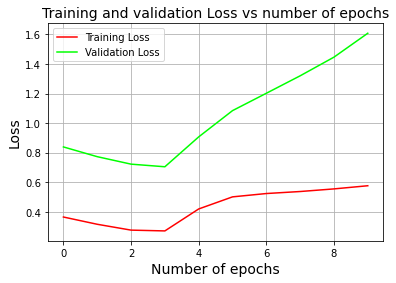

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: j60oqney with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_uniform 	 batchsize:32 	 optimizer:stochastic 	 L2:0 	 epochs:5 	 num_hidden:1 	 num_neurons:64

iter:0 	 cost_train: 0.80 	 cost_val: 0.80 	 train_acc: 0.08 	 val_acc: 0.09

iter:1 	 cost_train: 0.80 	 cost_val: 0.80 	 train_acc: 0.08 	 val_acc: 0.08

iter:2 	 cost_train: 0.80 	 cost_val: 0.79 	 train_acc: 0.08 	 val_acc: 0.09

iter:3 	 cost_train: 0.79 	 cost_val: 0.79 	 train_acc: 0.08 	 val_acc: 0.09

iter:4 	 cost_train: 0.79 	 cost_val: 0.79 	 train_acc: 0.08 	 val_acc: 0.09


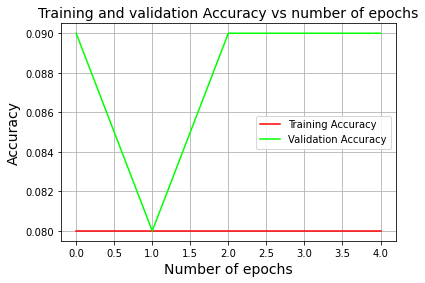

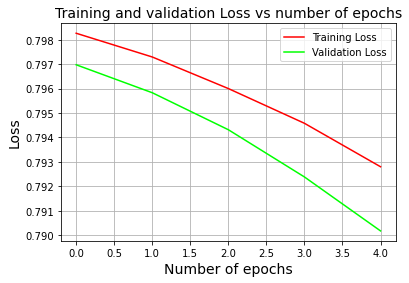

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: w0t9n97z with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: ReLu
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:ReLu 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:RMS 	 L2:0.0005 	 epochs:25 	 num_hidden:3 	 num_neurons:64

iter:0 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10

iter:5 	 cost_train: 0.78 	 cost_val: 0.78 	 train_acc: 0.22 	 val_acc: 0.23

iter:10 	 cost_train: 0.69 	 cost_val: 0.70 	 train_acc: 0.31 	 val_acc: 0.30

iter:15 	 cost_train: 0.66 	 cost_val: 0.67 	 train_acc: 0.34 	 val_acc: 0.33

iter:20 	 cost_train: 0.65 	 cost_val: 0.66 	 train_acc: 0.35 	 val_acc: 0.34


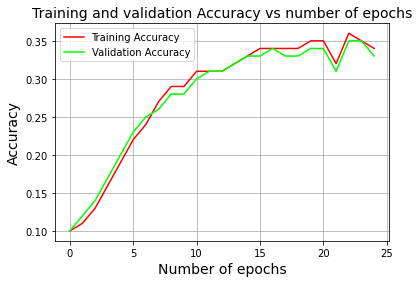

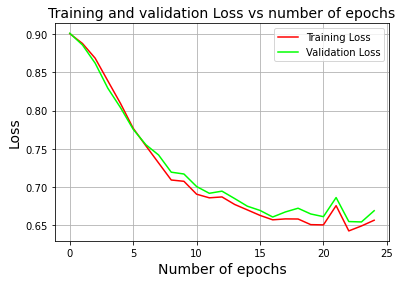

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8xcxydfq with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 20
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:64 	 optimizer:nesterov 	 L2:0.0005 	 epochs:20 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.55 	 cost_val: 0.54 	 train_acc: 0.12 	 val_acc: 0.12

iter:2 	 cost_train: 0.49 	 cost_val: 0.49 	 train_acc: 0.18 	 val_acc: 0.19

iter:4 	 cost_train: 0.48 	 cost_val: 0.48 	 train_acc: 0.18 	 val_acc: 0.18

iter:6 	 cost_train: 0.47 	 cost_val: 0.47 	 train_acc: 0.18 	 val_acc: 0.19

iter:8 	 cost_train: 0.46 	 cost_val: 0.46 	 train_acc: 0.19 	 val_acc: 0.20

iter:10 	 cost_train: 0.45 	 cost_val: 0.44 	 train_acc: 0.21 	 val_acc: 0.21

iter:12 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.23 	 val_acc: 0.23

iter:14 	 cost_train: 0.42 	 cost_val: 0.42 	 train_acc: 0.26 	 val_acc: 0.26

iter:16 	 cost_train: 0.41 	 cost_val: 0.41 	 train_acc: 0.29 	 val_acc: 0.29

iter:18 	 cost_train: 0.40 	 cost_val: 0.40 	 train_acc: 0.32 	 val_acc: 0.32


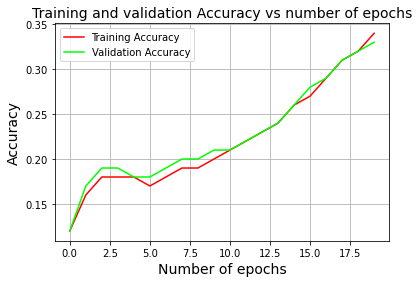

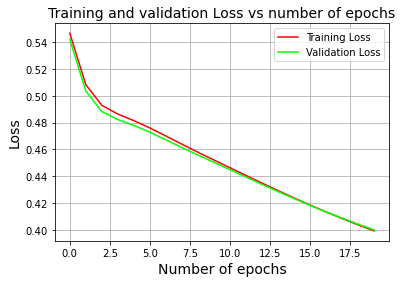

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: fqhkq9rx with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 10
wandb: 	lamb: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: stochastic
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:32 	 optimizer:stochastic 	 L2:0.0005 	 epochs:10 	 num_hidden:3 	 num_neurons:128

iter:0 	 cost_train: 0.71 	 cost_val: 0.70 	 train_acc: 0.17 	 val_acc: 0.17

iter:1 	 cost_train: 0.48 	 cost_val: 0.49 	 train_acc: 0.24 	 val_acc: 0.24

iter:2 	 cost_train: 0.45 	 cost_val: 0.45 	 train_acc: 0.25 	 val_acc: 0.25

iter:3 	 cost_train: 0.49 	 cost_val: 0.49 	 train_acc: 0.13 	 val_acc: 0.13

iter:4 	 cost_train: 0.44 	 cost_val: 0.45 	 train_acc: 0.21 	 val_acc: 0.21

iter:5 	 cost_train: 0.47 	 cost_val: 0.48 	 train_acc: 0.13 	 val_acc: 0.13

iter:6 	 cost_train: 0.46 	 cost_val: 0.47 	 train_acc: 0.13 	 val_acc: 0.13

iter:7 	 cost_train: 0.45 	 cost_val: 0.46 	 train_acc: 0.18 	 val_acc: 0.17

iter:8 	 cost_train: 0.44 	 cost_val: 0.46 	 train_acc: 0.24 	 val_acc: 0.23

iter:9 	 cost_train: 0.45 	 cost_val: 0.46 	 train_acc: 0.25 	 val_acc: 0.25


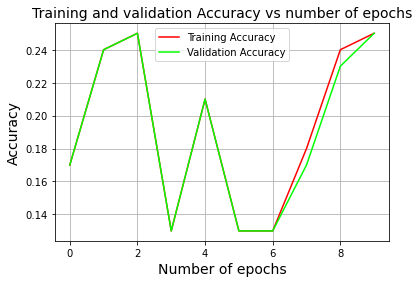

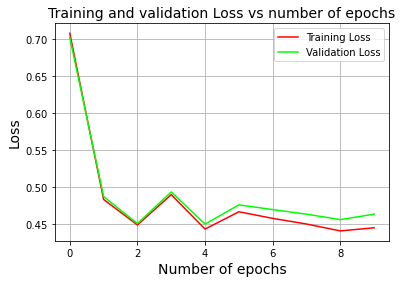

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 4ntytx26 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:momentum 	 L2:0.05 	 epochs:25 	 num_hidden:2 	 num_neurons:64

iter:0 	 cost_train: 0.60 	 cost_val: 0.80 	 train_acc: 0.21 	 val_acc: 0.21

iter:5 	 cost_train: 0.45 	 cost_val: 0.69 	 train_acc: 0.24 	 val_acc: 0.23

iter:10 	 cost_train: 0.40 	 cost_val: 0.71 	 train_acc: 0.40 	 val_acc: 0.40

iter:15 	 cost_train: 0.40 	 cost_val: 0.76 	 train_acc: 0.44 	 val_acc: 0.43

iter:20 	 cost_train: 0.39 	 cost_val: 0.79 	 train_acc: 0.43 	 val_acc: 0.43


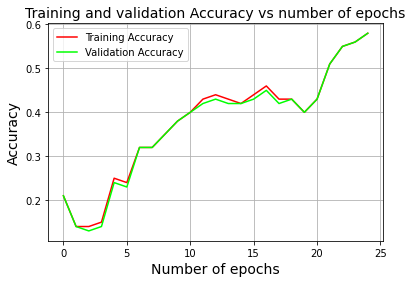

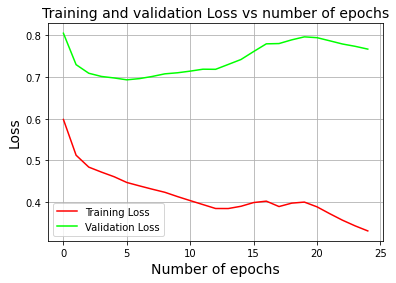

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: dj63gd4i with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: ReLu
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:ReLu 	 init_mode:Xavier 	 batchsize:32 	 optimizer:RMS 	 L2:0.05 	 epochs:15 	 num_hidden:2 	 num_neurons:32

iter:0 	 cost_train: 0.74 	 cost_val: 0.78 	 train_acc: 0.25 	 val_acc: 0.26

iter:3 	 cost_train: 0.90 	 cost_val: 0.92 	 train_acc: 0.10 	 val_acc: 0.09

iter:6 	 cost_train: 0.76 	 cost_val: 0.76 	 train_acc: 0.10 	 val_acc: 0.10

iter:9 	 cost_train: 0.90 	 cost_val: 0.91 	 train_acc: 0.10 	 val_acc: 0.09

iter:12 	 cost_train: 0.90 	 cost_val: 0.90 	 train_acc: 0.10 	 val_acc: 0.10


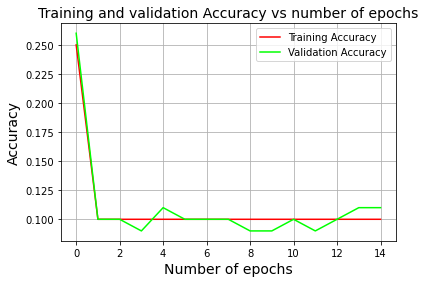

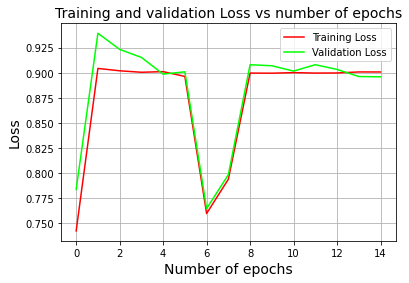

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 1dj98het with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_normal
wandb: 	iterations: 25
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: nesterov
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_normal 	 batchsize:128 	 optimizer:nesterov 	 L2:0 	 epochs:25 	 num_hidden:1 	 num_neurons:64

iter:0 	 cost_train: 0.82 	 cost_val: 0.81 	 train_acc: 0.06 	 val_acc: 0.07

iter:5 	 cost_train: 0.66 	 cost_val: 0.66 	 train_acc: 0.08 	 val_acc: 0.08

iter:10 	 cost_train: 0.61 	 cost_val: 0.61 	 train_acc: 0.10 	 val_acc: 0.10

iter:15 	 cost_train: 0.58 	 cost_val: 0.58 	 train_acc: 0.14 	 val_acc: 0.13

iter:20 	 cost_train: 0.56 	 cost_val: 0.56 	 train_acc: 0.15 	 val_acc: 0.15


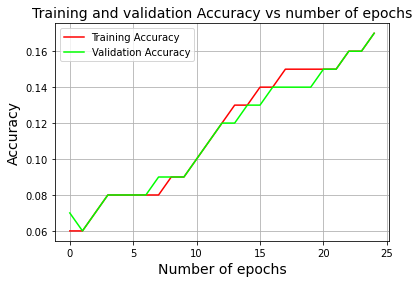

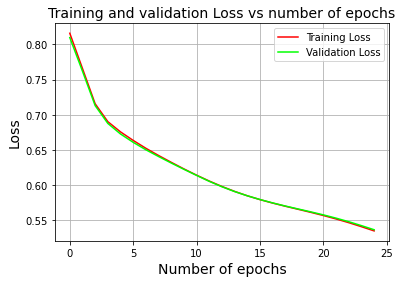

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: irgaxw37 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.001 	 activationfunction:tanh 	 init_mode:Xavier 	 batchsize:64 	 optimizer:nadam 	 L2:0.05 	 epochs:5 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.34 	 cost_val: 0.63 	 train_acc: 0.56 	 val_acc: 0.55

iter:1 	 cost_train: 0.29 	 cost_val: 0.52 	 train_acc: 0.64 	 val_acc: 0.63

iter:2 	 cost_train: 0.23 	 cost_val: 0.40 	 train_acc: 0.69 	 val_acc: 0.68

iter:3 	 cost_train: 0.22 	 cost_val: 0.36 	 train_acc: 0.70 	 val_acc: 0.69

iter:4 	 cost_train: 0.19 	 cost_val: 0.29 	 train_acc: 0.74 	 val_acc: 0.74


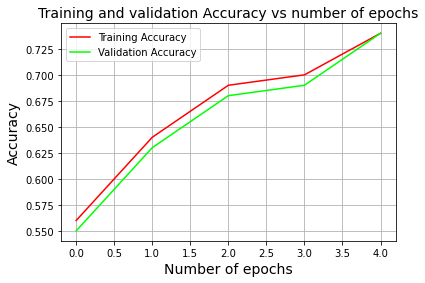

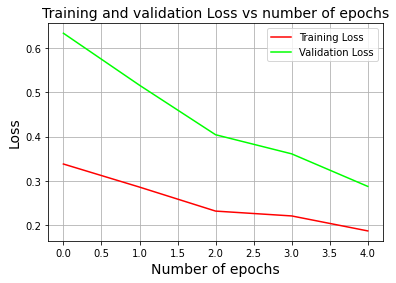

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xwy7r3l7 with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Random_uniform
wandb: 	iterations: 10
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Random_uniform 	 batchsize:64 	 optimizer:nadam 	 L2:0 	 epochs:10 	 num_hidden:1 	 num_neurons:64

iter:0 	 cost_train: 0.55 	 cost_val: 0.55 	 train_acc: 0.17 	 val_acc: 0.17

iter:1 	 cost_train: 0.40 	 cost_val: 0.40 	 train_acc: 0.38 	 val_acc: 0.38

iter:2 	 cost_train: 0.33 	 cost_val: 0.34 	 train_acc: 0.50 	 val_acc: 0.50

iter:3 	 cost_train: 0.30 	 cost_val: 0.30 	 train_acc: 0.56 	 val_acc: 0.56

iter:4 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.60 	 val_acc: 0.59

iter:5 	 cost_train: 0.26 	 cost_val: 0.27 	 train_acc: 0.62 	 val_acc: 0.61

iter:6 	 cost_train: 0.25 	 cost_val: 0.26 	 train_acc: 0.63 	 val_acc: 0.62

iter:7 	 cost_train: 0.25 	 cost_val: 0.25 	 train_acc: 0.64 	 val_acc: 0.64

iter:8 	 cost_train: 0.24 	 cost_val: 0.24 	 train_acc: 0.65 	 val_acc: 0.64

iter:9 	 cost_train: 0.23 	 cost_val: 0.24 	 train_acc: 0.66 	 val_acc: 0.65


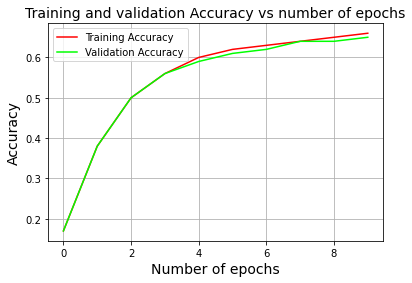

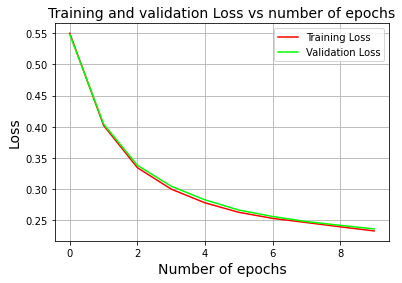

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: u6rlv5p3 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 5
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:32 	 optimizer:nadam 	 L2:0.05 	 epochs:5 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.70 	 cost_val: 1.12 	 train_acc: 0.16 	 val_acc: 0.15

iter:1 	 cost_train: 0.49 	 cost_val: 0.91 	 train_acc: 0.19 	 val_acc: 0.20

iter:2 	 cost_train: 0.46 	 cost_val: 0.87 	 train_acc: 0.28 	 val_acc: 0.29

iter:3 	 cost_train: 0.44 	 cost_val: 0.84 	 train_acc: 0.34 	 val_acc: 0.34

iter:4 	 cost_train: 0.41 	 cost_val: 0.81 	 train_acc: 0.45 	 val_acc: 0.45


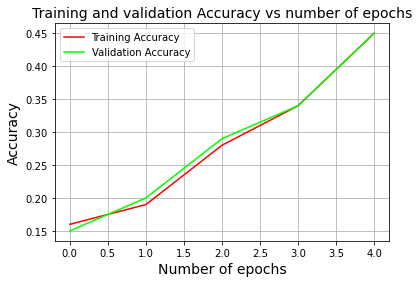

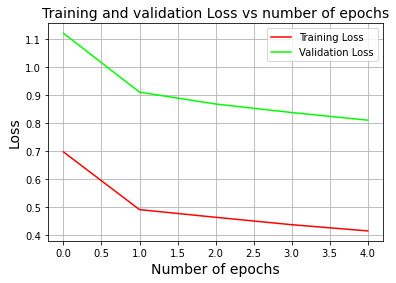

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 7mkncq96 with config:
wandb: 	Batch_size: 128
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 5
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 2
wandb: 	num_neurons: 128
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:128 	 optimizer:RMS 	 L2:0 	 epochs:5 	 num_hidden:2 	 num_neurons:128

iter:0 	 cost_train: 0.60 	 cost_val: 0.60 	 train_acc: 0.15 	 val_acc: 0.14

iter:1 	 cost_train: 0.51 	 cost_val: 0.51 	 train_acc: 0.23 	 val_acc: 0.23

iter:2 	 cost_train: 0.43 	 cost_val: 0.43 	 train_acc: 0.32 	 val_acc: 0.31

iter:3 	 cost_train: 0.39 	 cost_val: 0.38 	 train_acc: 0.40 	 val_acc: 0.40

iter:4 	 cost_train: 0.36 	 cost_val: 0.36 	 train_acc: 0.45 	 val_acc: 0.45


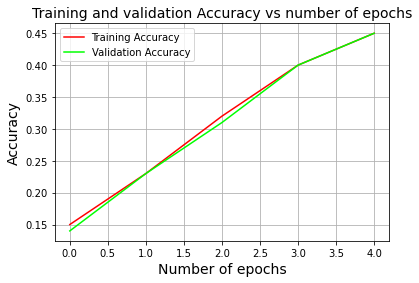

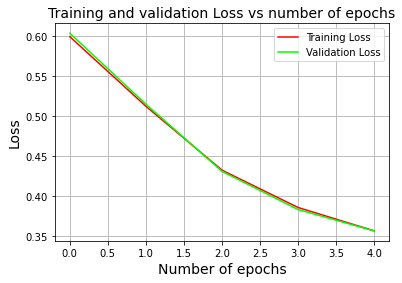

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lt1v3its with config:
wandb: 	Batch_size: 64
wandb: 	activation_function: tanh
wandb: 	init_mode: Random_normal
wandb: 	iterations: 20
wandb: 	lamb: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 1
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:tanh 	 init_mode:Random_normal 	 batchsize:64 	 optimizer:adam 	 L2:0 	 epochs:20 	 num_hidden:1 	 num_neurons:128

iter:0 	 cost_train: 0.65 	 cost_val: 0.66 	 train_acc: 0.23 	 val_acc: 0.23

iter:2 	 cost_train: 0.44 	 cost_val: 0.44 	 train_acc: 0.38 	 val_acc: 0.38

iter:4 	 cost_train: 0.38 	 cost_val: 0.39 	 train_acc: 0.46 	 val_acc: 0.45

iter:6 	 cost_train: 0.34 	 cost_val: 0.35 	 train_acc: 0.51 	 val_acc: 0.51

iter:8 	 cost_train: 0.33 	 cost_val: 0.33 	 train_acc: 0.55 	 val_acc: 0.53

iter:10 	 cost_train: 0.31 	 cost_val: 0.32 	 train_acc: 0.54 	 val_acc: 0.53

iter:12 	 cost_train: 0.29 	 cost_val: 0.30 	 train_acc: 0.59 	 val_acc: 0.58

iter:14 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.60 	 val_acc: 0.60

iter:16 	 cost_train: 0.28 	 cost_val: 0.28 	 train_acc: 0.60 	 val_acc: 0.59

iter:18 	 cost_train: 0.28 	 cost_val: 0.29 	 train_acc: 0.60 	 val_acc: 0.59


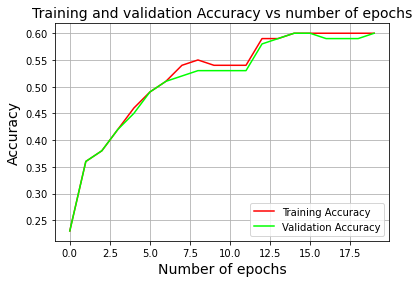

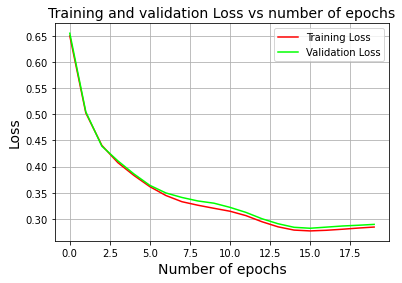

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lhvfydm4 with config:
wandb: 	Batch_size: 32
wandb: 	activation_function: sigmoid
wandb: 	init_mode: Xavier
wandb: 	iterations: 15
wandb: 	lamb: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMS
wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


learningrate:0.0001 	 activationfunction:sigmoid 	 init_mode:Xavier 	 batchsize:32 	 optimizer:RMS 	 L2:0.05 	 epochs:15 	 num_hidden:3 	 num_neurons:32

iter:0 	 cost_train: 0.46 	 cost_val: 0.55 	 train_acc: 0.19 	 val_acc: 0.20

iter:3 	 cost_train: 0.41 	 cost_val: 0.46 	 train_acc: 0.34 	 val_acc: 0.34

iter:6 	 cost_train: 0.36 	 cost_val: 0.41 	 train_acc: 0.48 	 val_acc: 0.47

iter:9 	 cost_train: 0.36 	 cost_val: 0.40 	 train_acc: 0.46 	 val_acc: 0.46

iter:12 	 cost_train: 0.43 	 cost_val: 0.48 	 train_acc: 0.20 	 val_acc: 0.20


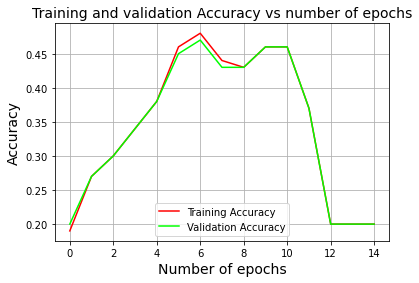

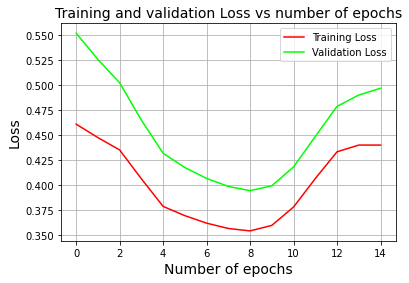

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


In [34]:
sweep_config = {
    "name":"CS6910 Assignment 1 - Cross Entropy Loss",
    "Metric":{
        "name":"Validation_accuracy",
        "goal":"maximize"
    },
    "method":"random",
    "parameters":{
        "learning_rate":{
            "values":[0.001,0.0001]
        },
        "activation_function":{
            "values":["sigmoid","ReLu","tanh"]
        },
        "loss":{
            "values":["mse"]
        },
        "init_mode":{
            "values":["Xavier","Random_uniform","Random_normal"]
        },
        "optimizer":{
            "values":["stochastic","momentum","nesterov","RMS","adam","nadam"]
        },
        "Batch_size":{
        "values":[32,64,128]
        },
        "iterations":{
            "values":[5,10,15,20,25,30]
        },
        "lamb":{
            "values":[0,0.0005,0.05]
        },
        "num_neurons":{
            "values":[32,64,128]
        },
        "num_hidden":{
            "values":[1,2,3]
        }
    }
}

sweep_id = wandb.sweep(sweep_config,project="Question_1")
wandb.agent(sweep_id,Neural_Network,count=100)